# phase 1 : Senario IID

In [1]:
# Cell 1
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters
img_size = (224, 224)
batch_size = 8
num_clients = 3
learning_rate = 1e-4
num_rounds = 10
local_epochs = 7  # Increase slightly from 5 to 7
unfreeze_layers = 20

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

# Use preprocess_input for ResNet50
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

def split_data(generator, num_clients):
    data = []
    labels = []
    generator.reset()
    for _ in range(len(generator)):
        x_batch, y_batch = next(generator)
        data.append(x_batch)
        labels.append(y_batch)
    if len(data) == 0:
        raise ValueError("No data found. Check dataset structure or class names.")
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    split_data_arrays = np.array_split(data, num_clients)
    split_labels_arrays = np.array_split(labels, num_clients)
    client_data = []
    for i in range(num_clients):
        client_data.append((split_data_arrays[i], split_labels_arrays[i]))
    return client_data

client_data = split_data(train_generator, num_clients)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    # Freeze all layers
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last 30 layers
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))


Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 88% 63.0M/71.5M [00:00<00:00, 91.8MB/s]
100% 71.5M/71.5M [00:00<00:00, 94.2MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


# FedAvg (IID)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
FedAvg - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0929, Average Training Accuracy: 0.9684
FedAvg - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0676, Average Training Accuracy: 0.9756
FedAvg - Round 3/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0444, Average Training Accuracy: 0.9844
FedAvg - Round 4/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0325, Average Training Accuracy: 0.9896
FedAvg - Round 5/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0312, Average Training Accuracy: 0.9901
FedAvg - Round 6/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0371, Average Training Accuracy: 0.9878
FedAvg - Round 7/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0268, Average Training Accuracy: 0.9914
FedAvg - Round 8/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0248, Average

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedAvg Test Accuracy: 94.68%


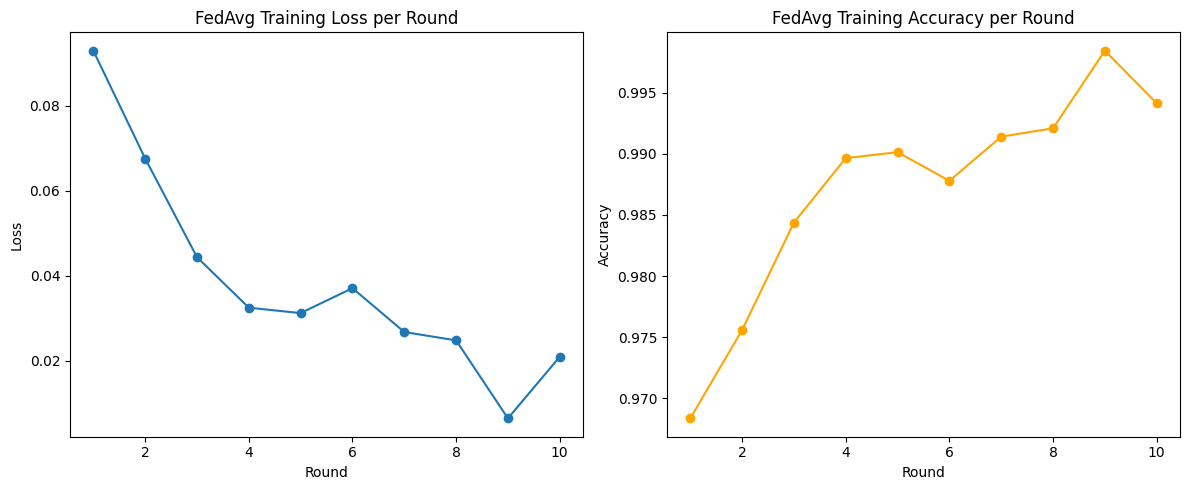

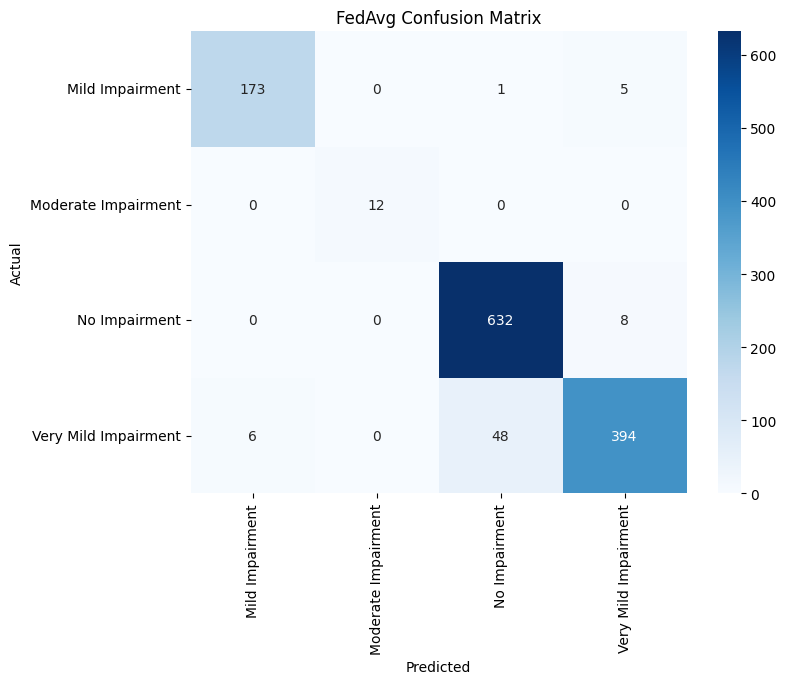

FedAvg Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.97      0.97      0.97       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.93      0.99      0.96       640
Very Mild Impairment       0.97      0.88      0.92       448

            accuracy                           0.95      1279
           macro avg       0.97      0.96      0.96      1279
        weighted avg       0.95      0.95      0.95      1279



In [ ]:
global_model = create_model()
global_weights = global_model.get_weights()

fedavg_train_loss = []
fedavg_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedAvg - Round {round_num+1}/{num_rounds}")
    local_weights = []
    local_losses = []
    local_accuracies = []

    for client_num, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_num+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)
        client_model.compile(optimizer=client_optimizer,
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        local_weights.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    # Average local weights
    new_weights = []
    for weights in zip(*local_weights):
        new_weights.append(np.mean(weights, axis=0))
    global_weights = new_weights
    global_model.set_weights(global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedavg_train_loss.append(avg_loss)
    fedavg_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedAvg Test Accuracy: {test_acc*100:.2f}%")

# Plot metrics and confusion matrix
plot_metrics(fedavg_train_loss, fedavg_train_accuracy, "FedAvg")
plot_confusion_matrix(global_model, test_generator, classes, "FedAvg")


FEDPROX : (IID)

In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters
img_size = (224, 224)
batch_size = 8
num_clients = 3
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
mu = 0.01  # FedProx coefficient
unfreeze_layers = 20  # Unfreeze last 20 layers as in successful FedAvg

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

# Use preprocess_input for ResNet50
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

def split_data(generator, num_clients):
    data = []
    labels = []
    generator.reset()
    for _ in range(len(generator)):
        x_batch, y_batch = next(generator)
        data.append(x_batch)
        labels.append(y_batch)
    if len(data) == 0:
        raise ValueError("No data found. Check dataset structure and class folder names.")
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    split_data_arrays = np.array_split(data, num_clients)
    split_labels_arrays = np.array_split(labels, num_clients)
    client_data = []
    for i in range(num_clients):
        client_data.append((split_data_arrays[i], split_labels_arrays[i]))
    return client_data

client_data = split_data(train_generator, num_clients)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    # Freeze all layers
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last 20 layers (as in successful FedAvg scenario)
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))


Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 98% 70.0M/71.5M [00:02<00:00, 27.5MB/s]
100% 71.5M/71.5M [00:02<00:00, 25.9MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


FedProx - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.4841, Average Training Accuracy: 0.9113
FedProx - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.3367, Average Training Accuracy: 0.9530
FedProx - Round 3/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.2322, Average Training Accuracy: 0.9715
FedProx - Round 4/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.2069, Average Training Accuracy: 0.9779
FedProx - Round 5/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1769, Average Training Accuracy: 0.9835
FedProx - Round 6/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1506, Average Training Accuracy: 0.9891
FedProx - Round 7/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1471, Average Training Accuracy: 0.9875
FedProx - Round 8/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1010, Average Training Accuracy: 0.9941
FedProx - Round 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedProx Test Accuracy: 95.47%


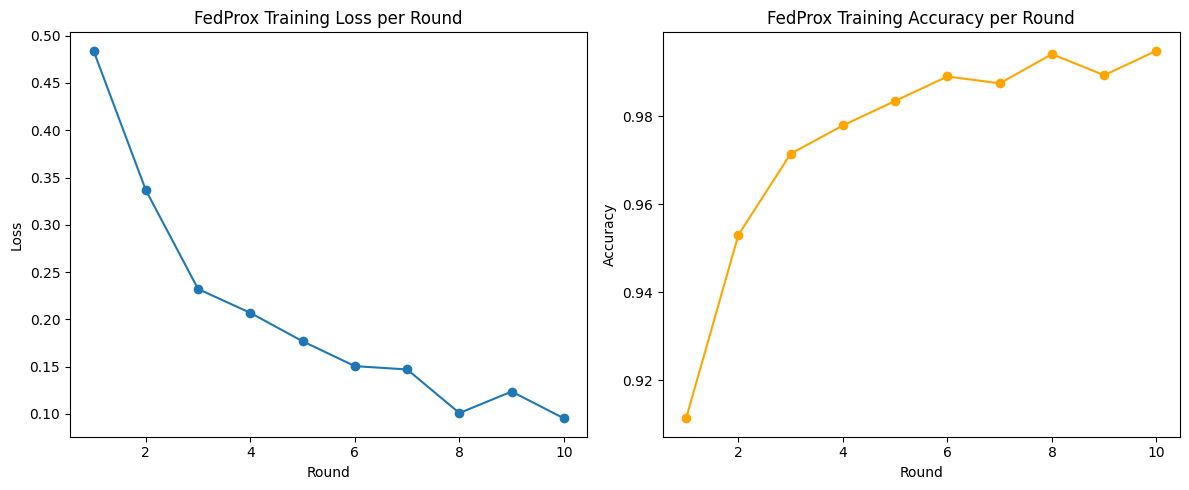

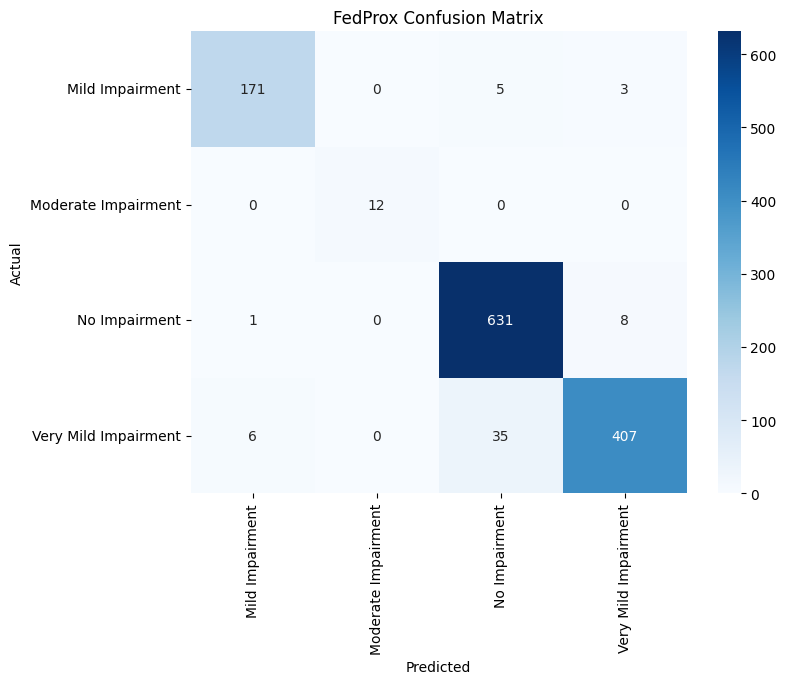

FedProx Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.96      0.96      0.96       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.94      0.99      0.96       640
Very Mild Impairment       0.97      0.91      0.94       448

            accuracy                           0.95      1279
           macro avg       0.97      0.96      0.97      1279
        weighted avg       0.96      0.95      0.95      1279



In [ ]:
mu = 0.01
global_model = create_model()
global_weights = global_model.get_weights()

fedprox_train_loss = []
fedprox_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedProx - Round {round_num+1}/{num_rounds}")
    local_weights = []
    local_losses = []
    local_accuracies = []

    # ایجاد مدل جهانی با وزن‌های فعلی برای ساخت global_weights_tensor
    global_model.set_weights(global_weights)
    # فقط وزن‌های قابل‌آموزش مدل جهانی را در نظر می‌گیریم
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    for client_num, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_num+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)

        # Define prox_loss based on trainable variables only
        def prox_loss(y_true, y_pred):
            ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
            prox_term = 0.0
            # حال فقط وزن‌های قابل‌آموزش را با global_weights_tensor مقایسه می‌کنیم
            for w_local, w_global_t in zip(client_model.trainable_variables, global_weights_tensor):
                prox_term += tf.reduce_sum(tf.square(w_local - w_global_t))
            prox_term = (mu / 2.0) * prox_term
            return ce_loss + prox_term

        client_model.compile(optimizer=client_optimizer,
                             loss=prox_loss,
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        local_weights.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    # Average local weights
    new_weights = []
    for weights in zip(*local_weights):
        new_weights.append(np.mean(weights, axis=0))
    global_weights = new_weights

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedprox_train_loss.append(avg_loss)
    fedprox_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedProx Test Accuracy: {test_acc*100:.2f}%")

# Plot metrics and confusion matrix
plot_metrics(fedprox_train_loss, fedprox_train_accuracy, "FedProx")
plot_confusion_matrix(global_model, test_generator, classes, "FedProx")


FEDADMM
if we want more accuracy use less panalty term.

In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the best Alzheimer MRI dataset
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters
img_size = (224, 224)
batch_size = 8
num_clients = 3
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
rho = 0.5
unfreeze_layers = 20

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

# Use preprocess_input for ResNet50
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

def split_data(generator, num_clients):
    data = []
    labels = []
    generator.reset()
    for _ in range(len(generator)):
        x_batch, y_batch = next(generator)
        data.append(x_batch)
        labels.append(y_batch)
    if len(data) == 0:
        raise ValueError("No data found. Check dataset structure and class names.")
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    split_data_arrays = np.array_split(data, num_clients)
    split_labels_arrays = np.array_split(labels, num_clients)
    client_data = []
    for i in range(num_clients):
        client_data.append((split_data_arrays[i], split_labels_arrays[i]))
    return client_data

client_data = split_data(train_generator, num_clients)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    # Freeze all layers
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last 20 layers
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))


Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 99% 71.0M/71.5M [00:03<00:00, 32.0MB/s]
100% 71.5M/71.5M [00:03<00:00, 23.4MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
FedADMM - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 1.3537, Average Training Accuracy: 0.7288
FedADMM - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 1.0363, Average Training Accuracy: 0.7639
FedADMM - Round 3/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.9309, Average Training Accuracy: 0.7897
FedADMM - Round 4/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.8877, Average Training Accuracy: 0.7994
FedADMM - Round 5/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.8226, Average Training Accuracy: 0.8196
FedADMM - Round 6/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.7729, Average Training Accuracy: 0.8346
FedADMM - Round 7/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.7424, Average Training Accuracy: 0.8464
FedADMM - Round 8/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.7239,

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedADMM Test Accuracy: 79.75%


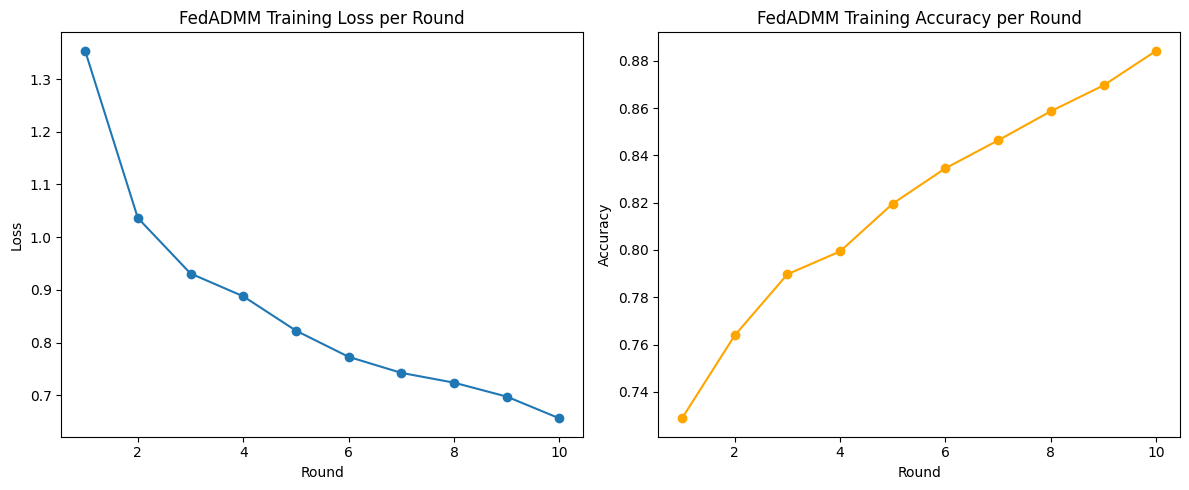

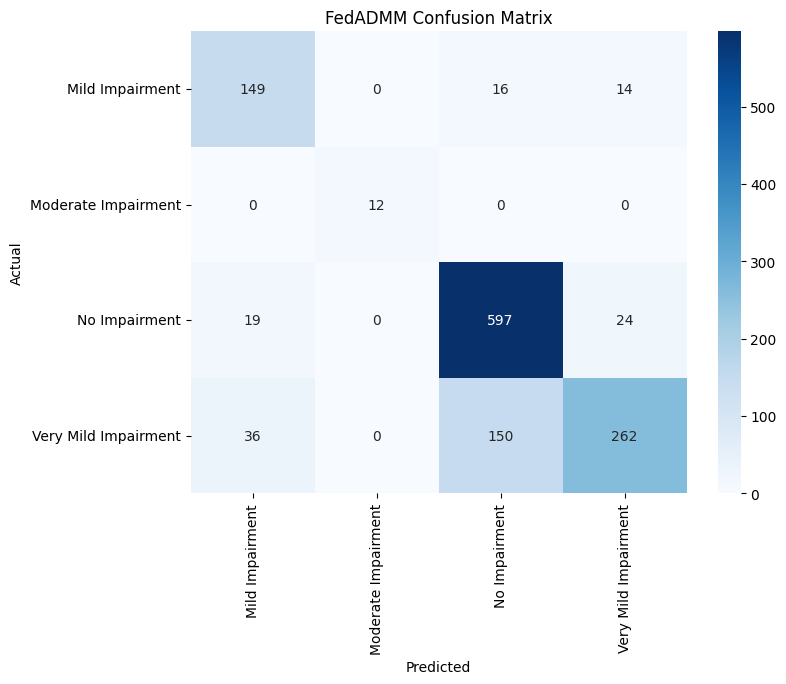

FedADMM Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.73      0.83      0.78       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.78      0.93      0.85       640
Very Mild Impairment       0.87      0.58      0.70       448

            accuracy                           0.80      1279
           macro avg       0.85      0.84      0.83      1279
        weighted avg       0.81      0.80      0.79      1279



In [ ]:
global_model = create_model()
global_weights = global_model.get_weights()

# Initialize dual variables (λ) for each client and each trainable variable
global_model.set_weights(global_weights)
lambda_clients = []
for _ in range(num_clients):
    lam = []
    for w in global_model.trainable_variables:
        lam.append(np.zeros_like(w.numpy()))
    lambda_clients.append(lam)

fedadmm_train_loss = []
fedadmm_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedADMM - Round {round_num+1}/{num_rounds}")

    local_weights = []
    local_losses = []
    local_accuracies = []

    # Update global model and get global trainable weights
    global_model.set_weights(global_weights)
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)

        # Define admm_loss
        def admm_loss(y_true, y_pred):
            ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
            penalty = 0.0
            # w_local, w_global_t, lam must match in order and shape
            for w_local, w_global_t, lam in zip(client_model.trainable_variables, global_weights_tensor, lambda_clients[client_idx]):
                diff = w_local - w_global_t + (1.0/rho)*tf.convert_to_tensor(lam, dtype=w_local.dtype)
                penalty += tf.reduce_sum(tf.square(diff))
            return ce_loss + (rho/2)*penalty

        client_model.compile(optimizer=client_optimizer,
                             loss=admm_loss,
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()

        local_weights.append(w_local)
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    # Average local weights
    new_weights = []
    for weights_set in zip(*local_weights):
        new_weights.append(np.mean(weights_set, axis=0))
    global_weights = new_weights

    # Update λ after averaging global weights
    global_model.set_weights(global_weights)
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    # Update λ
    for client_idx, w_local in enumerate(local_weights):
        client_model = create_model()
        client_model.set_weights(w_local)
        client_trainable = client_model.trainable_variables

        for i in range(len(client_trainable)):
            lam_np = lambda_clients[client_idx][i]
            w_local_np = client_trainable[i].numpy()
            w_global_np = global_weights_tensor[i].numpy()
            lam_np = lam_np + rho*(w_local_np - w_global_np)
            lambda_clients[client_idx][i] = lam_np

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedadmm_train_loss.append(avg_loss)
    fedadmm_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

# Final evaluation on test data
final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedADMM Test Accuracy: {test_acc*100:.2f}%")

# Plot metrics and confusion matrix
plot_metrics(fedadmm_train_loss, fedadmm_train_accuracy, "FedADMM")
plot_confusion_matrix(global_model, test_generator, classes, "FedADMM")


# Centerelised

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 98% 70.0M/71.5M [00:04<00:00, 26.9MB/s]
100% 71.5M/71.5M [00:04<00:00, 18.5MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1280/1280 ━━━━━━━━━━━━━━━━━━━━ 64s 36ms/step - accuracy: 0.7129 - loss: 0.6928
Epoch 2/10
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 48s 37ms/step - accuracy: 0.8631 - loss: 0.3394
Epoch 3/10
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 48s 37ms/step - accuracy: 0.9133 - loss: 0.2260
Epoch 4/10
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 49s 38ms/step - accuracy: 0.9502 - loss: 0.1363
Epoch 5/10
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.9686 - loss: 0.0901
Epoch 6/10
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 48s 38ms/step - accuracy: 0.9750 - loss: 0.0731
Epoch 7/10
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 49s 38ms/step - accuracy: 0.9824 - loss: 0.0540
Epoch 8/10
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 49s 38ms/step - accuracy: 0.9883 - loss: 0.0358
Epoch 9/10
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 49s 38ms/step - accuracy: 0.9848 - loss: 0.0461
Epoch 10/10
1280/1280 ━━━━━━━━━━━━━━━━━━━━ 49s 38ms/step - accuracy: 0.9849 - loss: 0.0418
Centralized Test Accuracy: 95.47%


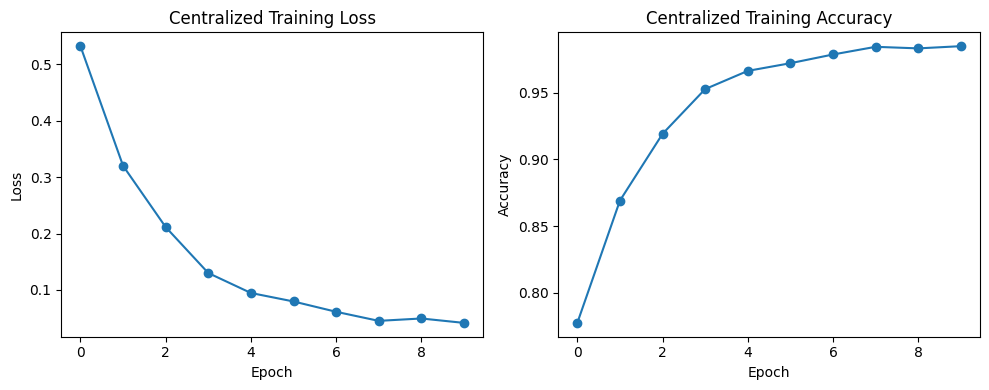

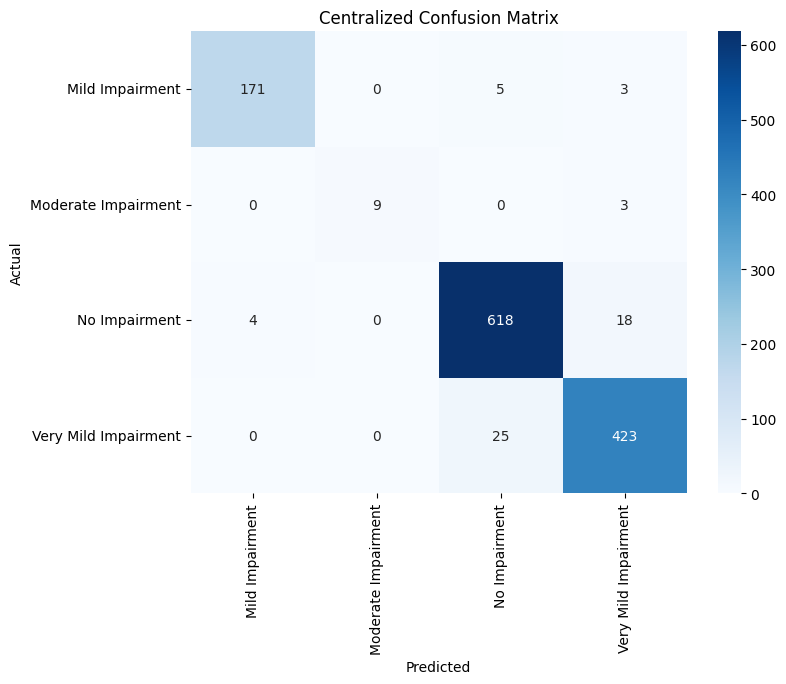

Centralized Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.98      0.96      0.97       179
 Moderate Impairment       1.00      0.75      0.86        12
       No Impairment       0.95      0.97      0.96       640
Very Mild Impairment       0.95      0.94      0.95       448

            accuracy                           0.95      1279
           macro avg       0.97      0.90      0.93      1279
        weighted avg       0.95      0.95      0.95      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the best Alzheimer MRI dataset
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
epochs = 10
unfreeze_layers = 20

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

# Use preprocess_input for ResNet50
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    # Freeze all layers
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last 20 layers
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

model = create_model()
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1)

test_loss, test_acc = model.evaluate(test_generator, verbose=0)
print(f"Centralized Test Accuracy: {test_acc*100:.2f}%")

# Plot training metrics for centralized training
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], marker='o')
plt.title('Centralized Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], marker='o')
plt.title('Centralized Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

# Confusion Matrix and Classification Report for Centralized
test_generator.reset()
y_pred_prob = model.predict(test_generator, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Centralized Confusion Matrix")
plt.show()

print("Centralized Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))


# phase 2 : senario NONIID

# FedAvg with Non-IID Label Skew

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 99% 71.0M/71.5M [00:04<00:00, 23.0MB/s]
100% 71.5M/71.5M [00:04<00:00, 15.1MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FedAvg Label Skew - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1641, Average Training Accuracy: 0.9408
FedAvg Label Skew - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0818, Average Training Accuracy: 0.9712

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedAvg Label Skew Test Accuracy: 93.04%


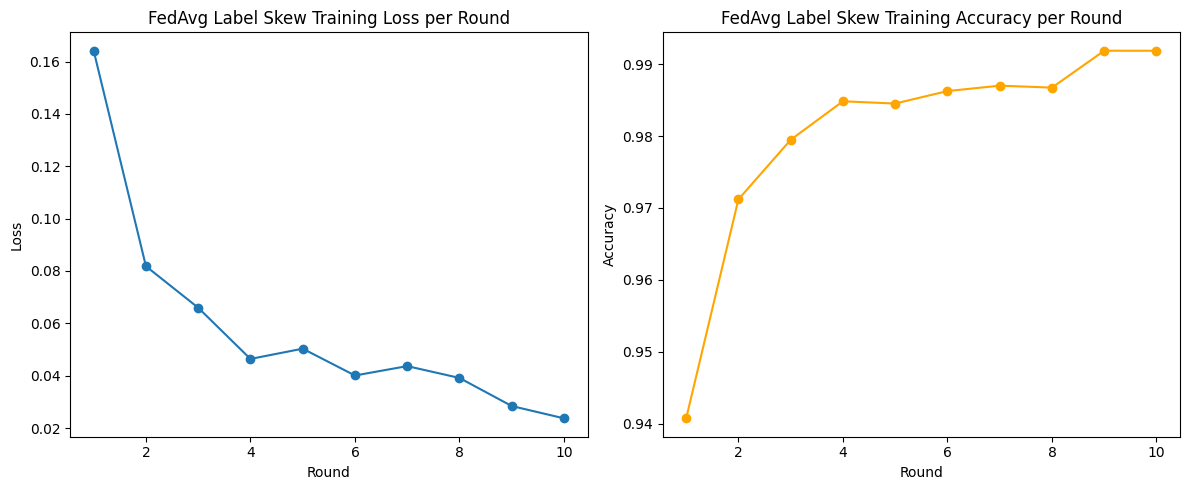

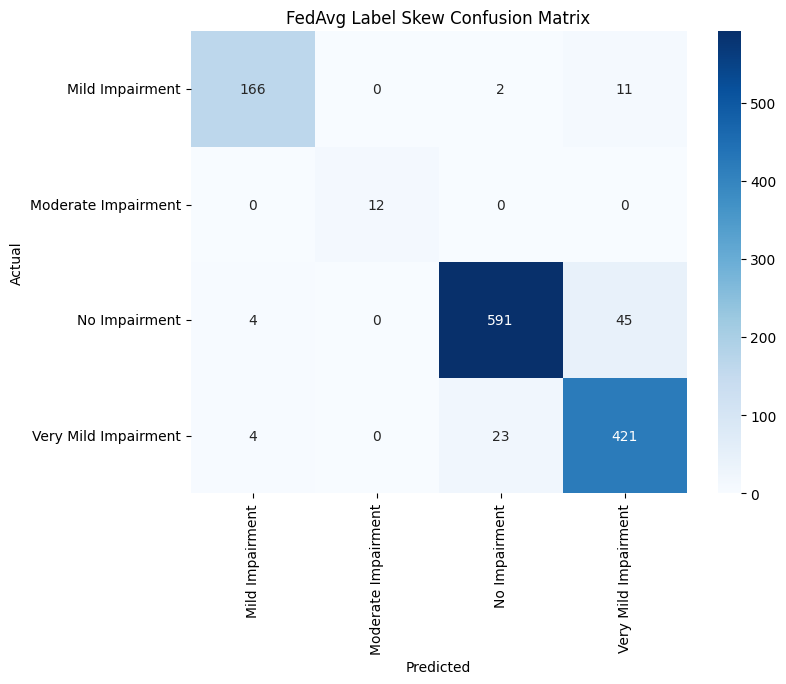

FedAvg Label Skew Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.95      0.93      0.94       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.96      0.92      0.94       640
Very Mild Impairment       0.88      0.94      0.91       448

            accuracy                           0.93      1279
           macro avg       0.95      0.95      0.95      1279
        weighted avg       0.93      0.93      0.93      1279



In [ ]:
# Scenario 1: FedAvg with Non-IID Label Skew

!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

# Extract all data
train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_label_skew_data(X, y, classes, num_clients):
    c_mild = classes.index("Mild Impairment")
    c_mod = classes.index("Moderate Impairment")
    c_no = classes.index("No Impairment")
    c_very = classes.index("Very Mild Impairment")

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    def choose_frac(cls_ind, frac):
        count = int(len(cls_ind)*frac)
        chosen = np.random.choice(cls_ind, count, replace=False)
        remain = np.setdiff1d(cls_ind, chosen)
        return chosen, remain

    # Client 1:
    mild_chosen, class_indices[c_mild] = choose_frac(class_indices[c_mild], 0.7)
    others1 = np.concatenate([class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    others1_count = int(len(others1)*0.3) if len(others1)>0 else 0
    if others1_count>0:
        others1_chosen = np.random.choice(others1, others1_count, replace=False)
        for cc in [c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], others1_chosen[np.isin(others1_chosen, class_indices[cc])])
    else:
        others1_chosen = np.array([], dtype=int)
    client1_indices = np.concatenate([mild_chosen, others1_chosen])

    # Client 2:
    no_ = class_indices[c_no]
    mod_ = class_indices[c_mod]
    no_count = int(len(no_)*0.35) if len(no_)>0 else 0
    mod_count = int(len(mod_)*0.35) if len(mod_)>0 else 0
    no_chosen = np.random.choice(no_, no_count, replace=False) if no_count>0 else np.array([], dtype=int)
    mod_chosen = np.random.choice(mod_, mod_count, replace=False) if mod_count>0 else np.array([], dtype=int)
    class_indices[c_no] = np.setdiff1d(class_indices[c_no], no_chosen)
    class_indices[c_mod] = np.setdiff1d(class_indices[c_mod], mod_chosen)

    rem2 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem2_count = int(len(rem2)*0.3) if len(rem2)>0 else 0
    if rem2_count>0:
        rem2_chosen = np.random.choice(rem2, rem2_count, replace=False)
        for cc in [c_mild, c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], rem2_chosen[np.isin(rem2_chosen, class_indices[cc])])
    else:
        rem2_chosen = np.array([], dtype=int)
    client2_indices = np.concatenate([no_chosen, mod_chosen, rem2_chosen])

    # Client 3:
    very_ = class_indices[c_very]
    v_count = int(len(very_)*0.7) if len(very_)>0 else 0
    v_chosen = np.random.choice(very_, v_count, replace=False) if v_count>0 else np.array([], dtype=int)
    class_indices[c_very] = np.setdiff1d(class_indices[c_very], v_chosen)

    rem3 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem3_count = int(len(rem3)*0.3) if len(rem3)>0 else 0
    if rem3_count > len(rem3):
        rem3_count = len(rem3)
    rem3_chosen = np.random.choice(rem3, rem3_count, replace=False) if rem3_count>0 else np.array([], dtype=int)

    client3_indices = np.concatenate([v_chosen, rem3_chosen])

    for arr in [client1_indices, client2_indices, client3_indices]:
        np.random.shuffle(arr)

    return [(X[client1_indices], y[client1_indices]),
            (X[client2_indices], y[client2_indices]),
            (X[client3_indices], y[client3_indices])]

client_data = create_label_skew_data(X, y, classes, num_clients)

global_model = create_model()
global_weights = global_model.get_weights()

fedavg_train_loss = []
fedavg_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedAvg Label Skew - Round {round_num+1}/{num_rounds}")
    local_weights = []
    local_losses = []
    local_accuracies = []

    for client_num, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_num+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)
        client_model.compile(optimizer=client_optimizer,
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        local_weights.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    new_weights = []
    for weights_set in zip(*local_weights):
        new_weights.append(np.mean(weights_set, axis=0))
    global_weights = new_weights
    global_model.set_weights(global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedavg_train_loss.append(avg_loss)
    fedavg_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedAvg Label Skew Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedavg_train_loss, fedavg_train_accuracy, "FedAvg Label Skew")
plot_confusion_matrix(global_model, test_generator, classes, "FedAvg Label Skew")


# FedAvg with Non-IID Dirichlet

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 99% 71.0M/71.5M [00:04<00:00, 24.1MB/s]
100% 71.5M/71.5M [00:04<00:00, 17.2MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FedAvg Dirichlet - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1348, Average Training Accuracy: 0.9504
FedAvg Dirichlet - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0656, Average Training Accuracy: 0.9773
F

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedAvg Dirichlet Test Accuracy: 84.21%


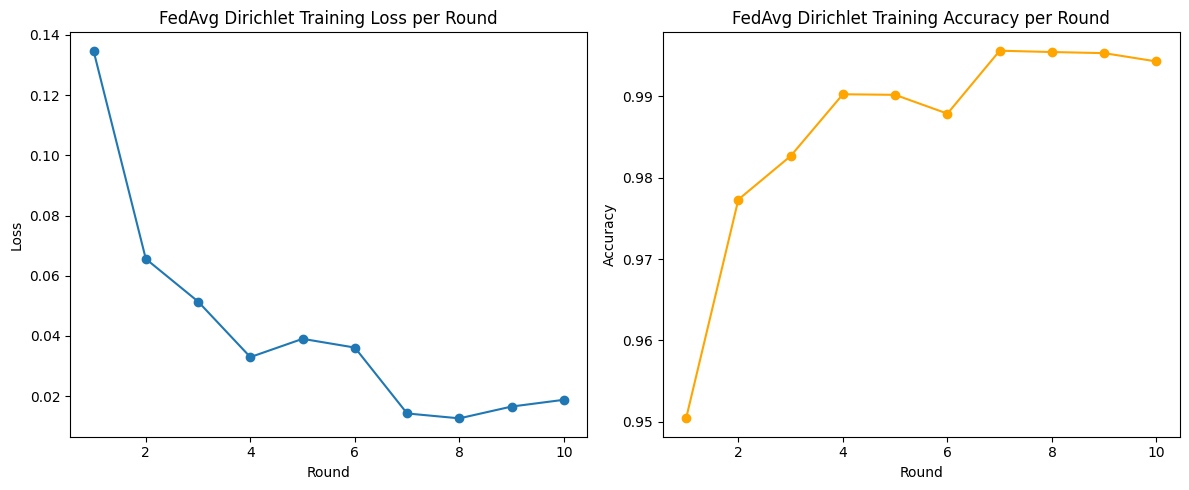

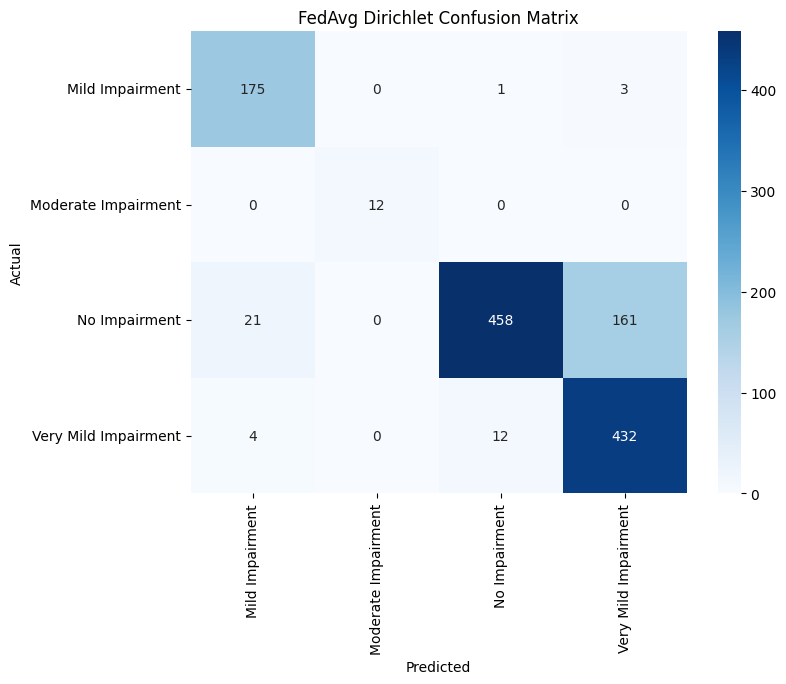

FedAvg Dirichlet Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.88      0.98      0.92       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.97      0.72      0.82       640
Very Mild Impairment       0.72      0.96      0.83       448

            accuracy                           0.84      1279
           macro avg       0.89      0.91      0.89      1279
        weighted avg       0.87      0.84      0.84      1279



In [ ]:
# Scenario 2: FedAvg with Non-IID Dirichlet

!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from numpy.random import dirichlet

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3
alpha = 0.5

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=0.5):
    client_data = [[] for _ in range(num_clients)]
    client_labels = [[] for _ in range(num_clients)]

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    for cls_idx in range(len(classes)):
        cls_inds = class_indices[cls_idx]
        np.random.shuffle(cls_inds)
        n = len(cls_inds)
        proportions = dirichlet([alpha]*num_clients)
        counts = (proportions * n).astype(int)
        diff = n - np.sum(counts)
        if diff > 0:
            counts[np.argmax(counts)] += diff

        start = 0
        for c in range(num_clients):
            c_count = counts[c]
            c_inds = cls_inds[start:start+c_count]
            start += c_count
            client_data[c].append(X[c_inds])
            client_labels[c].append(y[c_inds])

    final_clients = []
    for c in range(num_clients):
        X_c = np.concatenate(client_data[c])
        y_c = np.concatenate(client_labels[c])
        inds = np.arange(len(X_c))
        np.random.shuffle(inds)
        X_c = X_c[inds]
        y_c = y_c[inds]
        final_clients.append((X_c, y_c))
    return final_clients

client_data = create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=alpha)

global_model = create_model()
global_weights = global_model.get_weights()

fedavg_train_loss = []
fedavg_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedAvg Dirichlet - Round {round_num+1}/{num_rounds}")
    local_weights = []
    local_losses = []
    local_accuracies = []

    for client_num, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_num+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)
        client_model.compile(optimizer=client_optimizer,
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        local_weights.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    new_weights = []
    for weights_set in zip(*local_weights):
        new_weights.append(np.mean(weights_set, axis=0))
    global_weights = new_weights
    global_model.set_weights(global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedavg_train_loss.append(avg_loss)
    fedavg_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedAvg Dirichlet Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedavg_train_loss, fedavg_train_accuracy, "FedAvg Dirichlet")
plot_confusion_matrix(global_model, test_generator, classes, "FedAvg Dirichlet")


FedAvg IID with Byzantine client

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 85% 61.0M/71.5M [00:00<00:00, 129MB/s]
100% 71.5M/71.5M [00:00<00:00, 118MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
FedAvg IID + Byzantine - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1853, Average Training Accuracy: 0.9329
FedAvg IID + Byzantine - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 1.3550, Average Training Accuracy

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedAvg IID + Byzantine Test Accuracy: 35.03%


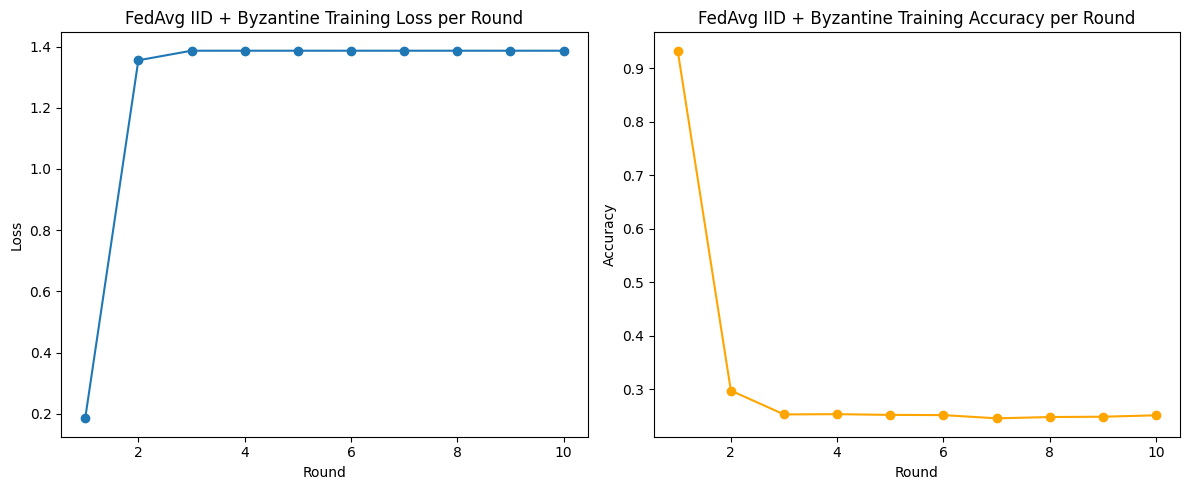

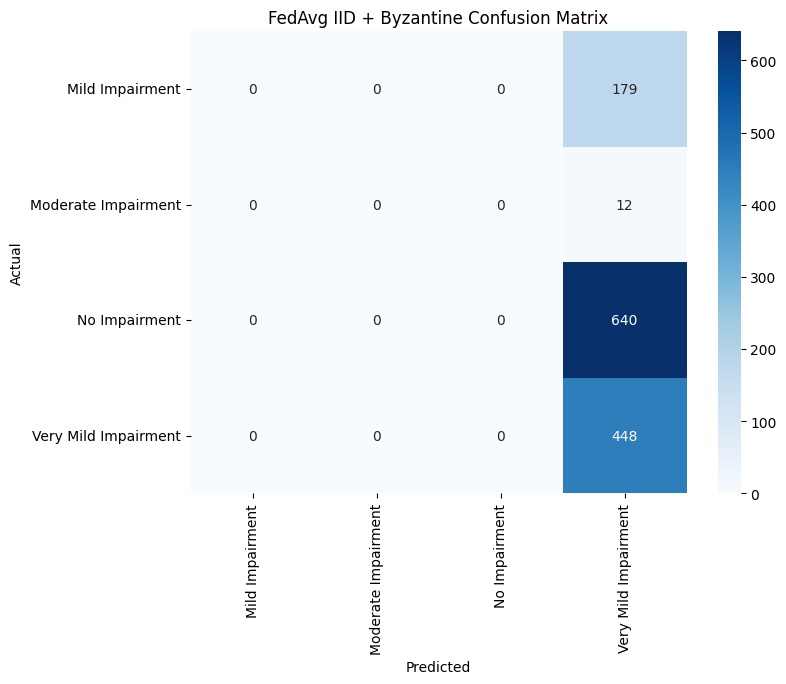

FedAvg IID + Byzantine Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.00      0.00      0.00       179
 Moderate Impairment       0.00      0.00      0.00        12
       No Impairment       0.00      0.00      0.00       640
Very Mild Impairment       0.35      1.00      0.52       448

            accuracy                           0.35      1279
           macro avg       0.09      0.25      0.13      1279
        weighted avg       0.12      0.35      0.18      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Scenario: FedAvg IID with Byzantine client (Simplified Attack)

!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

np.random.seed(42)  # For reproducibility

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_iid_data(X, y, num_clients):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    split_X = np.array_split(X, num_clients)
    split_y = np.array_split(y, num_clients)
    client_data = []
    for i in range(num_clients):
        client_data.append((split_X[i], split_y[i]))
    return client_data

def apply_byzantine_attack(local_weights):
    # Instead of noise, just negate all weights:
    sabotaged = []
    for w in local_weights:
        sabotaged.append(-w)
    return sabotaged

client_data = create_iid_data(X, y, num_clients)

global_model = create_model()
global_weights = global_model.get_weights()

fedavg_train_loss = []
fedavg_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedAvg IID + Byzantine - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    for client_num, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_num+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)
        client_model.compile(optimizer=client_optimizer,
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

        # If this is the last client (Byzantine)
        if client_num == num_clients - 1:
            w_local = apply_byzantine_attack(w_local)

        local_weights_list.append(w_local)

    new_weights = []
    for weights_set in zip(*local_weights_list):
        avg_w = np.mean(weights_set, axis=0)
        new_weights.append(avg_w)

    global_weights = new_weights

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedavg_train_loss.append(avg_loss)
    fedavg_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedAvg IID + Byzantine Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedavg_train_loss, fedavg_train_accuracy, "FedAvg IID + Byzantine")
plot_confusion_matrix(global_model, test_generator, classes, "FedAvg IID + Byzantine")


# *FEDPROX* (NONIID)

# FedProx Non-IID (Label Skew)

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 98% 70.0M/71.5M [00:04<00:00, 21.6MB/s]
100% 71.5M/71.5M [00:05<00:00, 14.9MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FedProx Label Skew - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.4278, Average Training Accuracy: 0.9193
FedProx Label Skew - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.3044, Average Training Accuracy: 0.95

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedProx Label Skew Test Accuracy: 92.81%


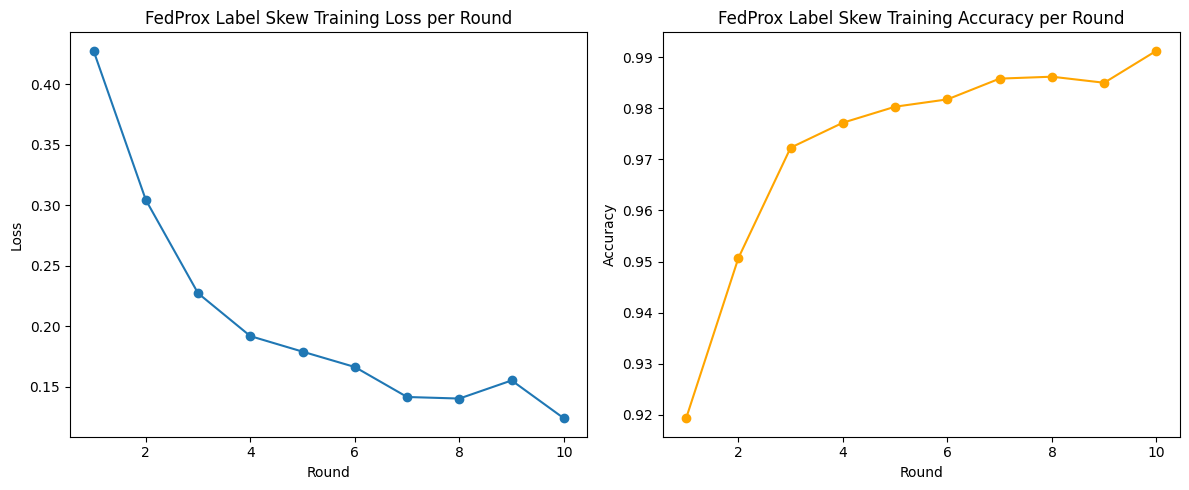

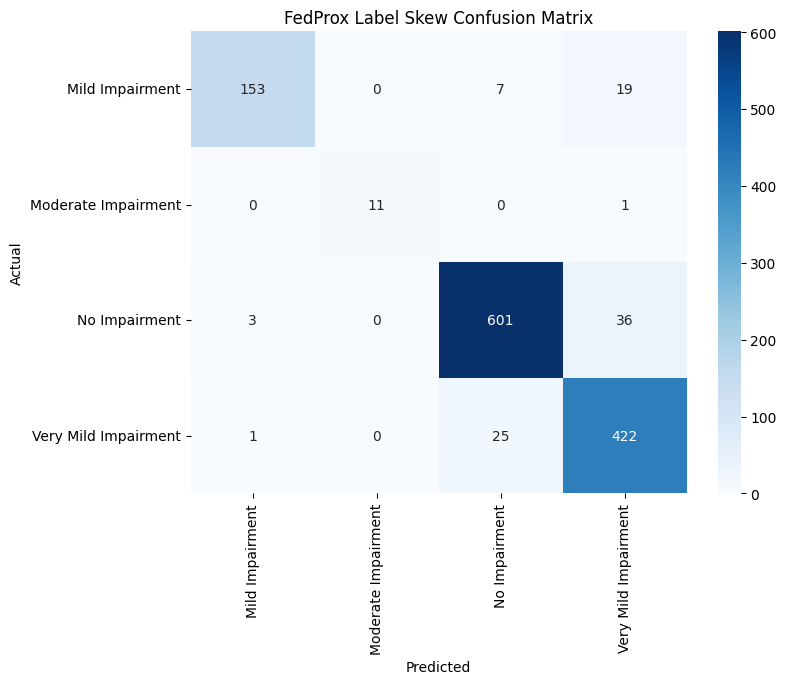

FedProx Label Skew Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.97      0.85      0.91       179
 Moderate Impairment       1.00      0.92      0.96        12
       No Impairment       0.95      0.94      0.94       640
Very Mild Impairment       0.88      0.94      0.91       448

            accuracy                           0.93      1279
           macro avg       0.95      0.91      0.93      1279
        weighted avg       0.93      0.93      0.93      1279



In [ ]:
# FedProx Non-IID (Label Skew)

!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3
mu = 0.01  # FedProx coefficient

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_label_skew_data(X, y, classes, num_clients):
    c_mild = classes.index("Mild Impairment")
    c_mod = classes.index("Moderate Impairment")
    c_no = classes.index("No Impairment")
    c_very = classes.index("Very Mild Impairment")

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    def choose_frac(cls_ind, frac):
        count = int(len(cls_ind)*frac)
        chosen = np.random.choice(cls_ind, count, replace=False)
        remain = np.setdiff1d(cls_ind, chosen)
        return chosen, remain

    # Client 1:
    mild_chosen, class_indices[c_mild] = choose_frac(class_indices[c_mild], 0.7)
    others1 = np.concatenate([class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    others1_count = int(len(others1)*0.3) if len(others1)>0 else 0
    if others1_count>0:
        others1_chosen = np.random.choice(others1, others1_count, replace=False)
        for cc in [c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], others1_chosen[np.isin(others1_chosen, class_indices[cc])])
    else:
        others1_chosen = np.array([], dtype=int)
    client1_indices = np.concatenate([mild_chosen, others1_chosen])

    # Client 2:
    no_ = class_indices[c_no]
    mod_ = class_indices[c_mod]
    no_count = int(len(no_)*0.35) if len(no_)>0 else 0
    mod_count = int(len(mod_)*0.35) if len(mod_)>0 else 0
    no_chosen = np.random.choice(no_, no_count, replace=False) if no_count>0 else np.array([], dtype=int)
    mod_chosen = np.random.choice(mod_, mod_count, replace=False) if mod_count>0 else np.array([], dtype=int)
    class_indices[c_no] = np.setdiff1d(class_indices[c_no], no_chosen)
    class_indices[c_mod] = np.setdiff1d(class_indices[c_mod], mod_chosen)

    rem2 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem2_count = int(len(rem2)*0.3) if len(rem2)>0 else 0
    if rem2_count>0:
        rem2_chosen = np.random.choice(rem2, rem2_count, replace=False)
        for cc in [c_mild, c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], rem2_chosen[np.isin(rem2_chosen, class_indices[cc])])
    else:
        rem2_chosen = np.array([], dtype=int)
    client2_indices = np.concatenate([no_chosen, mod_chosen, rem2_chosen])

    # Client 3:
    very_ = class_indices[c_very]
    v_count = int(len(very_)*0.7) if len(very_)>0 else 0
    v_chosen = np.random.choice(very_, v_count, replace=False) if v_count>0 else np.array([], dtype=int)
    class_indices[c_very] = np.setdiff1d(class_indices[c_very], v_chosen)

    rem3 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem3_count = int(len(rem3)*0.3) if len(rem3)>0 else 0
    if rem3_count > len(rem3):
        rem3_count = len(rem3)
    rem3_chosen = np.random.choice(rem3, rem3_count, replace=False) if rem3_count>0 else np.array([], dtype=int)

    client3_indices = np.concatenate([v_chosen, rem3_chosen])

    for arr in [client1_indices, client2_indices, client3_indices]:
        np.random.shuffle(arr)

    return [(X[client1_indices], y[client1_indices]),
            (X[client2_indices], y[client2_indices]),
            (X[client3_indices], y[client3_indices])]

client_data = create_label_skew_data(X, y, classes, num_clients)

global_model = create_model()
global_weights = global_model.get_weights()

fedprox_train_loss = []
fedprox_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedProx Label Skew - Round {round_num+1}/{num_rounds}")
    local_weights = []
    local_losses = []
    local_accuracies = []

    global_model.set_weights(global_weights)
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    for client_num, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_num+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)

        def prox_loss(y_true, y_pred):
            ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
            prox_term = 0.0
            for w_local, w_global_t in zip(client_model.trainable_variables, global_weights_tensor):
                prox_term += tf.reduce_sum(tf.square(w_local - w_global_t))
            prox_term = (mu / 2.0) * prox_term
            return ce_loss + prox_term

        client_model.compile(optimizer=client_optimizer,
                             loss=prox_loss,
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        local_weights.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    new_weights = []
    for weights_set in zip(*local_weights):
        new_weights.append(np.mean(weights_set, axis=0))
    global_weights = new_weights

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedprox_train_loss.append(avg_loss)
    fedprox_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedProx Label Skew Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedprox_train_loss, fedprox_train_accuracy, "FedProx Label Skew")
plot_confusion_matrix(global_model, test_generator, classes, "FedProx Label Skew")


# FedProx Non-IID (Dirichlet)

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 99% 71.0M/71.5M [00:04<00:00, 23.3MB/s]
100% 71.5M/71.5M [00:04<00:00, 17.7MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FedProx Dirichlet - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.3638, Average Training Accuracy: 0.9438
FedProx Dirichlet - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.2837, Average Training Accuracy: 0.9618

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedProx Dirichlet Test Accuracy: 89.37%


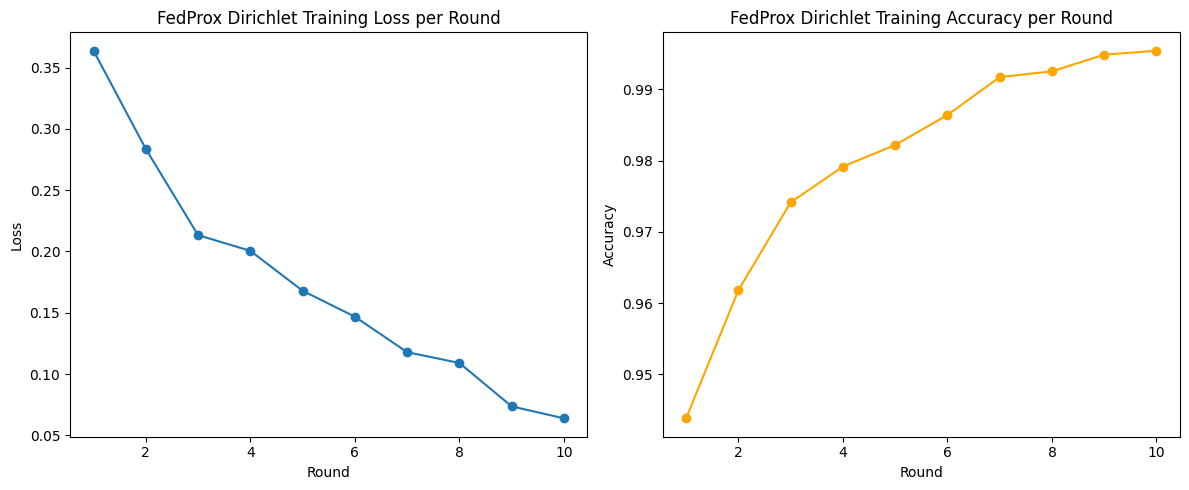

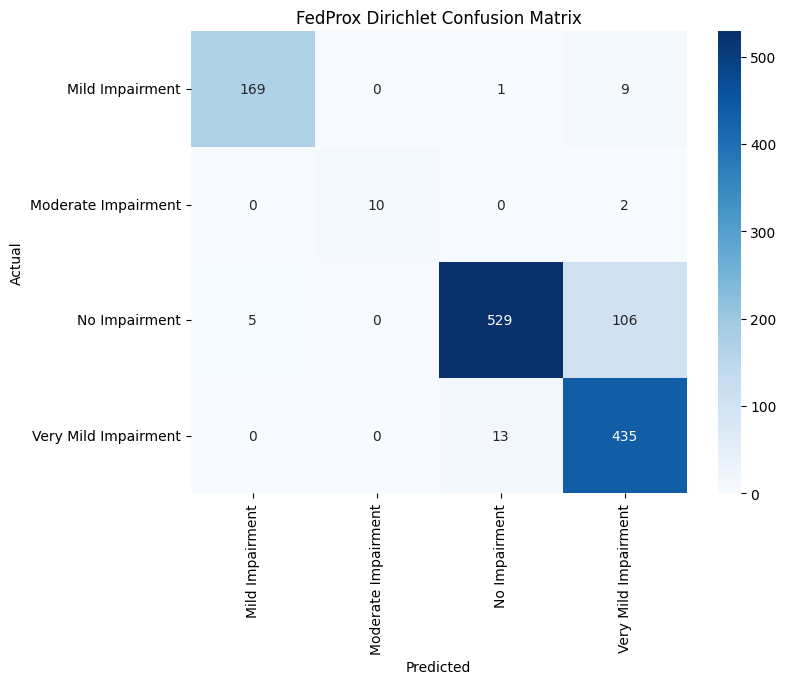

FedProx Dirichlet Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.97      0.94      0.96       179
 Moderate Impairment       1.00      0.83      0.91        12
       No Impairment       0.97      0.83      0.89       640
Very Mild Impairment       0.79      0.97      0.87       448

            accuracy                           0.89      1279
           macro avg       0.93      0.89      0.91      1279
        weighted avg       0.91      0.89      0.89      1279



In [ ]:
# FedProx Non-IID (Dirichlet)

!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from numpy.random import dirichlet

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3
mu = 0.01
alpha = 0.5

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=0.5):
    client_data = [[] for _ in range(num_clients)]
    client_labels = [[] for _ in range(num_clients)]

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    for cls_idx in range(len(classes)):
        cls_inds = class_indices[cls_idx]
        np.random.shuffle(cls_inds)
        n = len(cls_inds)
        proportions = dirichlet([alpha]*num_clients)
        counts = (proportions * n).astype(int)
        diff = n - np.sum(counts)
        if diff > 0:
            counts[np.argmax(counts)] += diff

        start = 0
        for c in range(num_clients):
            c_count = counts[c]
            c_inds = cls_inds[start:start+c_count]
            start += c_count
            client_data[c].append(X[c_inds])
            client_labels[c].append(y[c_inds])

    final_clients = []
    for c in range(num_clients):
        X_c = np.concatenate(client_data[c])
        y_c = np.concatenate(client_labels[c])
        inds = np.arange(len(X_c))
        np.random.shuffle(inds)
        X_c = X_c[inds]
        y_c = y_c[inds]
        final_clients.append((X_c, y_c))
    return final_clients

client_data = create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=alpha)

global_model = create_model()
global_weights = global_model.get_weights()

fedprox_train_loss = []
fedprox_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedProx Dirichlet - Round {round_num+1}/{num_rounds}")
    local_weights = []
    local_losses = []
    local_accuracies = []

    global_model.set_weights(global_weights)
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    for client_num, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_num+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)

        def prox_loss(y_true, y_pred):
            ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
            prox_term = 0.0
            for w_local, w_global_t in zip(client_model.trainable_variables, global_weights_tensor):
                prox_term += tf.reduce_sum(tf.square(w_local - w_global_t))
            prox_term = (mu / 2.0) * prox_term
            return ce_loss + prox_term

        client_model.compile(optimizer=client_optimizer,
                             loss=prox_loss,
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        local_weights.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    new_weights = []
    for weights_set in zip(*local_weights):
        new_weights.append(np.mean(weights_set, axis=0))
    global_weights = new_weights

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedprox_train_loss.append(avg_loss)
    fedprox_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedProx Dirichlet Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedprox_train_loss, fedprox_train_accuracy, "FedProx Dirichlet")
plot_confusion_matrix(global_model, test_generator, classes, "FedProx Dirichlet")


# FedProx Under Byzantine Attack

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 87% 62.0M/71.5M [00:00<00:00, 100MB/s]
100% 71.5M/71.5M [00:00<00:00, 109MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
FedProx IID + Byzantine - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.4812, Average Training Accuracy: 0.9114
FedProx IID + Byzantine - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 1.3826, Average Training Accura

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedProx IID + Byzantine Test Accuracy: 35.03%


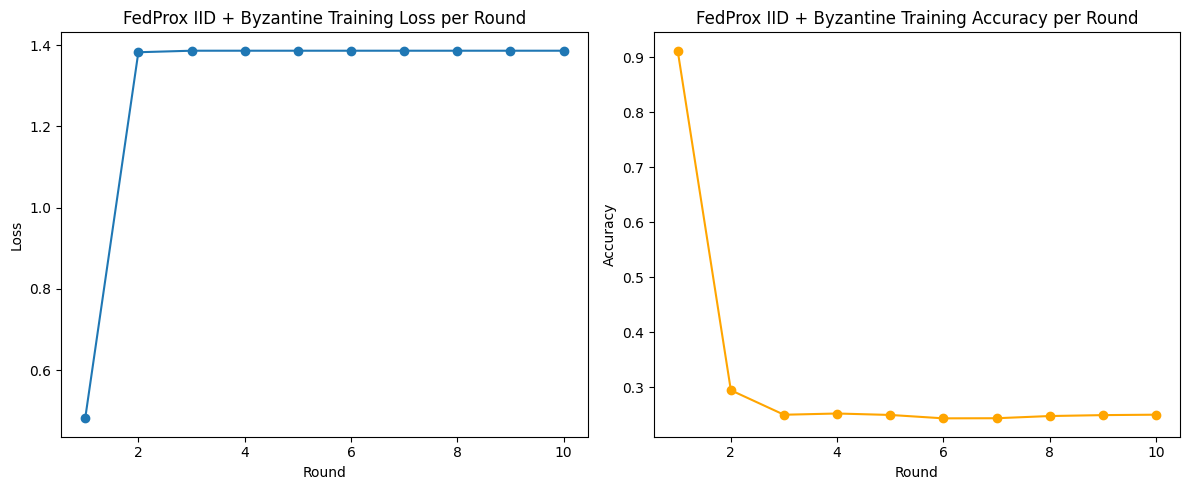

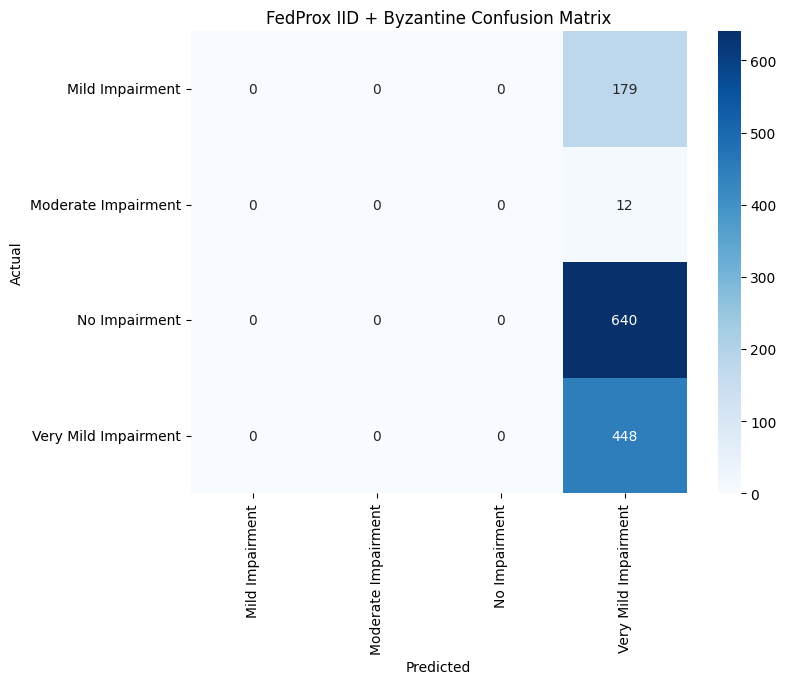

FedProx IID + Byzantine Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.00      0.00      0.00       179
 Moderate Impairment       0.00      0.00      0.00        12
       No Impairment       0.00      0.00      0.00       640
Very Mild Impairment       0.35      1.00      0.52       448

            accuracy                           0.35      1279
           macro avg       0.09      0.25      0.13      1279
        weighted avg       0.12      0.35      0.18      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# FedProx Under Byzantine Attack

!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

np.random.seed(42)

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3
mu = 0.01

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_iid_data(X, y, num_clients):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    split_X = np.array_split(X, num_clients)
    split_y = np.array_split(y, num_clients)
    client_data = []
    for i in range(num_clients):
        client_data.append((split_X[i], split_y[i]))
    return client_data

def apply_byzantine_attack(local_weights):
    # Simple attack: negate all weights
    sabotaged = []
    for w in local_weights:
        sabotaged.append(-w)
    return sabotaged

client_data = create_iid_data(X, y, num_clients)

global_model = create_model()
global_weights = global_model.get_weights()

fedprox_train_loss = []
fedprox_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedProx IID + Byzantine - Round {round_num+1}/{num_rounds}")
    local_weights = []
    local_losses = []
    local_accuracies = []

    global_model.set_weights(global_weights)
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    for client_num, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_num+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)

        def prox_loss(y_true, y_pred):
            ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
            prox_term = 0.0
            for w_local, w_global_t in zip(client_model.trainable_variables, global_weights_tensor):
                prox_term += tf.reduce_sum(tf.square(w_local - w_global_t))
            prox_term = (mu / 2.0) * prox_term
            return ce_loss + prox_term

        client_model.compile(optimizer=client_optimizer,
                             loss=prox_loss,
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

        # Byzantine client is the last client
        if client_num == num_clients - 1:
            w_local = apply_byzantine_attack(w_local)

        local_weights.append(w_local)

    new_weights = []
    for weights_set in zip(*local_weights):
        new_weights.append(np.mean(weights_set, axis=0))
    global_weights = new_weights

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedprox_train_loss.append(avg_loss)
    fedprox_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedProx IID + Byzantine Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedprox_train_loss, fedprox_train_accuracy, "FedProx IID + Byzantine")
plot_confusion_matrix(global_model, test_generator, classes, "FedProx IID + Byzantine")


# FedADMM (NON-IID)

# FedADMM Non-IID (Label Skew)

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 99% 71.0M/71.5M [00:04<00:00, 26.4MB/s]
100% 71.5M/71.5M [00:04<00:00, 17.5MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
FedADMM Label Skew - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 1.2281, Average Training Accuracy: 0.7723
FedADMM Label Skew - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.9889, Average Training Accuracy: 0.79

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedADMM Label Skew Test Accuracy: 74.04%


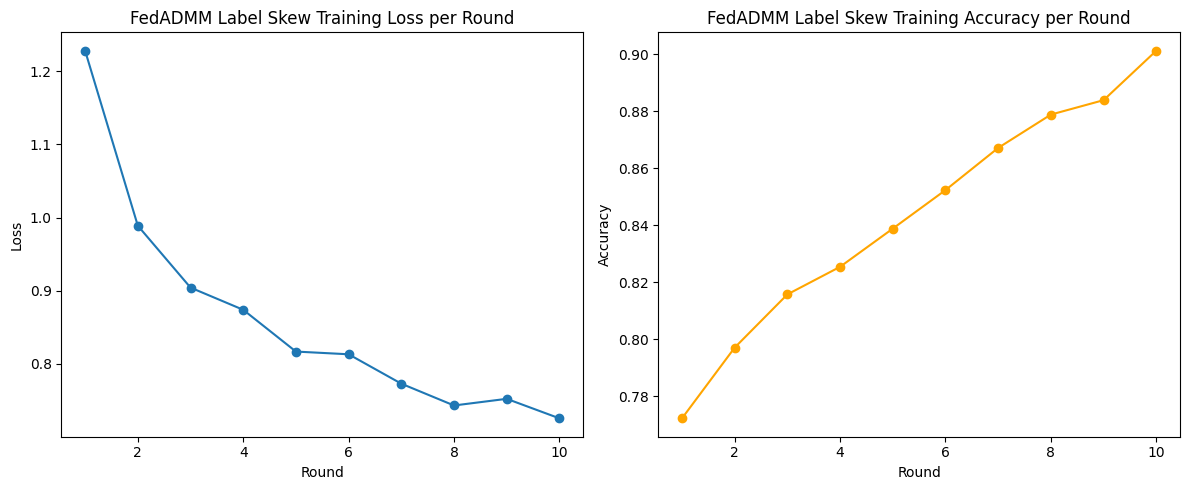

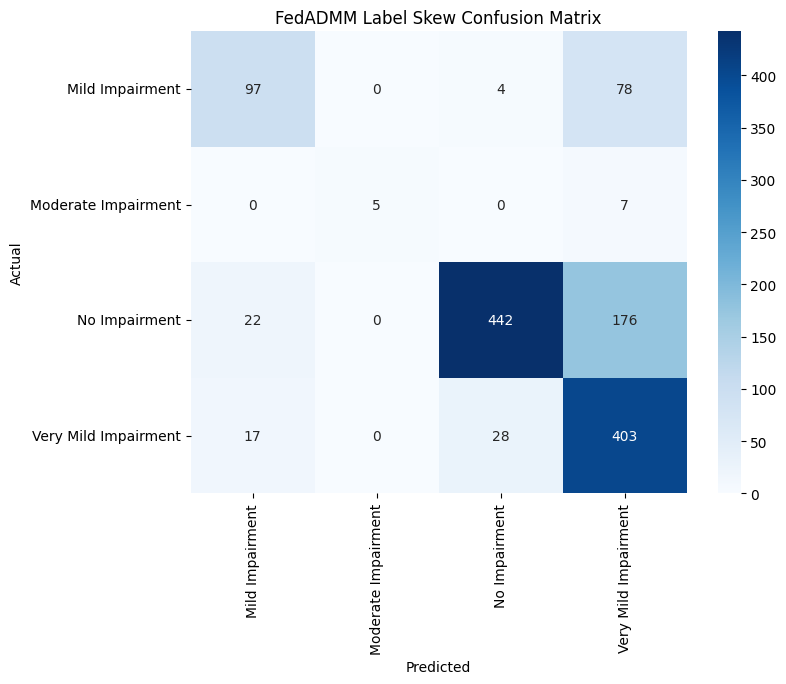

FedADMM Label Skew Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.71      0.54      0.62       179
 Moderate Impairment       1.00      0.42      0.59        12
       No Impairment       0.93      0.69      0.79       640
Very Mild Impairment       0.61      0.90      0.72       448

            accuracy                           0.74      1279
           macro avg       0.81      0.64      0.68      1279
        weighted avg       0.79      0.74      0.74      1279



In [ ]:
# FedADMM Non-IID (Label Skew)

!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

np.random.seed(42)

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3
rho = 0.5  # ADMM penalty parameter

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_label_skew_data(X, y, classes, num_clients):
    c_mild = classes.index("Mild Impairment")
    c_mod = classes.index("Moderate Impairment")
    c_no = classes.index("No Impairment")
    c_very = classes.index("Very Mild Impairment")

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    def choose_frac(cls_ind, frac):
        count = int(len(cls_ind)*frac)
        chosen = np.random.choice(cls_ind, count, replace=False)
        remain = np.setdiff1d(cls_ind, chosen)
        return chosen, remain

    # Client 1:
    mild_chosen, class_indices[c_mild] = choose_frac(class_indices[c_mild], 0.7)
    others1 = np.concatenate([class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    others1_count = int(len(others1)*0.3) if len(others1)>0 else 0
    if others1_count>0:
        others1_chosen = np.random.choice(others1, others1_count, replace=False)
        for cc in [c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], others1_chosen[np.isin(others1_chosen, class_indices[cc])])
    else:
        others1_chosen = np.array([], dtype=int)
    client1_indices = np.concatenate([mild_chosen, others1_chosen])

    # Client 2:
    no_ = class_indices[c_no]
    mod_ = class_indices[c_mod]
    no_count = int(len(no_)*0.35) if len(no_)>0 else 0
    mod_count = int(len(mod_)*0.35) if len(mod_)>0 else 0
    no_chosen = np.random.choice(no_, no_count, replace=False) if no_count>0 else np.array([], dtype=int)
    mod_chosen = np.random.choice(mod_, mod_count, replace=False) if mod_count>0 else np.array([], dtype=int)
    class_indices[c_no] = np.setdiff1d(class_indices[c_no], no_chosen)
    class_indices[c_mod] = np.setdiff1d(class_indices[c_mod], mod_chosen)

    rem2 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem2_count = int(len(rem2)*0.3) if len(rem2)>0 else 0
    if rem2_count>0:
        rem2_chosen = np.random.choice(rem2, rem2_count, replace=False)
        for cc in [c_mild, c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], rem2_chosen[np.isin(rem2_chosen, class_indices[cc])])
    else:
        rem2_chosen = np.array([], dtype=int)
    client2_indices = np.concatenate([no_chosen, mod_chosen, rem2_chosen])

    # Client 3:
    very_ = class_indices[c_very]
    v_count = int(len(very_)*0.7) if len(very_)>0 else 0
    v_chosen = np.random.choice(very_, v_count, replace=False) if v_count>0 else np.array([], dtype=int)
    class_indices[c_very] = np.setdiff1d(class_indices[c_very], v_chosen)

    rem3 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem3_count = int(len(rem3)*0.3) if len(rem3)>0 else 0
    if rem3_count > len(rem3):
        rem3_count = len(rem3)
    rem3_chosen = np.random.choice(rem3, rem3_count, replace=False) if rem3_count>0 else np.array([], dtype=int)

    client3_indices = np.concatenate([v_chosen, rem3_chosen])

    for arr in [client1_indices, client2_indices, client3_indices]:
        np.random.shuffle(arr)

    return [(X[client1_indices], y[client1_indices]),
            (X[client2_indices], y[client2_indices]),
            (X[client3_indices], y[client3_indices])]

client_data = create_label_skew_data(X, y, classes, num_clients)

global_model = create_model()
global_weights = global_model.get_weights()

# Initialize λ for each client
lambda_clients = []
global_model.set_weights(global_weights)
for _ in range(num_clients):
    lam = []
    for w in global_model.trainable_variables:
        lam.append(np.zeros_like(w.numpy()))
    lambda_clients.append(lam)

fedadmm_train_loss = []
fedadmm_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedADMM Label Skew - Round {round_num+1}/{num_rounds}")

    local_weights = []
    local_losses = []
    local_accuracies = []

    global_model.set_weights(global_weights)
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)

        def admm_loss(y_true, y_pred):
            ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
            penalty = 0.0
            for w_local, w_global_t, lam in zip(client_model.trainable_variables, global_weights_tensor, lambda_clients[client_idx]):
                diff = w_local - w_global_t + (1.0/rho)*tf.convert_to_tensor(lam, dtype=w_local.dtype)
                penalty += tf.reduce_sum(tf.square(diff))
            return ce_loss + (rho/2)*penalty

        client_model.compile(optimizer=client_optimizer,
                             loss=admm_loss,
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()

        local_weights.append(w_local)
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    # Average local weights
    new_weights = []
    for weights_set in zip(*local_weights):
        new_weights.append(np.mean(weights_set, axis=0))
    global_weights = new_weights

    # Update λ
    global_model.set_weights(global_weights)
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    for client_idx, w_local in enumerate(local_weights):
        client_model = create_model()
        client_model.set_weights(w_local)
        client_trainable = client_model.trainable_variables

        for i in range(len(client_trainable)):
            lam_np = lambda_clients[client_idx][i]
            w_local_np = client_trainable[i].numpy()
            w_global_np = global_weights_tensor[i].numpy()
            lam_np = lam_np + rho*(w_local_np - w_global_np)
            lambda_clients[client_idx][i] = lam_np

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedadmm_train_loss.append(avg_loss)
    fedadmm_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedADMM Label Skew Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedadmm_train_loss, fedadmm_train_accuracy, "FedADMM Label Skew")
plot_confusion_matrix(global_model, test_generator, classes, "FedADMM Label Skew")


 FedADMM Non-IID (Dirichlet)

Please upload your kaggle.json file (Kaggle API token).


Saving config.json to config.json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 91% 65.0M/71.5M [00:00<00:00, 98.6MB/s]
100% 71.5M/71.5M [00:00<00:00, 95.6MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
FedADMM Dirichlet - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 1.1739, Average Training Accuracy: 0.7928

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedADMM Dirichlet Test Accuracy: 69.98%


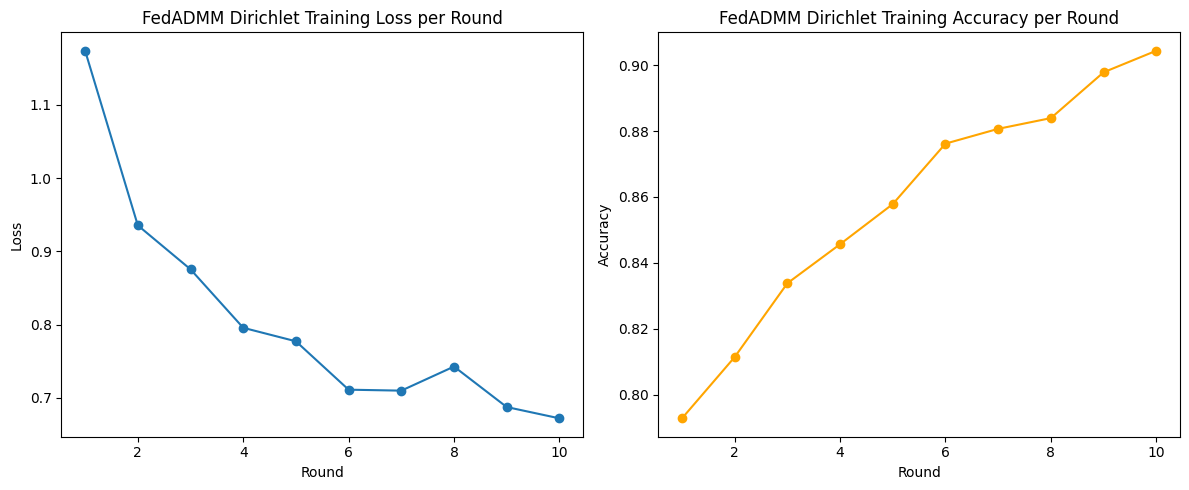

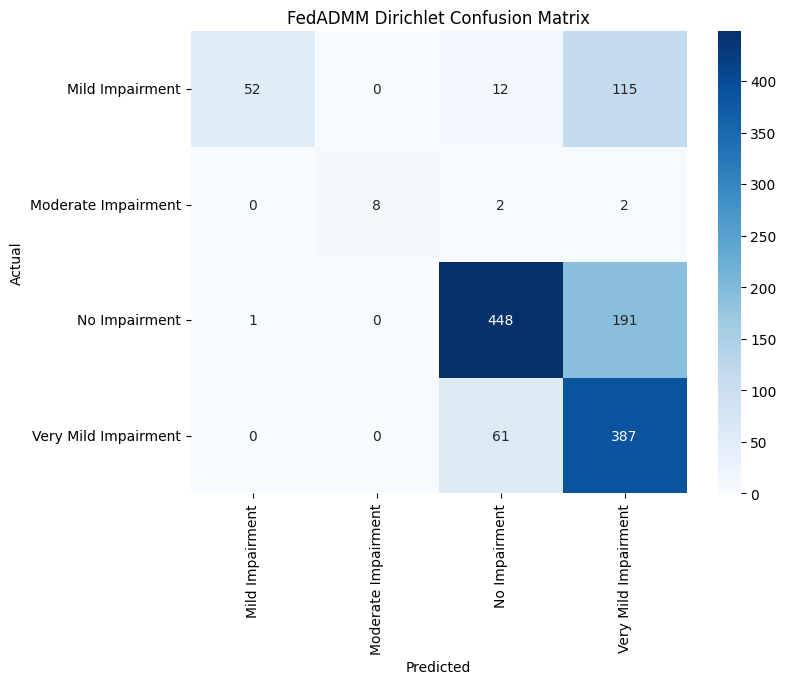

FedADMM Dirichlet Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.98      0.29      0.45       179
 Moderate Impairment       1.00      0.67      0.80        12
       No Impairment       0.86      0.70      0.77       640
Very Mild Impairment       0.56      0.86      0.68       448

            accuracy                           0.70      1279
           macro avg       0.85      0.63      0.67      1279
        weighted avg       0.77      0.70      0.69      1279



In [ ]:
# FedADMM Non-IID (Dirichlet)

!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import gc
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from numpy.random import dirichlet

np.random.seed(42)

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3
rho = 0.5
alpha = 0.5

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=0.5):
    client_data = [[] for _ in range(num_clients)]
    client_labels = [[] for _ in range(num_clients)]

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    for cls_idx in range(len(classes)):
        cls_inds = class_indices[cls_idx]
        np.random.shuffle(cls_inds)
        n = len(cls_inds)
        proportions = dirichlet([alpha]*num_clients)
        counts = (proportions * n).astype(int)
        diff = n - np.sum(counts)
        if diff > 0:
            counts[np.argmax(counts)] += diff

        start = 0
        for c in range(num_clients):
            c_count = counts[c]
            c_inds = cls_inds[start:start+c_count]
            start += c_count
            client_data[c].append(X[c_inds])
            client_labels[c].append(y[c_inds])

    final_clients = []
    for c in range(num_clients):
        X_c = np.concatenate(client_data[c])
        y_c = np.concatenate(client_labels[c])
        inds = np.arange(len(X_c))
        np.random.shuffle(inds)
        X_c = X_c[inds]
        y_c = y_c[inds]
        final_clients.append((X_c, y_c))
    return final_clients

client_data = create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=alpha)

global_model = create_model()
global_weights = global_model.get_weights()

# Initialize λ for each client
lambda_clients = []
global_model.set_weights(global_weights)
for _ in range(num_clients):
    lam = []
    for w in global_model.trainable_variables:
        lam.append(np.zeros_like(w.numpy()))
    lambda_clients.append(lam)

fedadmm_train_loss = []
fedadmm_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedADMM Dirichlet - Round {round_num+1}/{num_rounds}")

    local_weights = []
    local_losses = []
    local_accuracies = []

    global_model.set_weights(global_weights)
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)

        def admm_loss(y_true, y_pred):
            ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
            penalty = 0.0
            for w_local, w_global_t, lam in zip(client_model.trainable_variables, global_weights_tensor, lambda_clients[client_idx]):
                diff = w_local - w_global_t + (1.0/rho)*tf.convert_to_tensor(lam, dtype=w_local.dtype)
                penalty += tf.reduce_sum(tf.square(diff))
            return ce_loss + (rho/2)*penalty

        client_model.compile(optimizer=client_optimizer,
                             loss=admm_loss,
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()

        local_weights.append(w_local)
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

        # Clear session and collect garbage after each client
        tf.keras.backend.clear_session()
        gc.collect()

    # Average local weights
    new_weights = []
    for weights_set in zip(*local_weights):
        new_weights.append(np.mean(weights_set, axis=0))
    global_weights = new_weights

    # Update λ
    global_model.set_weights(global_weights)
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    for client_idx, w_local in enumerate(local_weights):
        client_model = create_model()
        client_model.set_weights(w_local)
        client_trainable = client_model.trainable_variables

        for i in range(len(client_trainable)):
            lam_np = lambda_clients[client_idx][i]
            w_local_np = client_trainable[i].numpy()
            w_global_np = global_weights_tensor[i].numpy()
            lam_np = lam_np + rho*(w_local_np - w_global_np)
            lambda_clients[client_idx][i] = lam_np

        # Clear session after updating lam
        tf.keras.backend.clear_session()
        gc.collect()

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedadmm_train_loss.append(avg_loss)
    fedadmm_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedADMM Dirichlet Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedadmm_train_loss, fedadmm_train_accuracy, "FedADMM Dirichlet")
plot_confusion_matrix(global_model, test_generator, classes, "FedADMM Dirichlet")


Byzantine ADMM

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
100% 71.5M/71.5M [00:04<00:00, 23.8MB/s]
100% 71.5M/71.5M [00:04<00:00, 17.0MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FedADMM IID + Byzantine - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 1.3568, Average Training Accuracy: 0.7226
FedADMM IID + Byzantine - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 4201.7146, Average Training A

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedADMM IID + Byzantine Test Accuracy: 35.03%


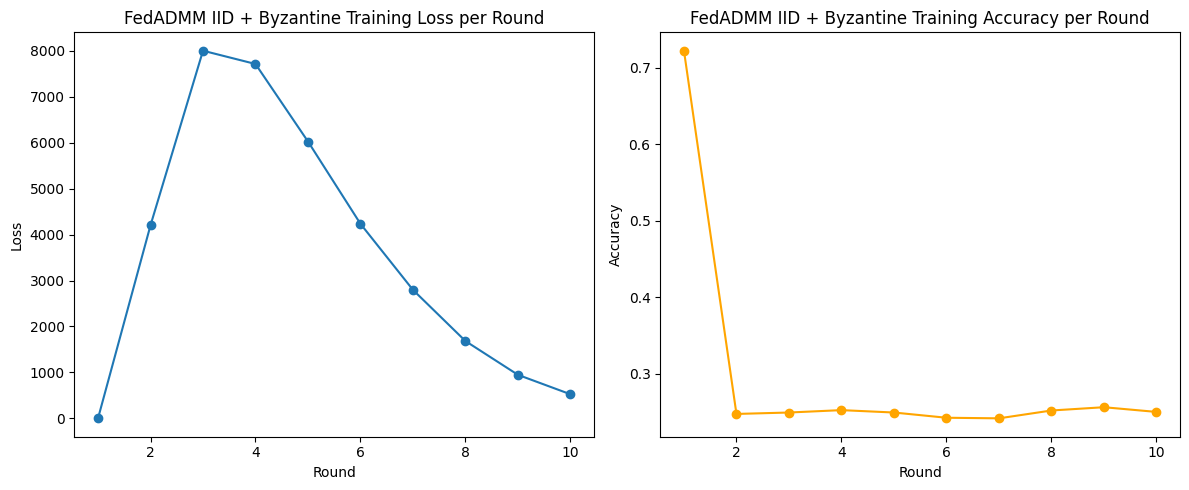

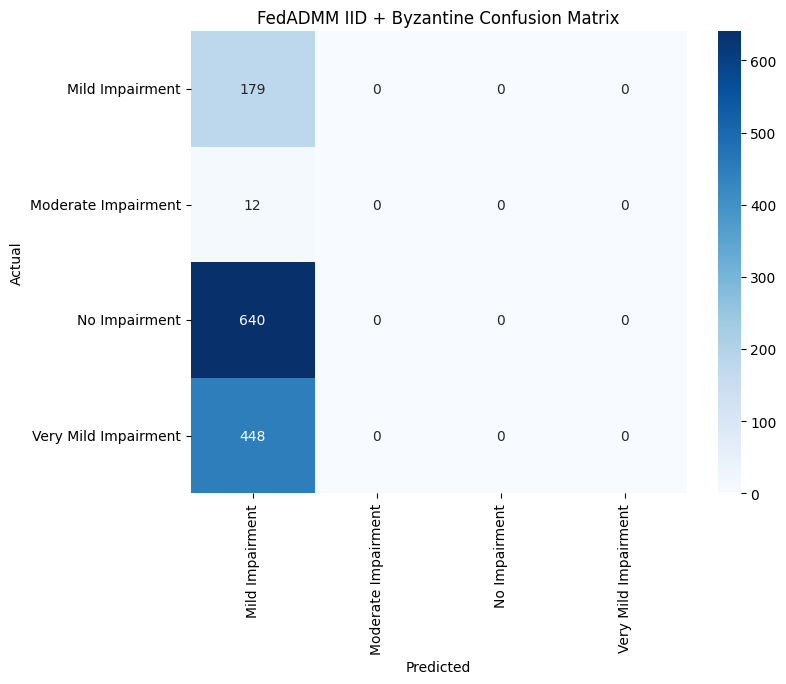

FedADMM IID + Byzantine Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.14      1.00      0.25       179
 Moderate Impairment       0.00      0.00      0.00        12
       No Impairment       0.00      0.00      0.00       640
Very Mild Impairment       0.00      0.00      0.00       448

            accuracy                           0.14      1279
           macro avg       0.03      0.25      0.06      1279
        weighted avg       0.02      0.14      0.03      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# FedADMM IID + Byzantine

!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

np.random.seed(42)

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3
rho = 0.5

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_iid_data(X, y, num_clients):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    split_X = np.array_split(X, num_clients)
    split_y = np.array_split(y, num_clients)
    client_data = []
    for i in range(num_clients):
        client_data.append((split_X[i], split_y[i]))
    return client_data

def apply_byzantine_attack(local_weights):
    # simple attack: negate all weights
    sabotaged = []
    for w in local_weights:
        sabotaged.append(-w)
    return sabotaged

client_data = create_iid_data(X, y, num_clients)

global_model = create_model()
global_weights = global_model.get_weights()

# Initialize λ for each client
lambda_clients = []
global_model.set_weights(global_weights)
for _ in range(num_clients):
    lam = []
    for w in global_model.trainable_variables:
        lam.append(np.zeros_like(w.numpy()))
    lambda_clients.append(lam)

fedadmm_train_loss = []
fedadmm_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedADMM IID + Byzantine - Round {round_num+1}/{num_rounds}")

    local_weights = []
    local_losses = []
    local_accuracies = []

    global_model.set_weights(global_weights)
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)

        def admm_loss(y_true, y_pred):
            ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
            penalty = 0.0
            for w_local, w_global_t, lam in zip(client_model.trainable_variables, global_weights_tensor, lambda_clients[client_idx]):
                diff = w_local - w_global_t + (1.0/rho)*tf.convert_to_tensor(lam, dtype=w_local.dtype)
                penalty += tf.reduce_sum(tf.square(diff))
            return ce_loss + (rho/2)*penalty

        client_model.compile(optimizer=client_optimizer,
                             loss=admm_loss,
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

        # Byzantine attack on last client
        if client_idx == num_clients - 1:
            w_local = apply_byzantine_attack(w_local)

        local_weights.append(w_local)

    # Average local weights
    new_weights = []
    for weights_set in zip(*local_weights):
        new_weights.append(np.mean(weights_set, axis=0))
    global_weights = new_weights

    # Update λ
    global_model.set_weights(global_weights)
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    for client_idx, w_local in enumerate(local_weights):
        client_model = create_model()
        client_model.set_weights(w_local)
        client_trainable = client_model.trainable_variables

        for i in range(len(client_trainable)):
            lam_np = lambda_clients[client_idx][i]
            w_local_np = client_trainable[i].numpy()
            w_global_np = global_weights_tensor[i].numpy()
            lam_np = lam_np + rho*(w_local_np - w_global_np)
            lambda_clients[client_idx][i] = lam_np

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedadmm_train_loss.append(avg_loss)
    fedadmm_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedADMM IID + Byzantine Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedadmm_train_loss, fedadmm_train_accuracy, "FedADMM IID + Byzantine")
plot_confusion_matrix(global_model, test_generator, classes, "FedADMM IID + Byzantine")


# Phase 3 :  new algorithm on IID senrio

1.FedNova IID Implementation

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 96% 69.0M/71.5M [00:04<00:00, 25.0MB/s]
100% 71.5M/71.5M [00:04<00:00, 16.9MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FedNova - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1846, Average Training Accuracy: 0.9329
FedNova - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1013, Average Training Accuracy: 0.9618
FedNova - Round 3/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedNova Test Accuracy: 96.01%


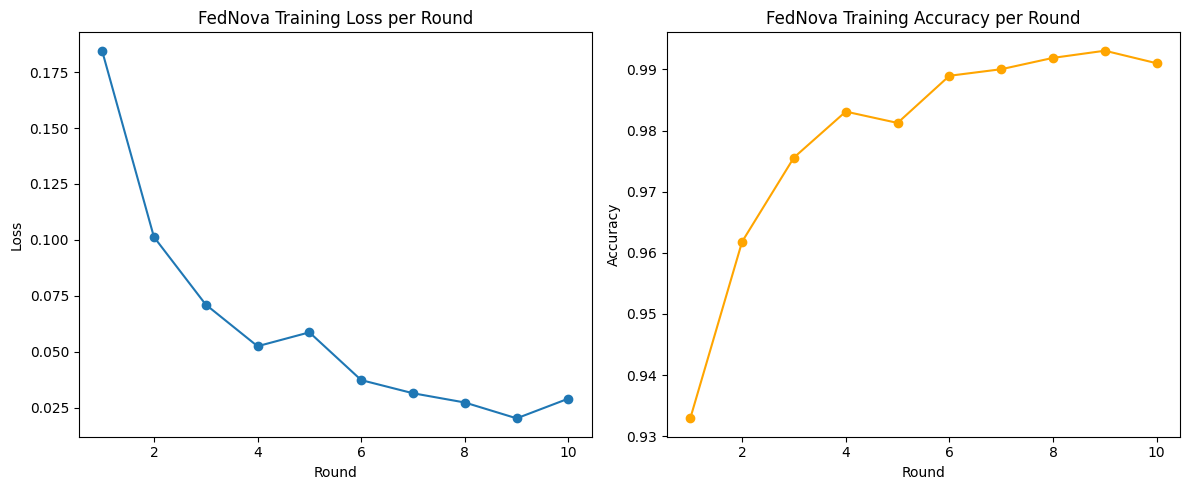

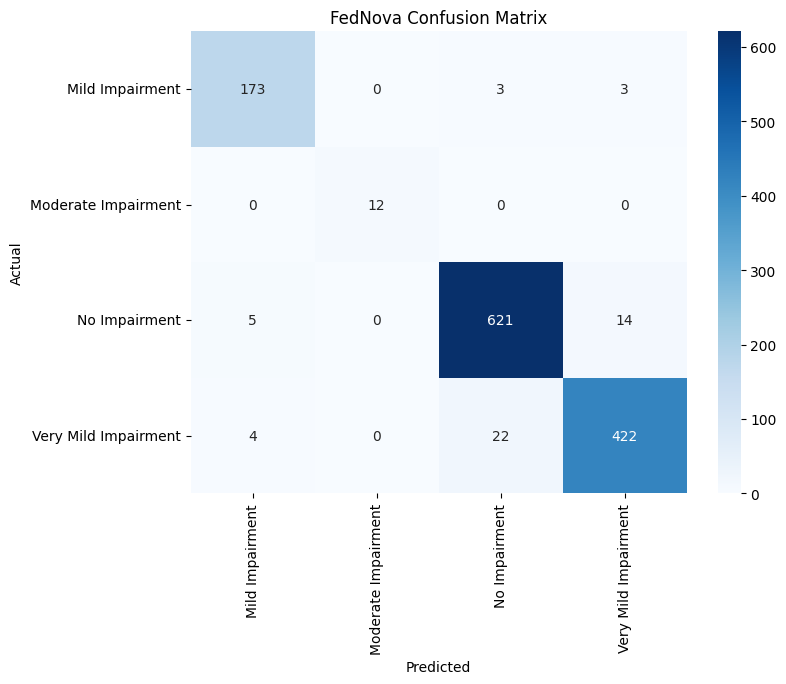

FedNova Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.95      0.97      0.96       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.96      0.97      0.97       640
Very Mild Impairment       0.96      0.94      0.95       448

            accuracy                           0.96      1279
           macro avg       0.97      0.97      0.97      1279
        weighted avg       0.96      0.96      0.96      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters
img_size = (224, 224)
batch_size = 8
num_clients = 3
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

def split_data_iid(generator, num_clients):
    data = []
    labels = []
    generator.reset()
    for _ in range(len(generator)):
        x_batch, y_batch = next(generator)
        data.append(x_batch)
        labels.append(y_batch)
    if len(data) == 0:
        raise ValueError("No data found. Check dataset structure and class folder names.")
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    split_data_arrays = np.array_split(data, num_clients)
    split_labels_arrays = np.array_split(labels, num_clients)
    client_data = []
    for i in range(num_clients):
        client_data.append((split_data_arrays[i], split_labels_arrays[i]))
    return client_data

client_data = split_data_iid(train_generator, num_clients)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False

    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))



global_model = create_model()
global_weights = global_model.get_weights()

fednova_train_loss = []
fednova_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedNova - Round {round_num+1}/{num_rounds}")
    local_updates = []
    local_losses = []
    local_accuracies = []
    local_steps = []

    global_model.set_weights(global_weights)
    w_global = global_weights

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(w_global)
        client_optimizer = Adam(learning_rate=learning_rate)

        client_model.compile(optimizer=client_optimizer,
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()
        # محاسبه آپدیت: Δ_i = w_local - w_global
        delta = [w_l - w_g for w_l, w_g in zip(w_local, w_global)]


        total_samples = client_X.shape[0]
        client_step = (total_samples / batch_size) * local_epochs
        local_steps.append(client_step)

        local_updates.append(delta)
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])


    sum_steps = np.sum(local_steps)
    new_weights = []
    for weight_idx in range(len(global_weights)):
        weighted_sum = np.zeros_like(global_weights[weight_idx])
        for ci in range(num_clients):
            weighted_sum += (local_steps[ci] * local_updates[ci][weight_idx])
        normalized_update = weighted_sum / sum_steps
        new_weights.append(w_global[weight_idx] + normalized_update)

    global_weights = new_weights

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fednova_train_loss.append(avg_loss)
    fednova_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedNova Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fednova_train_loss, fednova_train_accuracy, "FedNova")
plot_confusion_matrix(global_model, test_generator, classes, "FedNova")


 Implementation FEDADAM  IID

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 88% 63.0M/71.5M [00:00<00:00, 216MB/s]
100% 71.5M/71.5M [00:00<00:00, 219MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
FedAdam - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1791, Average Training Accuracy: 0.9321
FedAdam - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1679, Average Training Accuracy: 0.9424
FedAdam - Round 3/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training L

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedAdam Test Accuracy: 46.05%


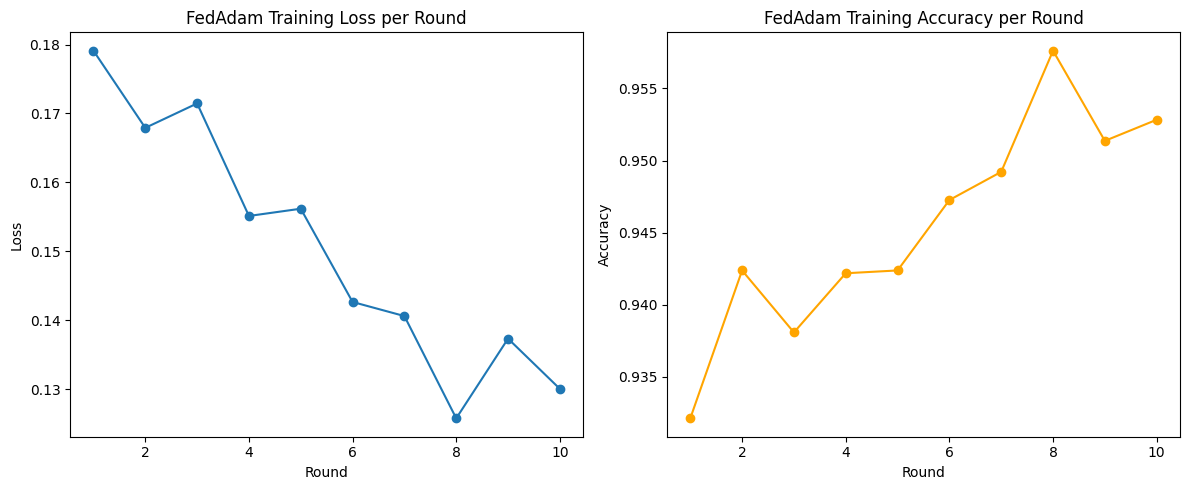

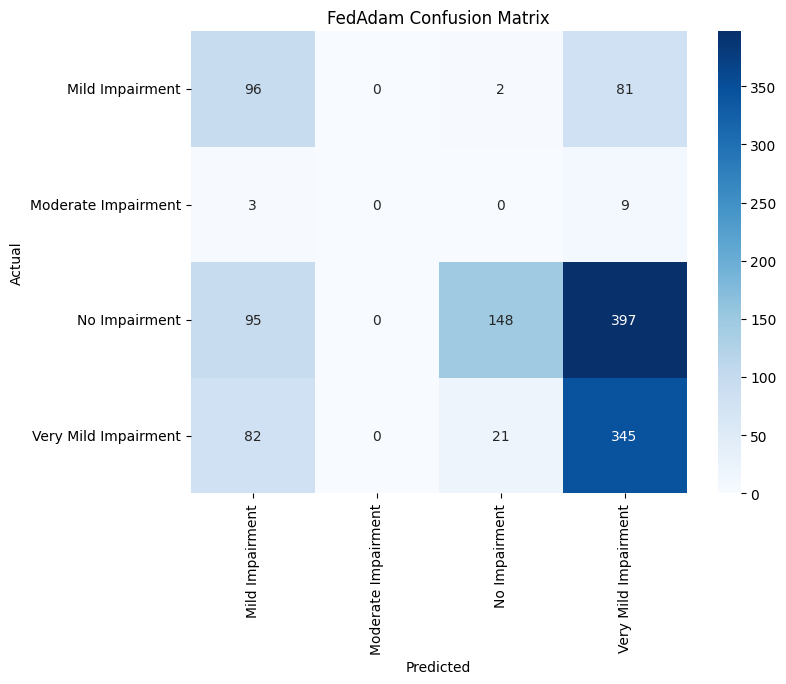

FedAdam Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.35      0.54      0.42       179
 Moderate Impairment       0.00      0.00      0.00        12
       No Impairment       0.87      0.23      0.36       640
Very Mild Impairment       0.41      0.77      0.54       448

            accuracy                           0.46      1279
           macro avg       0.41      0.38      0.33      1279
        weighted avg       0.63      0.46      0.43      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters (same as FedProx scenario)
img_size = (224, 224)
batch_size = 8
num_clients = 3
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20  # same unfreeze setting

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

# Use preprocess_input for ResNet50
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

def split_data(generator, num_clients):
    data = []
    labels = []
    generator.reset()
    for _ in range(len(generator)):
        x_batch, y_batch = next(generator)
        data.append(x_batch)
        labels.append(y_batch)
    if len(data) == 0:
        raise ValueError("No data found. Check dataset structure and class folder names.")
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    split_data_arrays = np.array_split(data, num_clients)
    split_labels_arrays = np.array_split(labels, num_clients)
    client_data = []
    for i in range(num_clients):
        client_data.append((split_data_arrays[i], split_labels_arrays[i]))
    return client_data

client_data = split_data(train_generator, num_clients)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    # Freeze all layers
    for layer in base_model.layers:
        layer.trainable = False

    # Unfreeze last 20 layers
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

# FedAdam Implementation
# در FedAdam:
# - هر کلاینت مدل را مانند FedAvg لوکالی آپدیت می‌کند.
# - در سرور از Adam برای آپدیت مدل جهانی استفاده می‌کنیم، اما بر اساس اختلاف وزن‌ها (مانند گرادیان).

global_model = create_model()
global_weights = global_model.get_weights()

# Initialize Adam states at server
m = [np.zeros_like(w) for w in global_weights]
v = [np.zeros_like(w) for w in global_weights]
beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

fedadam_train_loss = []
fedadam_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedAdam - Round {round_num+1}/{num_rounds}")
    local_weights = []
    local_losses = []
    local_accuracies = []

    # Set current global weights
    global_model.set_weights(global_weights)

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)

        client_model.compile(optimizer=client_optimizer,
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        local_weights.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    # Compute average of local weights (like FedAvg)
    new_weights_avg = []
    for weights_set in zip(*local_weights):
        new_weights_avg.append(np.mean(weights_set, axis=0))

    # Compute gradient approximation: grad = global_weights - new_weights_avg
    # Because we want to move from global_weights towards new_weights_avg, gradient ~ (W_global - W_avg)
    grads = [gw - nw for gw, nw in zip(global_weights, new_weights_avg)]

    # Apply Adam update at server
    # m = beta1*m + (1-beta1)*grad
    # v = beta2*v + (1-beta2)*grad^2
    # w = w - lr * m_hat / (sqrt(v_hat)+eps) with bias correction
    t = round_num + 1
    for i in range(len(global_weights)):
        m[i] = beta1 * m[i] + (1 - beta1) * grads[i]
        v[i] = beta2 * v[i] + (1 - beta2) * (grads[i]**2)

        m_hat = m[i] / (1 - beta1**t)
        v_hat = v[i] / (1 - beta2**t)

        global_weights[i] = global_weights[i] - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedadam_train_loss.append(avg_loss)
    fedadam_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

# Final evaluation
final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedAdam Test Accuracy: {test_acc*100:.2f}%")

# Plot metrics and confusion matrix
plot_metrics(fedadam_train_loss, fedadam_train_accuracy, "FedAdam")
plot_confusion_matrix(global_model, test_generator, classes, "FedAdam")


Implementation SCAFFOLD IID

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 99% 71.0M/71.5M [00:00<00:00, 142MB/s]
100% 71.5M/71.5M [00:00<00:00, 142MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
SCAFFOLD - Round 1/5
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.4435, Average Training Accuracy: 0.8149
SCAFFOLD - Round 2/5
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.3204, Average Training Accuracy: 0.8674
SCAFFOLD - Round 3/5
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training L

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


SCAFFOLD Test Accuracy: 88.66%


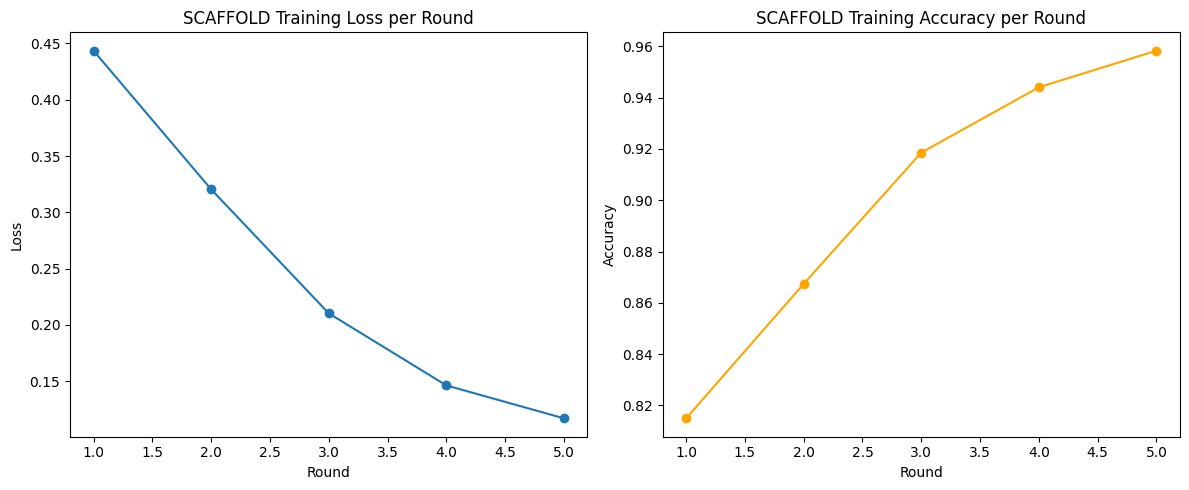

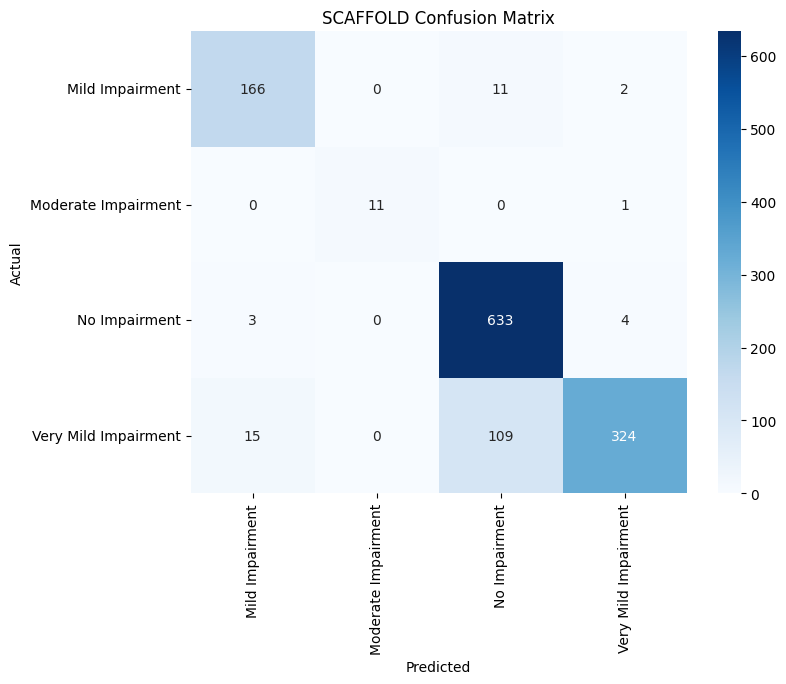

SCAFFOLD Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.90      0.93      0.91       179
 Moderate Impairment       1.00      0.92      0.96        12
       No Impairment       0.84      0.99      0.91       640
Very Mild Impairment       0.98      0.72      0.83       448

            accuracy                           0.89      1279
           macro avg       0.93      0.89      0.90      1279
        weighted avg       0.90      0.89      0.88      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters
img_size = (224, 224)
batch_size = 8
num_clients = 3
learning_rate = 1e-4
num_rounds = 5   # to test quickly
local_epochs = 2
unfreeze_layers = 20

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

def split_data_iid(generator, num_clients):
    data = []
    labels = []
    generator.reset()
    for _ in range(len(generator)):
        x_batch, y_batch = next(generator)
        data.append(x_batch)
        labels.append(y_batch)
    if len(data) == 0:
        raise ValueError("No data found.")
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    split_data_arrays = np.array_split(data, num_clients)
    split_labels_arrays = np.array_split(labels, num_clients)
    client_data = []
    for i in range(num_clients):
        client_data.append((split_data_arrays[i], split_labels_arrays[i]))
    return client_data

client_data = split_data_iid(train_generator, num_clients)

def create_base_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size + (3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True
    return base_model

def create_model():
    base_model = create_base_model()
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

# Initialize global model
global_model = create_model()
global_model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
initial_weights = global_model.get_weights()

# SCAFFOLD variables:
# c: server control variate (same shape as model weights)
# c_i: client control variates (one per client)
global_model.set_weights(initial_weights)
c = [np.zeros_like(w) for w in global_model.get_weights()] # server control variate
c_i_list = []
for _ in range(num_clients):
    c_i_list.append([np.zeros_like(w) for w in global_model.get_weights()])

scaffold_train_loss = []
scaffold_train_accuracy = []

for round_num in range(num_rounds):
    print(f"SCAFFOLD - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []
    deltas_c_i_list = []

    # Get current global weights
    global_weights = global_model.get_weights()

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)

        client_optimizer = Adam(learning_rate=learning_rate)
        client_model.compile(optimizer=client_optimizer,
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()

        delta_c_i = [c[j] - c_i_list[client_idx][j] for j in range(len(c))]
        deltas_c_i_list.append(delta_c_i)

        local_weights_list.append(w_local)
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    # Server update:
    # w := average of w_local
    new_global_weights = []
    for w_set in zip(*local_weights_list):
        new_global_weights.append(np.mean(w_set, axis=0))

    # c := c + (1/N)*sum(Δc_i)
    sum_delta_c = []
    for j in range(len(c)):
        sum_ = np.zeros_like(c[j])
        for i in range(num_clients):
            sum_ += deltas_c_i_list[i][j]
        sum_ = sum_ / num_clients
        sum_delta_c.append(sum_)

    for j in range(len(c)):
        c[j] = c[j] + sum_delta_c[j]


    for i in range(num_clients):
        c_i_list[i] = [np.copy(c_w) for c_w in c]

    # Set new global weights to global_model
    global_model.set_weights(new_global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    scaffold_train_loss.append(avg_loss)
    scaffold_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"SCAFFOLD Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(scaffold_train_loss, scaffold_train_accuracy, "SCAFFOLD")
plot_confusion_matrix(global_model, test_generator, classes, "SCAFFOLD")


phase 4 : NONIID for these 2 new algorithms

FEDNEVA on senario 1

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 99% 71.0M/71.5M [00:04<00:00, 19.3MB/s]
100% 71.5M/71.5M [00:04<00:00, 16.7MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FedNova Label Skew - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1696, Average Training Accuracy: 0.9395
FedNova Label Skew - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0821, Average Training Accuracy: 0.97

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedNova Label Skew Test Accuracy: 90.62%


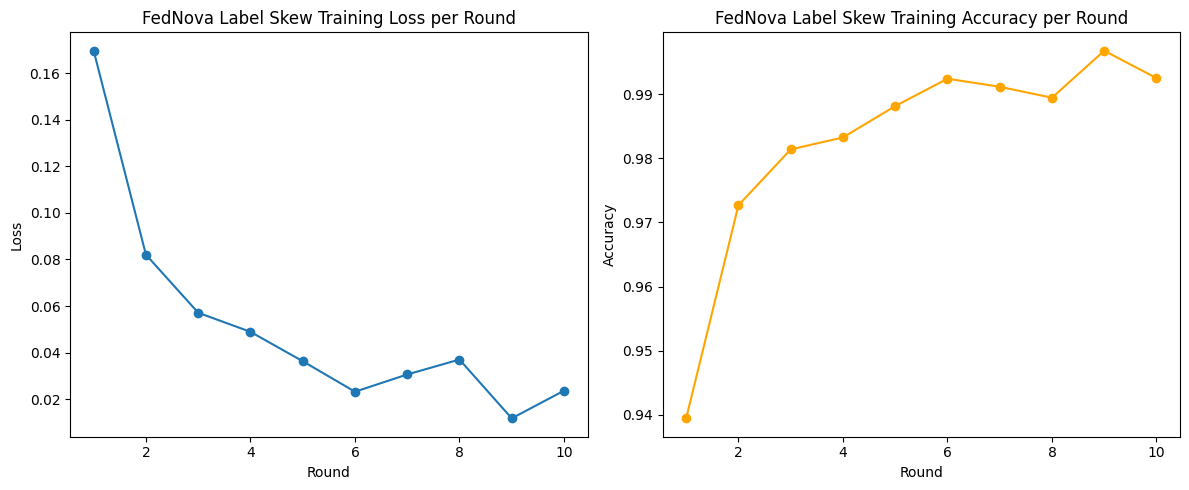

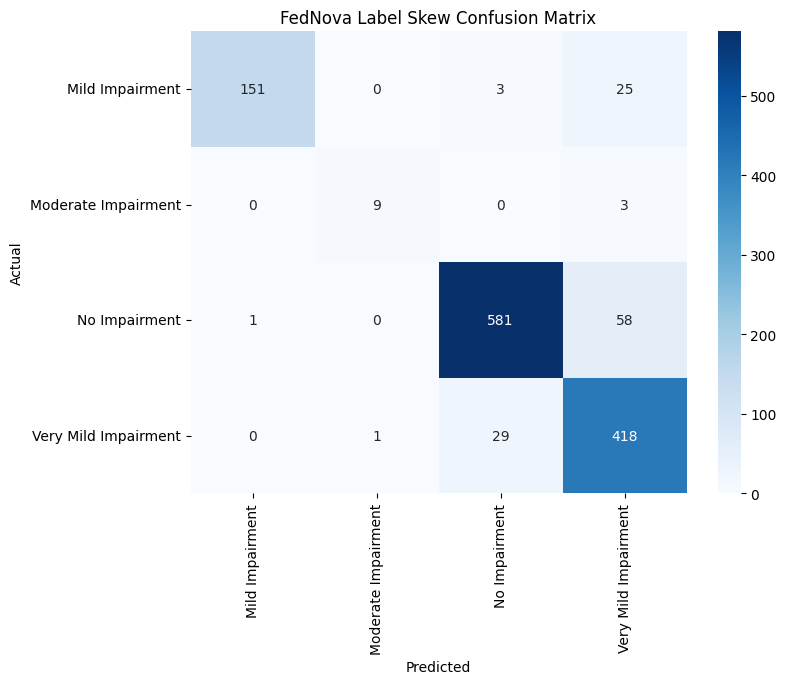

FedNova Label Skew Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.99      0.84      0.91       179
 Moderate Impairment       0.90      0.75      0.82        12
       No Impairment       0.95      0.91      0.93       640
Very Mild Impairment       0.83      0.93      0.88       448

            accuracy                           0.91      1279
           macro avg       0.92      0.86      0.88      1279
        weighted avg       0.91      0.91      0.91      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_label_skew_data(X, y, classes, num_clients):
    c_mild = classes.index("Mild Impairment")
    c_mod = classes.index("Moderate Impairment")
    c_no = classes.index("No Impairment")
    c_very = classes.index("Very Mild Impairment")

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    def choose_frac(cls_ind, frac):
        count = int(len(cls_ind)*frac)
        chosen = np.random.choice(cls_ind, count, replace=False)
        remain = np.setdiff1d(cls_ind, chosen)
        return chosen, remain

    # Client 1:
    mild_chosen, class_indices[c_mild] = choose_frac(class_indices[c_mild], 0.7)
    others1 = np.concatenate([class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    others1_count = int(len(others1)*0.3) if len(others1)>0 else 0
    if others1_count>0:
        others1_chosen = np.random.choice(others1, others1_count, replace=False)
        for cc in [c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], others1_chosen[np.isin(others1_chosen, class_indices[cc])])
    else:
        others1_chosen = np.array([], dtype=int)
    client1_indices = np.concatenate([mild_chosen, others1_chosen])

    # Client 2:
    no_ = class_indices[c_no]
    mod_ = class_indices[c_mod]
    no_count = int(len(no_)*0.35) if len(no_)>0 else 0
    mod_count = int(len(mod_)*0.35) if len(mod_)>0 else 0
    no_chosen = np.random.choice(no_, no_count, replace=False) if no_count>0 else np.array([], dtype=int)
    mod_chosen = np.random.choice(mod_, mod_count, replace=False) if mod_count>0 else np.array([], dtype=int)
    class_indices[c_no] = np.setdiff1d(class_indices[c_no], no_chosen)
    class_indices[c_mod] = np.setdiff1d(class_indices[c_mod], mod_chosen)

    rem2 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem2_count = int(len(rem2)*0.3) if len(rem2)>0 else 0
    if rem2_count>0:
        rem2_chosen = np.random.choice(rem2, rem2_count, replace=False)
        for cc in [c_mild, c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], rem2_chosen[np.isin(rem2_chosen, class_indices[cc])])
    else:
        rem2_chosen = np.array([], dtype=int)
    client2_indices = np.concatenate([no_chosen, mod_chosen, rem2_chosen])

    # Client 3:
    very_ = class_indices[c_very]
    v_count = int(len(very_)*0.7) if len(very_)>0 else 0
    v_chosen = np.random.choice(very_, v_count, replace=False) if v_count>0 else np.array([], dtype=int)
    class_indices[c_very] = np.setdiff1d(class_indices[c_very], v_chosen)

    rem3 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem3_count = int(len(rem3)*0.3) if len(rem3)>0 else 0
    if rem3_count > len(rem3):
        rem3_count = len(rem3)
    rem3_chosen = np.random.choice(rem3, rem3_count, replace=False) if rem3_count>0 else np.array([], dtype=int)

    client3_indices = np.concatenate([v_chosen, rem3_chosen])

    for arr in [client1_indices, client2_indices, client3_indices]:
        np.random.shuffle(arr)

    return [(X[client1_indices], y[client1_indices]),
            (X[client2_indices], y[client2_indices]),
            (X[client3_indices], y[client3_indices])]

client_data = create_label_skew_data(X, y, classes, num_clients)

global_model = create_model()
global_weights = global_model.get_weights()

fednova_train_loss = []
fednova_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedNova Label Skew - Round {round_num+1}/{num_rounds}")
    local_updates = []
    local_steps = []
    local_losses = []
    local_accuracies = []

    global_model.set_weights(global_weights)
    w_global = global_weights

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(w_global)
        client_optimizer = Adam(learning_rate=learning_rate)

        client_model.compile(optimizer=client_optimizer,
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()
        delta = [w_l - w_g for w_l, w_g in zip(w_local, w_global)]
        # تعداد استپ‌های محلی
        total_samples = client_X.shape[0]
        client_step = (total_samples / batch_size) * local_epochs
        local_steps.append(client_step)

        local_updates.append(delta)
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    sum_steps = np.sum(local_steps)
    new_weights = []
    for weight_idx in range(len(global_weights)):
        weighted_sum = np.zeros_like(global_weights[weight_idx])
        for ci in range(num_clients):
            weighted_sum += (local_steps[ci] * local_updates[ci][weight_idx])
        normalized_update = weighted_sum / sum_steps
        new_weights.append(w_global[weight_idx] + normalized_update)

    global_weights = new_weights

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fednova_train_loss.append(avg_loss)
    fednova_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedNova Label Skew Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fednova_train_loss, fednova_train_accuracy, "FedNova Label Skew")
plot_confusion_matrix(global_model, test_generator, classes, "FedNova Label Skew")


# FEDNEVA on senario 2

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 96% 69.0M/71.5M [00:04<00:00, 23.9MB/s]
100% 71.5M/71.5M [00:04<00:00, 18.0MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FedNova Dirichlet - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1153, Average Training Accuracy: 0.9592
FedNova Dirichlet - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0671, Average Training Accuracy: 0.9776

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedNova Dirichlet Test Accuracy: 85.77%


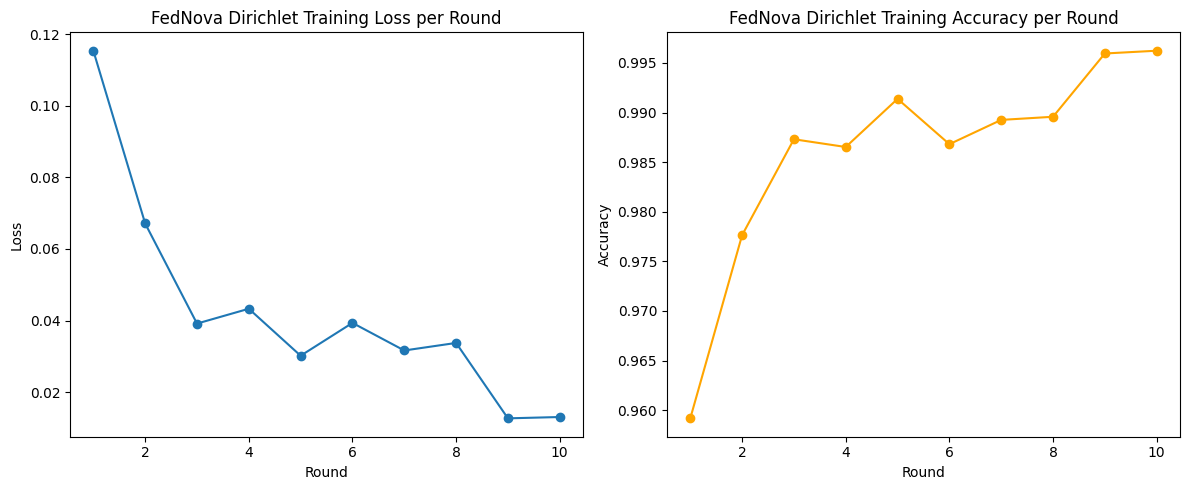

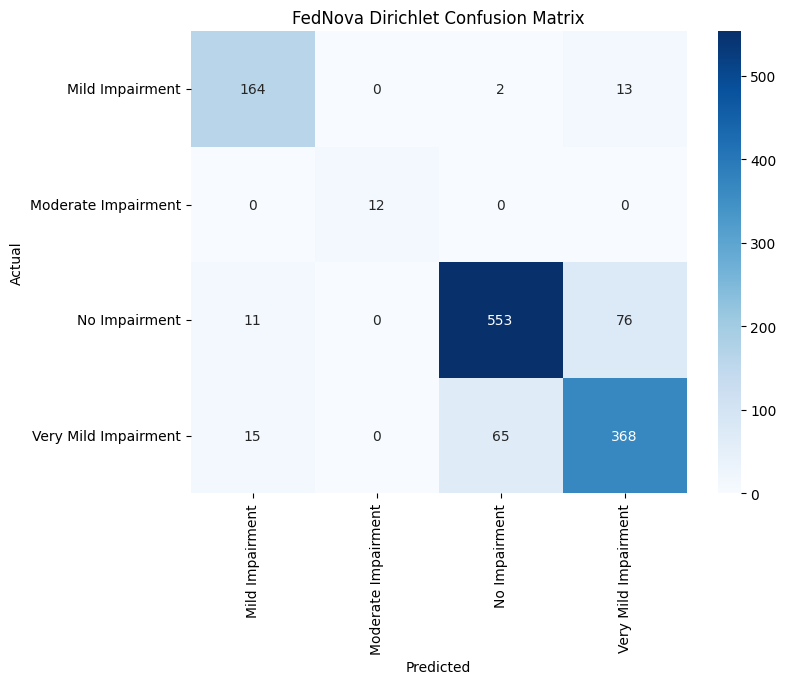

FedNova Dirichlet Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.86      0.92      0.89       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.89      0.86      0.88       640
Very Mild Impairment       0.81      0.82      0.81       448

            accuracy                           0.86      1279
           macro avg       0.89      0.90      0.89      1279
        weighted avg       0.86      0.86      0.86      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from numpy.random import dirichlet

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3
alpha = 0.5

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=0.5):
    client_data = [[] for _ in range(num_clients)]
    client_labels = [[] for _ in range(num_clients)]

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    for cls_idx in range(len(classes)):
        cls_inds = class_indices[cls_idx]
        np.random.shuffle(cls_inds)
        n = len(cls_inds)
        proportions = dirichlet([alpha]*num_clients)
        counts = (proportions * n).astype(int)
        diff = n - np.sum(counts)
        if diff > 0:
            counts[np.argmax(counts)] += diff

        start = 0
        for c in range(num_clients):
            c_count = counts[c]
            c_inds = cls_inds[start:start+c_count]
            start += c_count
            client_data[c].append(X[c_inds])
            client_labels[c].append(y[c_inds])

    final_clients = []
    for c in range(num_clients):
        X_c = np.concatenate(client_data[c])
        y_c = np.concatenate(client_labels[c])
        inds = np.arange(len(X_c))
        np.random.shuffle(inds)
        X_c = X_c[inds]
        y_c = y_c[inds]
        final_clients.append((X_c, y_c))
    return final_clients

client_data = create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=alpha)

global_model = create_model()
global_weights = global_model.get_weights()

fednova_train_loss = []
fednova_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedNova Dirichlet - Round {round_num+1}/{num_rounds}")
    local_updates = []
    local_steps = []
    local_losses = []
    local_accuracies = []

    global_model.set_weights(global_weights)
    w_global = global_weights

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(w_global)
        client_optimizer = Adam(learning_rate=learning_rate)

        client_model.compile(optimizer=client_optimizer,
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()
        delta = [w_l - w_g for w_l, w_g in zip(w_local, w_global)]
        total_samples = client_X.shape[0]
        client_step = (total_samples / batch_size) * local_epochs
        local_steps.append(client_step)

        local_updates.append(delta)
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    sum_steps = np.sum(local_steps)
    new_weights = []
    for weight_idx in range(len(global_weights)):
        weighted_sum = np.zeros_like(global_weights[weight_idx])
        for ci in range(num_clients):
            weighted_sum += (local_steps[ci] * local_updates[ci][weight_idx])
        normalized_update = weighted_sum / sum_steps
        new_weights.append(w_global[weight_idx] + normalized_update)

    global_weights = new_weights

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fednova_train_loss.append(avg_loss)
    fednova_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedNova Dirichlet Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fednova_train_loss, fednova_train_accuracy, "FedNova Dirichlet")
plot_confusion_matrix(global_model, test_generator, classes, "FedNova Dirichlet")


# FedAdam Non-IID (Label Skew)

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 76% 54.0M/71.5M [00:00<00:00, 304MB/s]
100% 71.5M/71.5M [00:00<00:00, 311MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
FedAdam Label Skew - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1685, Average Training Accuracy: 0.9355
FedAdam Label Skew - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1584, Average Training Accuracy: 0.9420

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedAdam Label Skew Test Accuracy: 45.27%


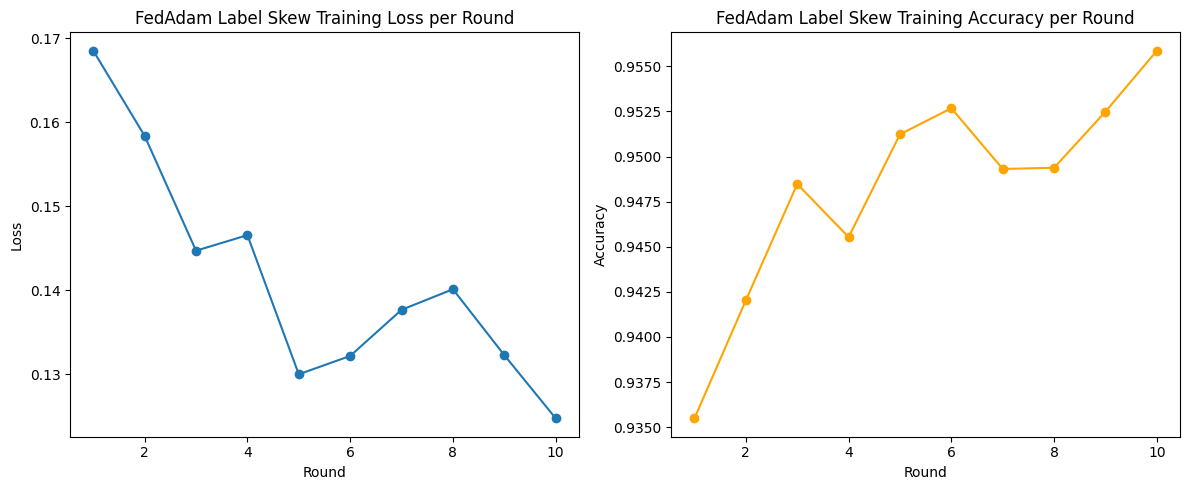

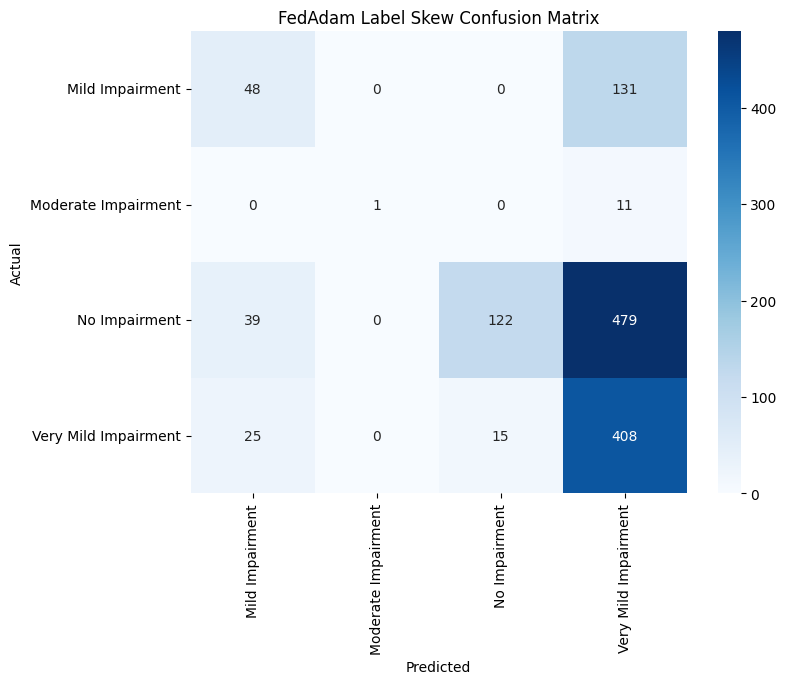

FedAdam Label Skew Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.43      0.27      0.33       179
 Moderate Impairment       1.00      0.08      0.15        12
       No Impairment       0.89      0.19      0.31       640
Very Mild Impairment       0.40      0.91      0.55       448

            accuracy                           0.45      1279
           macro avg       0.68      0.36      0.34      1279
        weighted avg       0.65      0.45      0.40      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3

beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_label_skew_data(X, y, classes, num_clients):
    c_mild = classes.index("Mild Impairment")
    c_mod = classes.index("Moderate Impairment")
    c_no = classes.index("No Impairment")
    c_very = classes.index("Very Mild Impairment")

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    def choose_frac(cls_ind, frac):
        count = int(len(cls_ind)*frac)
        chosen = np.random.choice(cls_ind, count, replace=False)
        remain = np.setdiff1d(cls_ind, chosen)
        return chosen, remain

    # Client 1:
    mild_chosen, class_indices[c_mild] = choose_frac(class_indices[c_mild], 0.7)
    others1 = np.concatenate([class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    others1_count = int(len(others1)*0.3) if len(others1)>0 else 0
    if others1_count>0:
        others1_chosen = np.random.choice(others1, others1_count, replace=False)
        for cc in [c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], others1_chosen[np.isin(others1_chosen, class_indices[cc])])
    else:
        others1_chosen = np.array([], dtype=int)
    client1_indices = np.concatenate([mild_chosen, others1_chosen])

    # Client 2:
    no_ = class_indices[c_no]
    mod_ = class_indices[c_mod]
    no_count = int(len(no_)*0.35) if len(no_)>0 else 0
    mod_count = int(len(mod_)*0.35) if len(mod_)>0 else 0
    no_chosen = np.random.choice(no_, no_count, replace=False) if no_count>0 else np.array([], dtype=int)
    mod_chosen = np.random.choice(mod_, mod_count, replace=False) if mod_count>0 else np.array([], dtype=int)
    class_indices[c_no] = np.setdiff1d(class_indices[c_no], no_chosen)
    class_indices[c_mod] = np.setdiff1d(class_indices[c_mod], mod_chosen)

    rem2 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem2_count = int(len(rem2)*0.3) if len(rem2)>0 else 0
    if rem2_count>0:
        rem2_chosen = np.random.choice(rem2, rem2_count, replace=False)
        for cc in [c_mild, c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], rem2_chosen[np.isin(rem2_chosen, class_indices[cc])])
    else:
        rem2_chosen = np.array([], dtype=int)
    client2_indices = np.concatenate([no_chosen, mod_chosen, rem2_chosen])

    # Client 3:
    very_ = class_indices[c_very]
    v_count = int(len(very_)*0.7) if len(very_)>0 else 0
    v_chosen = np.random.choice(very_, v_count, replace=False) if v_count>0 else np.array([], dtype=int)
    class_indices[c_very] = np.setdiff1d(class_indices[c_very], v_chosen)

    rem3 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem3_count = int(len(rem3)*0.3) if len(rem3)>0 else 0
    if rem3_count > len(rem3):
        rem3_count = len(rem3)
    rem3_chosen = np.random.choice(rem3, rem3_count, replace=False) if rem3_count>0 else np.array([], dtype=int)

    client3_indices = np.concatenate([v_chosen, rem3_chosen])

    for arr in [client1_indices, client2_indices, client3_indices]:
        np.random.shuffle(arr)

    return [(X[client1_indices], y[client1_indices]),
            (X[client2_indices], y[client2_indices]),
            (X[client3_indices], y[client3_indices])]

client_data = create_label_skew_data(X, y, classes, num_clients)

global_model = create_model()
global_weights = global_model.get_weights()

# Initialize Adam states
m = [np.zeros_like(w) for w in global_weights]
v = [np.zeros_like(w) for w in global_weights]

fedadam_train_loss = []
fedadam_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedAdam Label Skew - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    global_model.set_weights(global_weights)

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)

        client_model.compile(optimizer=client_optimizer,
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        local_weights_list.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    # Average local weights
    new_weights_avg = []
    for w_set in zip(*local_weights_list):
        new_weights_avg.append(np.mean(w_set, axis=0))

    # Compute gradient approximation
    grads = [gw - nw for gw, nw in zip(global_weights, new_weights_avg)]

    t = round_num + 1
    for i in range(len(global_weights)):
        m[i] = beta1*m[i] + (1-beta1)*grads[i]
        v[i] = beta2*v[i] + (1-beta2)*(grads[i]**2)

        m_hat = m[i] / (1 - beta1**t)
        v_hat = v[i] / (1 - beta2**t)

        global_weights[i] = global_weights[i] - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedadam_train_loss.append(avg_loss)
    fedadam_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedAdam Label Skew Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedadam_train_loss, fedadam_train_accuracy, "FedAdam Label Skew")
plot_confusion_matrix(global_model, test_generator, classes, "FedAdam Label Skew")


# FEDADAM on senario 2 :

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 98% 70.0M/71.5M [00:03<00:00, 29.1MB/s]
100% 71.5M/71.5M [00:03<00:00, 22.7MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
FedAdam Dirichlet - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1300, Average Training Accuracy: 0.9552
FedAdam Dirichlet - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1330, Average Training Accuracy: 0.9533

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedAdam Dirichlet Test Accuracy: 48.79%


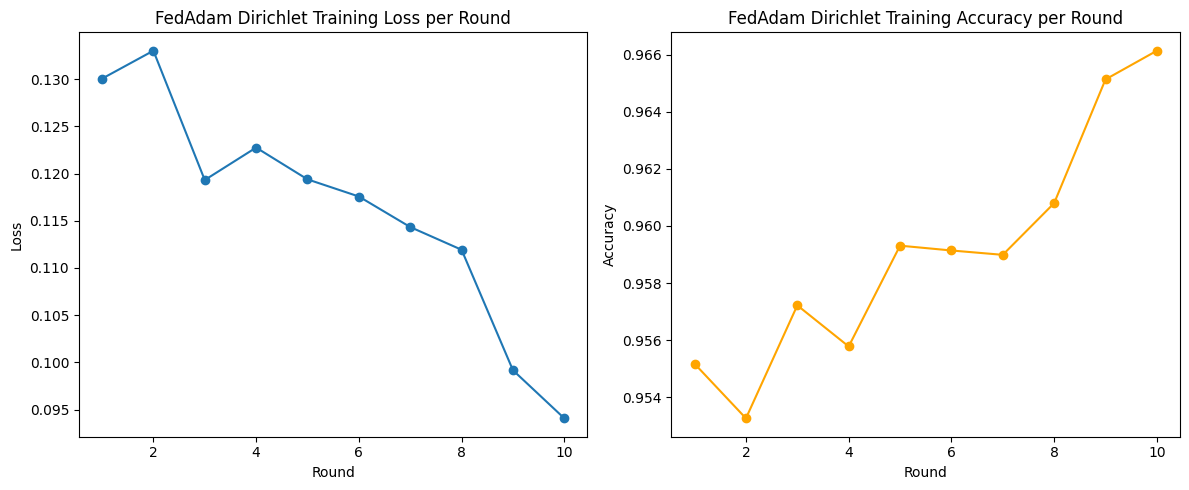

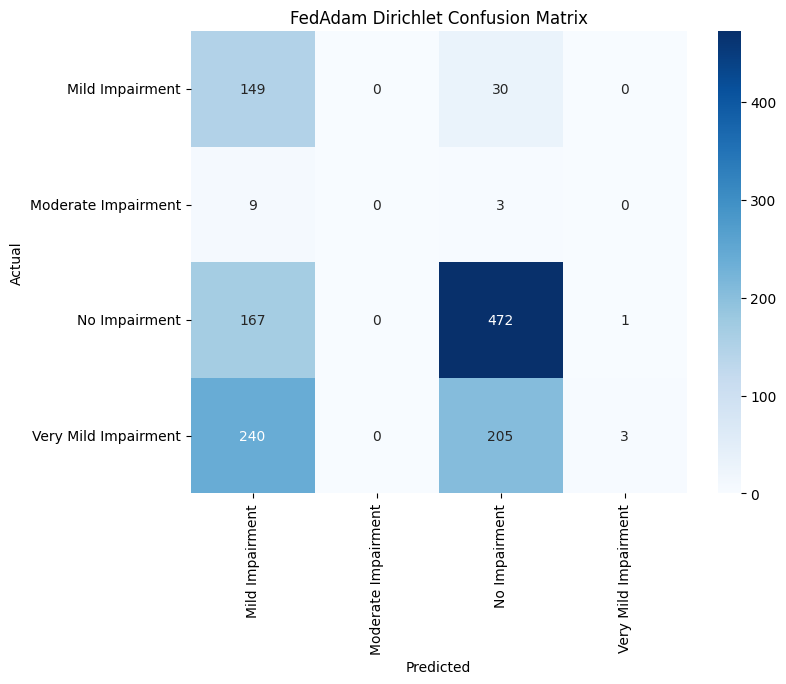

FedAdam Dirichlet Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.26      0.83      0.40       179
 Moderate Impairment       0.00      0.00      0.00        12
       No Impairment       0.66      0.74      0.70       640
Very Mild Impairment       0.75      0.01      0.01       448

            accuracy                           0.49      1279
           macro avg       0.42      0.39      0.28      1279
        weighted avg       0.63      0.49      0.41      1279



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from numpy.random import dirichlet

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3
alpha = 0.5

beta1 = 0.9
beta2 = 0.999
epsilon = 1e-8

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=0.5):
    client_data = [[] for _ in range(num_clients)]
    client_labels = [[] for _ in range(num_clients)]

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    for cls_idx in range(len(classes)):
        cls_inds = class_indices[cls_idx]
        np.random.shuffle(cls_inds)
        n = len(cls_inds)
        proportions = dirichlet([alpha]*num_clients)
        counts = (proportions * n).astype(int)
        diff = n - np.sum(counts)
        if diff > 0:
            counts[np.argmax(counts)] += diff

        start = 0
        for c in range(num_clients):
            c_count = counts[c]
            c_inds = cls_inds[start:start+c_count]
            start += c_count
            client_data[c].append(X[c_inds])
            client_labels[c].append(y[c_inds])

    final_clients = []
    for c in range(num_clients):
        X_c = np.concatenate(client_data[c])
        y_c = np.concatenate(client_labels[c])
        inds = np.arange(len(X_c))
        np.random.shuffle(inds)
        X_c = X_c[inds]
        y_c = y_c[inds]
        final_clients.append((X_c, y_c))
    return final_clients

client_data = create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=alpha)

global_model = create_model()
global_weights = global_model.get_weights()

m = [np.zeros_like(w) for w in global_weights]
v = [np.zeros_like(w) for w in global_weights]

fedadam_train_loss = []
fedadam_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedAdam Dirichlet - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    global_model.set_weights(global_weights)

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)

        client_model.compile(optimizer=client_optimizer,
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        local_weights_list.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    # Average local weights
    new_weights_avg = []
    for w_set in zip(*local_weights_list):
        new_weights_avg.append(np.mean(w_set, axis=0))

    # Compute gradient approximation
    grads = [gw - nw for gw, nw in zip(global_weights, new_weights_avg)]

    t = round_num + 1
    for i in range(len(global_weights)):
        m[i] = beta1*m[i] + (1-beta1)*grads[i]
        v[i] = beta2*v[i] + (1-beta2)*(grads[i]**2)

        m_hat = m[i] / (1 - beta1**t)
        v_hat = v[i] / (1 - beta2**t)

        global_weights[i] = global_weights[i] - learning_rate * m_hat / (np.sqrt(v_hat) + epsilon)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedadam_train_loss.append(avg_loss)
    fedadam_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])

test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedAdam Dirichlet Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedadam_train_loss, fedadam_train_accuracy, "FedAdam Dirichlet")
plot_confusion_matrix(global_model, test_generator, classes, "FedAdam Dirichlet")


# NONIID Scaffold senario 1

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 99% 71.0M/71.5M [00:00<00:00, 193MB/s]
100% 71.5M/71.5M [00:00<00:00, 169MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
SCAFFOLD Label Skew - Round 1/5
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.4195, Average Training Accuracy: 0.8328
SCAFFOLD Label Skew - Round 2/5
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.2928, Average Training Accuracy: 0.8879

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


SCAFFOLD Label Skew Test Accuracy: 86.00%


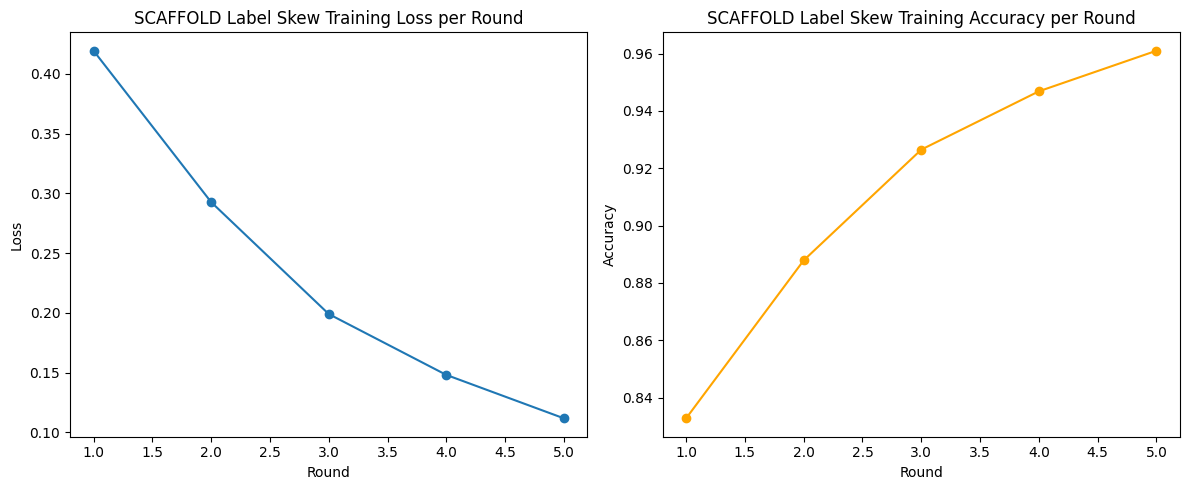

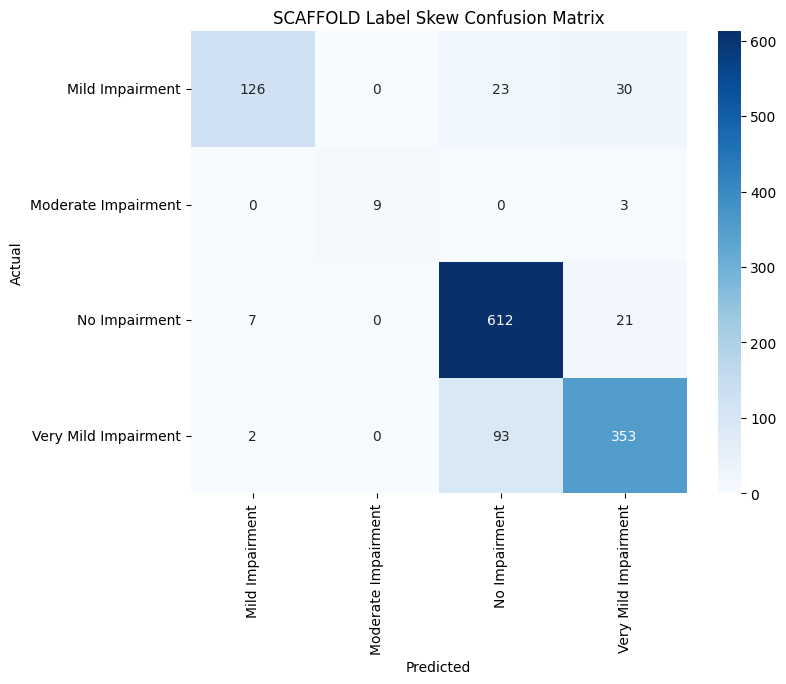

SCAFFOLD Label Skew Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.93      0.70      0.80       179
 Moderate Impairment       1.00      0.75      0.86        12
       No Impairment       0.84      0.96      0.89       640
Very Mild Impairment       0.87      0.79      0.83       448

            accuracy                           0.86      1279
           macro avg       0.91      0.80      0.85      1279
        weighted avg       0.86      0.86      0.86      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 5   # fewer rounds for test
local_epochs = 2
unfreeze_layers = 20
num_clients = 3

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_label_skew_data(X, y, classes, num_clients):
    c_mild = classes.index("Mild Impairment")
    c_mod = classes.index("Moderate Impairment")
    c_no = classes.index("No Impairment")
    c_very = classes.index("Very Mild Impairment")

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    def choose_frac(cls_ind, frac):
        count = int(len(cls_ind)*frac)
        chosen = np.random.choice(cls_ind, count, replace=False)
        remain = np.setdiff1d(cls_ind, chosen)
        return chosen, remain

    # Client 1:
    mild_chosen, class_indices[c_mild] = choose_frac(class_indices[c_mild], 0.7)
    others1 = np.concatenate([class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    others1_count = int(len(others1)*0.3) if len(others1)>0 else 0
    if others1_count>0:
        others1_chosen = np.random.choice(others1, others1_count, replace=False)
        for cc in [c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], others1_chosen[np.isin(others1_chosen, class_indices[cc])])
    else:
        others1_chosen = np.array([], dtype=int)
    client1_indices = np.concatenate([mild_chosen, others1_chosen])

    # Client 2:
    no_ = class_indices[c_no]
    mod_ = class_indices[c_mod]
    no_count = int(len(no_)*0.35) if len(no_)>0 else 0
    mod_count = int(len(mod_)*0.35) if len(mod_)>0 else 0
    no_chosen = np.random.choice(no_, no_count, replace=False) if no_count>0 else np.array([], dtype=int)
    mod_chosen = np.random.choice(mod_, mod_count, replace=False) if mod_count>0 else np.array([], dtype=int)
    class_indices[c_no] = np.setdiff1d(class_indices[c_no], no_chosen)
    class_indices[c_mod] = np.setdiff1d(class_indices[c_mod], mod_chosen)

    rem2 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem2_count = int(len(rem2)*0.3) if len(rem2)>0 else 0
    if rem2_count>0:
        rem2_chosen = np.random.choice(rem2, rem2_count, replace=False)
        for cc in [c_mild, c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], rem2_chosen[np.isin(rem2_chosen, class_indices[cc])])
    else:
        rem2_chosen = np.array([], dtype=int)
    client2_indices = np.concatenate([no_chosen, mod_chosen, rem2_chosen])

    # Client 3:
    very_ = class_indices[c_very]
    v_count = int(len(very_)*0.7) if len(very_)>0 else 0
    v_chosen = np.random.choice(very_, v_count, replace=False) if v_count>0 else np.array([], dtype=int)
    class_indices[c_very] = np.setdiff1d(class_indices[c_very], v_chosen)

    rem3 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem3_count = int(len(rem3)*0.3) if len(rem3)>0 else 0
    if rem3_count > len(rem3):
        rem3_count = len(rem3)
    rem3_chosen = np.random.choice(rem3, rem3_count, replace=False) if rem3_count>0 else np.array([], dtype=int)

    client3_indices = np.concatenate([v_chosen, rem3_chosen])

    for arr in [client1_indices, client2_indices, client3_indices]:
        np.random.shuffle(arr)

    return [(X[client1_indices], y[client1_indices]),
            (X[client2_indices], y[client2_indices]),
            (X[client3_indices], y[client3_indices])]

client_data = create_label_skew_data(X, y, classes, num_clients)

# SCAFFOLD
global_model = create_model()
global_model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
initial_weights = global_model.get_weights()

c = [np.zeros_like(w) for w in initial_weights]
c_i_list = []
for _ in range(num_clients):
    c_i_list.append([np.zeros_like(w) for w in initial_weights])

scaffold_ls_train_loss = []
scaffold_ls_train_accuracy = []

for round_num in range(num_rounds):
    print(f"SCAFFOLD Label Skew - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []
    deltas_c_i_list = []

    global_weights = global_model.get_weights()

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_model.compile(optimizer=Adam(learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

        # Train locally
        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()
        delta_c_i = [c[j] - c_i_list[client_idx][j] for j in range(len(c))]
        deltas_c_i_list.append(delta_c_i)

        local_weights_list.append(w_local)
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    # Server update
    new_global_weights = []
    for w_set in zip(*local_weights_list):
        new_global_weights.append(np.mean(w_set, axis=0))

    sum_delta_c = []
    for j in range(len(c)):
        sum_ = np.zeros_like(c[j])
        for i in range(num_clients):
            sum_ += deltas_c_i_list[i][j]
        sum_ = sum_ / num_clients
        sum_delta_c.append(sum_)

    for j in range(len(c)):
        c[j] = c[j] + sum_delta_c[j]

    for i in range(num_clients):
        c_i_list[i] = [np.copy(c_w) for c_w in c]

    global_model.set_weights(new_global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    scaffold_ls_train_loss.append(avg_loss)
    scaffold_ls_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"SCAFFOLD Label Skew Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(scaffold_ls_train_loss, scaffold_ls_train_accuracy, "SCAFFOLD Label Skew")
plot_confusion_matrix(global_model, test_generator, classes, "SCAFFOLD Label Skew")


# NONIID Scaffold senario 2

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 96% 69.0M/71.5M [00:00<00:00, 110MB/s] 
100% 71.5M/71.5M [00:00<00:00, 101MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
SCAFFOLD Dirichlet - Round 1/5
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.2762, Average Training Accuracy: 0.8978
SCAFFOLD Dirichlet - Round 2/5
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1938, Average Training Accuracy: 0.9288


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


SCAFFOLD Dirichlet Test Accuracy: 84.05%


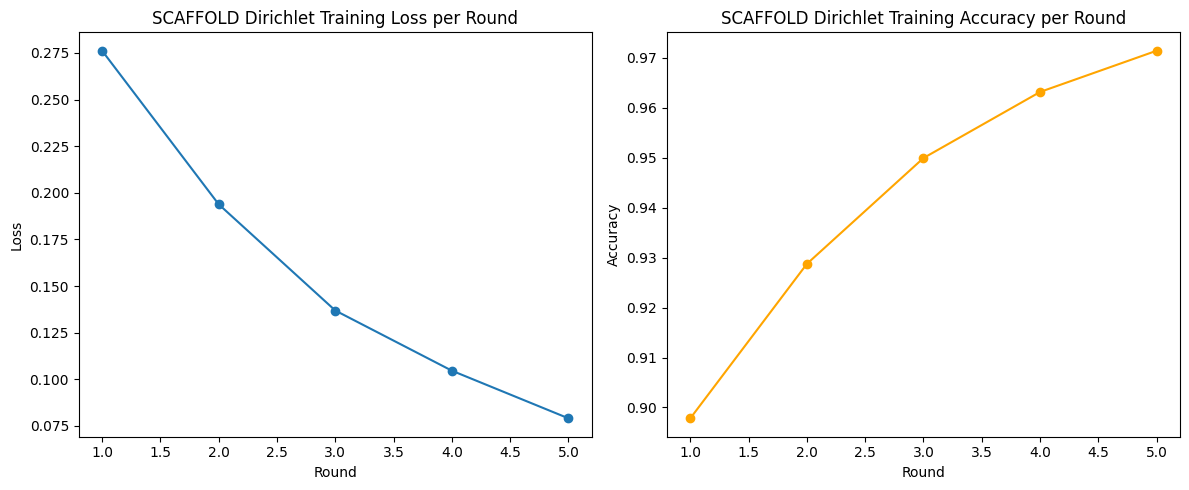

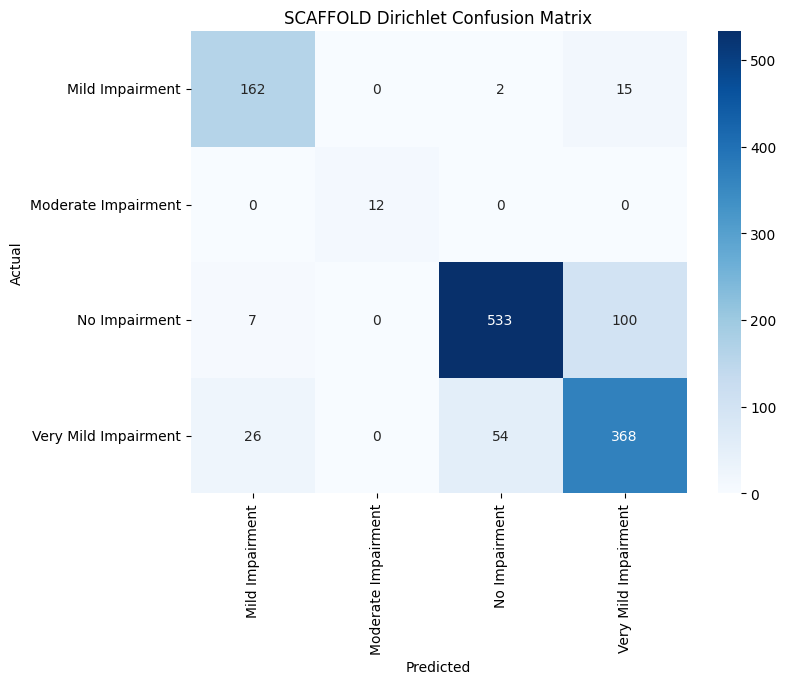

SCAFFOLD Dirichlet Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.83      0.91      0.87       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.90      0.83      0.87       640
Very Mild Impairment       0.76      0.82      0.79       448

            accuracy                           0.84      1279
           macro avg       0.87      0.89      0.88      1279
        weighted avg       0.85      0.84      0.84      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from numpy.random import dirichlet

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 5
local_epochs = 2
unfreeze_layers = 20
num_clients = 3
alpha = 0.5

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=0.5):
    client_data = [[] for _ in range(num_clients)]
    client_labels = [[] for _ in range(num_clients)]

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    for cls_idx in range(len(classes)):
        cls_inds = class_indices[cls_idx]
        np.random.shuffle(cls_inds)
        n = len(cls_inds)
        proportions = dirichlet([alpha]*num_clients)
        counts = (proportions * n).astype(int)
        diff = n - np.sum(counts)
        if diff > 0:
            counts[np.argmax(counts)] += diff

        start = 0
        for c in range(num_clients):
            c_count = counts[c]
            c_inds = cls_inds[start:start+c_count]
            start += c_count
            client_data[c].append(X[c_inds])
            client_labels[c].append(y[c_inds])

    final_clients = []
    for c in range(num_clients):
        X_c = np.concatenate(client_data[c])
        y_c = np.concatenate(client_labels[c])
        inds = np.arange(len(X_c))
        np.random.shuffle(inds)
        X_c = X_c[inds]
        y_c = y_c[inds]
        final_clients.append((X_c, y_c))
    return final_clients

client_data = create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=alpha)

# SCAFFOLD
global_model = create_model()
global_model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
initial_weights = global_model.get_weights()

c = [np.zeros_like(w) for w in initial_weights]
c_i_list = []
for _ in range(num_clients):
    c_i_list.append([np.zeros_like(w) for w in initial_weights])

scaffold_dirichlet_train_loss = []
scaffold_dirichlet_train_accuracy = []

for round_num in range(num_rounds):
    print(f"SCAFFOLD Dirichlet - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []
    deltas_c_i_list = []

    global_weights = global_model.get_weights()

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_model.compile(optimizer=Adam(learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()
        delta_c_i = [c[j] - c_i_list[client_idx][j] for j in range(len(c))]
        deltas_c_i_list.append(delta_c_i)

        local_weights_list.append(w_local)
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    # Server update
    new_global_weights = []
    for w_set in zip(*local_weights_list):
        new_global_weights.append(np.mean(w_set, axis=0))

    sum_delta_c = []
    for j in range(len(c)):
        sum_ = np.zeros_like(c[j])
        for i in range(num_clients):
            sum_ += deltas_c_i_list[i][j]
        sum_ = sum_ / num_clients
        sum_delta_c.append(sum_)

    for j in range(len(c)):
        c[j] = c[j] + sum_delta_c[j]

    for i in range(num_clients):
        c_i_list[i] = [np.copy(c_w) for c_w in c]

    global_model.set_weights(new_global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    scaffold_dirichlet_train_loss.append(avg_loss)
    scaffold_dirichlet_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"SCAFFOLD Dirichlet Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(scaffold_dirichlet_train_loss, scaffold_dirichlet_train_accuracy, "SCAFFOLD Dirichlet")
plot_confusion_matrix(global_model, test_generator, classes, "SCAFFOLD Dirichlet")


# FEDBN IID

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 99% 71.0M/71.5M [00:04<00:00, 22.7MB/s]
100% 71.5M/71.5M [00:04<00:00, 17.5MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FedBN IID - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0927, Average Training Accuracy: 0.9711
FedBN IID - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0507, Average Training Accuracy: 0.9834
FedBN IID - Round 3/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Tr

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedBN IID Test Accuracy: 96.25%


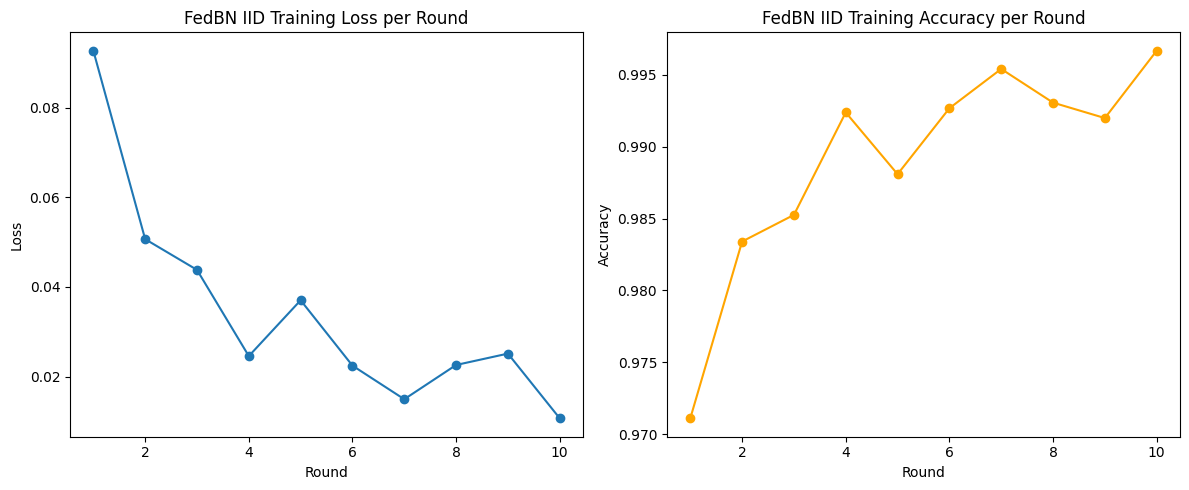

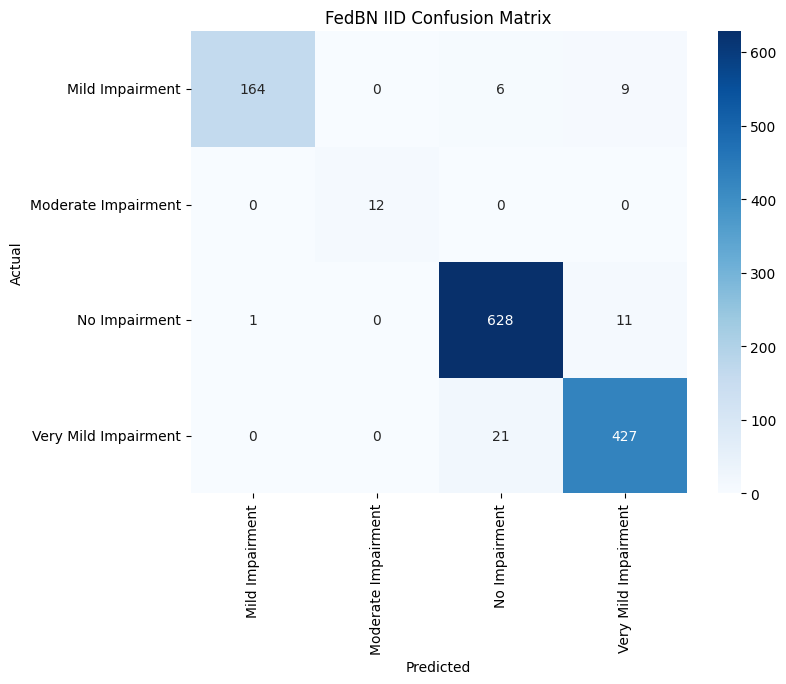

FedBN IID Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.99      0.92      0.95       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       0.96      0.98      0.97       640
Very Mild Impairment       0.96      0.95      0.95       448

            accuracy                           0.96      1279
           macro avg       0.98      0.96      0.97      1279
        weighted avg       0.96      0.96      0.96      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Adjusted hyperparameters
img_size = (224, 224)
batch_size = 16  # increased batch size
learning_rate = 5e-5  # smaller learning rate for more stable convergence
num_rounds = 10  # more rounds
local_epochs = 5 # increased local epochs
unfreeze_layers = 20
num_clients = 3

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

def split_data_iid(generator, num_clients):
    data = []
    labels = []
    generator.reset()
    for _ in range(len(generator)):
        x_batch, y_batch = next(generator)
        data.append(x_batch)
        labels.append(y_batch)
    if len(data) == 0:
        raise ValueError("No data found.")
    data = np.concatenate(data)
    labels = np.concatenate(labels)
    indices = np.arange(len(data))
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    split_data_arrays = np.array_split(data, num_clients)
    split_labels_arrays = np.array_split(labels, num_clients)
    client_data = []
    for i in range(num_clients):
        client_data.append((split_data_arrays[i], split_labels_arrays[i]))
    return client_data

client_data = split_data_iid(train_generator, num_clients)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    # Unfreeze more layers if needed
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def average_weights_fedbn(weights_list):
    ref_model = create_model()
    ref_weights = ref_model.get_weights()
    # Identify BN mean/var indices:
    bn_indices = []
    idx = 0
    for layer in ref_model.layers:
        w_layer = layer.get_weights()
        length = len(w_layer)
        if 'batch_normalization' in layer.name and length == 4:
            # gamma,beta,mean,var
            bn_indices.extend([idx+2, idx+3])
            idx += 4
        else:
            idx += length

    new_weights = []
    for w_i in range(len(ref_weights)):
        if w_i in bn_indices:
            # keep reference (no averaging for mean/var)
            new_weights.append(ref_weights[w_i])
        else:
            w_all = [weights_list[c][w_i] for c in range(len(weights_list))]
            new_weights.append(np.mean(w_all, axis=0))
    return new_weights

global_model = create_model()
global_model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
initial_weights = global_model.get_weights()

fedbn_iid_train_loss = []
fedbn_iid_train_accuracy = []
global_model.set_weights(initial_weights)

for round_num in range(num_rounds):
    print(f"FedBN IID - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    g_weights = global_model.get_weights()
    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(g_weights)
        client_model.compile(optimizer=Adam(learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])
        history = client_model.fit(client_X, client_y, epochs=local_epochs, batch_size=batch_size, verbose=0)

        local_weights_list.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    new_global_weights = average_weights_fedbn(local_weights_list)
    global_model.set_weights(new_global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedbn_iid_train_loss.append(avg_loss)
    fedbn_iid_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedBN IID Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedbn_iid_train_loss, fedbn_iid_train_accuracy, "FedBN IID")
plot_confusion_matrix(global_model, test_generator, classes, "FedBN IID")


# FedBN NON-IID on senario 1

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 99% 71.0M/71.5M [00:04<00:00, 20.4MB/s]
100% 71.5M/71.5M [00:04<00:00, 16.0MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FedBN Label Skew - Round 1/5
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.3999, Average Training Accuracy: 0.8455
FedBN Label Skew - Round 2/5
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.2922, Average Training Accuracy: 0.8892
Fed

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedBN Label Skew Test Accuracy: 85.07%


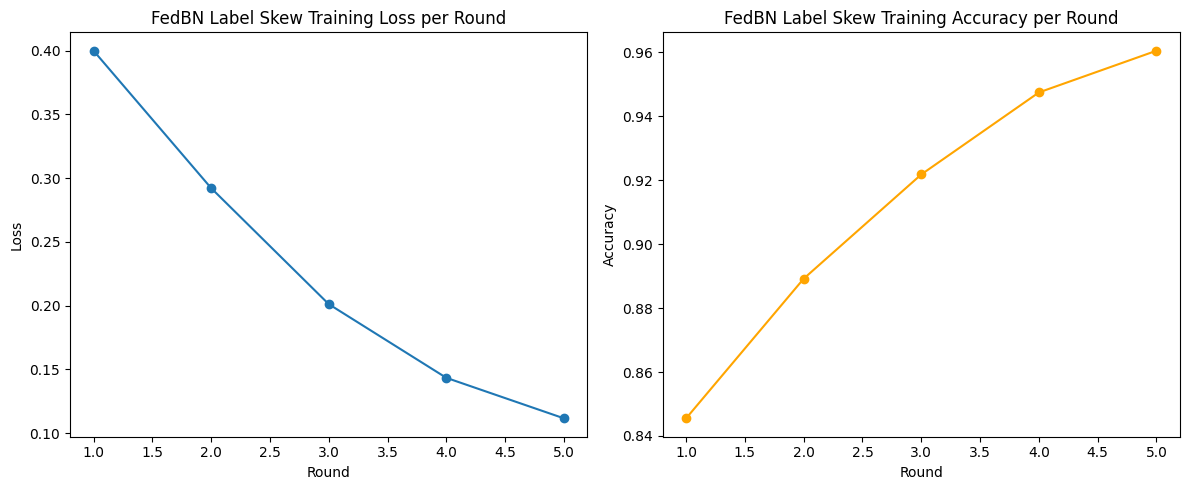

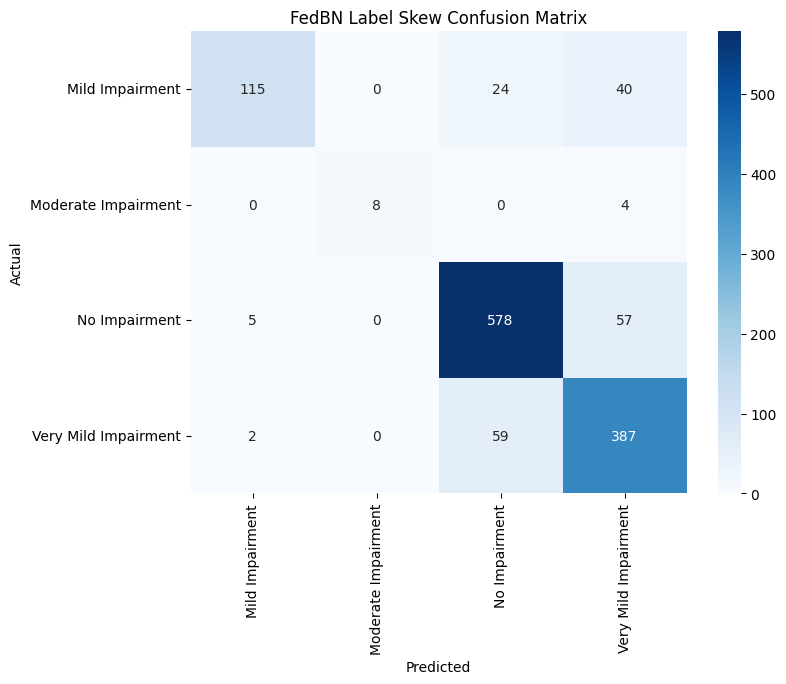

FedBN Label Skew Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.94      0.64      0.76       179
 Moderate Impairment       1.00      0.67      0.80        12
       No Impairment       0.87      0.90      0.89       640
Very Mild Impairment       0.79      0.86      0.83       448

            accuracy                           0.85      1279
           macro avg       0.90      0.77      0.82      1279
        weighted avg       0.86      0.85      0.85      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 5
local_epochs = 2
unfreeze_layers = 20
num_clients = 3

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_label_skew_data(X, y, classes, num_clients):
    c_mild = classes.index("Mild Impairment")
    c_mod = classes.index("Moderate Impairment")
    c_no = classes.index("No Impairment")
    c_very = classes.index("Very Mild Impairment")

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    def choose_frac(cls_ind, frac):
        count = int(len(cls_ind)*frac)
        chosen = np.random.choice(cls_ind, count, replace=False)
        remain = np.setdiff1d(cls_ind, chosen)
        return chosen, remain

    # label skewing as before:
    mild_chosen, class_indices[c_mild] = choose_frac(class_indices[c_mild], 0.7)
    others1 = np.concatenate([class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    others1_count = int(len(others1)*0.3) if len(others1)>0 else 0
    if others1_count>0:
        others1_chosen = np.random.choice(others1, others1_count, replace=False)
        for cc in [c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], others1_chosen[np.isin(others1_chosen, class_indices[cc])])
    else:
        others1_chosen = np.array([], dtype=int)
    client1_indices = np.concatenate([mild_chosen, others1_chosen])

    no_ = class_indices[c_no]
    mod_ = class_indices[c_mod]
    no_count = int(len(no_)*0.35) if len(no_)>0 else 0
    mod_count = int(len(mod_)*0.35) if len(mod_)>0 else 0
    no_chosen = np.random.choice(no_, no_count, replace=False) if no_count>0 else np.array([], dtype=int)
    mod_chosen = np.random.choice(mod_, mod_count, replace=False) if mod_count>0 else np.array([], dtype=int)
    class_indices[c_no] = np.setdiff1d(class_indices[c_no], no_chosen)
    class_indices[c_mod] = np.setdiff1d(class_indices[c_mod], mod_chosen)

    rem2 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem2_count = int(len(rem2)*0.3) if len(rem2)>0 else 0
    if rem2_count>0:
        rem2_chosen = np.random.choice(rem2, rem2_count, replace=False)
        for cc in [c_mild, c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], rem2_chosen[np.isin(rem2_chosen, class_indices[cc])])
    else:
        rem2_chosen = np.array([], dtype=int)
    client2_indices = np.concatenate([no_chosen, mod_chosen, rem2_chosen])

    very_ = class_indices[c_very]
    v_count = int(len(very_)*0.7) if len(very_)>0 else 0
    v_chosen = np.random.choice(very_, v_count, replace=False) if v_count>0 else np.array([], dtype=int)
    class_indices[c_very] = np.setdiff1d(class_indices[c_very], v_chosen)

    rem3 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem3_count = int(len(rem3)*0.3) if len(rem3)>0 else 0
    if rem3_count > len(rem3):
        rem3_count = len(rem3)
    rem3_chosen = np.random.choice(rem3, rem3_count, replace=False) if rem3_count>0 else np.array([], dtype=int)
    client3_indices = np.concatenate([v_chosen, rem3_chosen])

    for arr in [client1_indices, client2_indices, client3_indices]:
        np.random.shuffle(arr)

    return [(X[client1_indices], y[client1_indices]),
            (X[client2_indices], y[client2_indices]),
            (X[client3_indices], y[client3_indices])]

client_data = create_label_skew_data(X, y, classes, num_clients)

# FedBN Implementation:
# Key idea: When averaging weights, exclude BN statistics (mean/var)

def separate_bn_weights(weights):
    # Identify which weights are BN stats (moving mean, moving var) by layer name or shape
    # Typically BN layers have 4 sets of weights: gamma, beta, moving_mean, moving_variance
    # In get_weights() order for BN usually: gamma, beta, moving_mean, moving_variance
    # We'll separate them by pattern: if the shape is (X,) it's gamma/beta, if (X,) after that it's BN stats
    # Let's do a heuristic: BN layers have length=1 dimension. The moving_mean/var also have shape=(C,).
    # We'll store indices of such weights for exclusion from averaging if they are moving_mean/var.
    # Actually, we can just skip any weight that seems like a moving_mean or moving_variance by name:
    # But we don't have direct names from get_weights(). We'll rely on known pattern in ResNet:
    # After gamma, beta, next two arrays are mean and var. We know gamma, beta are trainable,
    # mean,var are not trainable. We can separate by checking tf.trainable_variables vs get_weights():
    return None  # We'll do a simpler approach below.

def average_weights_fedbn(weights_list):
    # We must only average non-BN statistics weights.
    # Strategy: We'll re-build a reference model and check which variables are trainable and which are BN stats.
    # Actually, BN gamma and beta are trainable. The difference: moving_mean, moving_variance are non-trainable.
    # We must not average moving_mean and moving_variance across clients, each keeps their own.
    # So we do:
    # 1) On first model: get all weights
    # 2) Identify which indices correspond to moving_mean, moving_variance
    #    Typically these are non-trainable weights in BN layers.

    ref_model = create_model()
    ref_weights = ref_model.get_weights()
    ref_vars = ref_model.variables
    # non-trainable vars in BN: usually last two arrays of BN are moving_mean and moving_variance
    # We'll identify them by checking ref_model.layers and their types:
    bn_indices = []
    idx = 0
    for layer in ref_model.layers:
        if 'batch_normalization' in layer.name:
            # BN layer has 4 weights: gamma, beta, moving_mean, moving_variance
            # In the order of get_weights() for BN layer: gamma, beta, moving_mean, moving_var
            bn_indices.extend([idx+2, idx+3]) # these are mean,var
            idx += 4
        else:
            # layers without BN (like Dense)
            # Dense: kernel,bias => 2 weights
            # If no BN inside base_model (frozen?), it's complicated but we know ResNet have many BN layers.
            # We'll count carefully. Actually, ResNet50 has many BN layers. We'll rely on pattern:
            # Each BN layer contributes exactly 4 weights in order.
            # Let's just do a general approach: after building model, we know total number of weights:
            idx += len(layer.get_weights())

    # bn_indices now hold global indices of moving mean/var that should not be averaged.
    # We'll average all indices except those in bn_indices.
    new_weights = []
    for w_i in range(len(ref_weights)):
        if w_i in bn_indices:
            # don't average, just take the first client's value (or we can skip)
            # Actually, for FedBN, we do not aggregate mean/var. Each client keeps its own.
            # On the server, we can pick the global model as first client's BN stats or keep original initialization.
            # Let's keep the first client's for global model to have a consistent BN.
            new_weights.append(ref_weights[w_i]) # or just keep server's old stats
        else:
            # average across clients
            w_all = [weights_list[c][w_i] for c in range(len(weights_list))]
            new_weights.append(np.mean(w_all, axis=0))
    return new_weights

global_model = create_model()
global_model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
initial_weights = global_model.get_weights()

fedbn_ls_train_loss = []
fedbn_ls_train_accuracy = []
global_model.set_weights(initial_weights)

for round_num in range(num_rounds):
    print(f"FedBN Label Skew - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    g_weights = global_model.get_weights()
    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        # set global weights to client
        client_model.set_weights(g_weights)
        client_model.compile(optimizer=Adam(learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])
        history = client_model.fit(client_X, client_y, epochs=local_epochs, batch_size=batch_size, verbose=0)

        local_weights_list.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    # average weights except BN mean/var
    new_global_weights = average_weights_fedbn(local_weights_list)
    global_model.set_weights(new_global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedbn_ls_train_loss.append(avg_loss)
    fedbn_ls_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedBN Label Skew Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedbn_ls_train_loss, fedbn_ls_train_accuracy, "FedBN Label Skew")
plot_confusion_matrix(global_model, test_generator, classes, "FedBN Label Skew")


# FedBN on senario 1 with high accuracy

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 98% 70.0M/71.5M [00:04<00:00, 24.6MB/s]
100% 71.5M/71.5M [00:04<00:00, 17.7MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FedBN Label Skew - Round 1/20
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0357, Average Training Accuracy: 0.9941
FedBN Label Skew - Round 2/20
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0117, Average Training Accuracy: 0.9974
F

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedBN Label Skew Test Accuracy: 95.00%


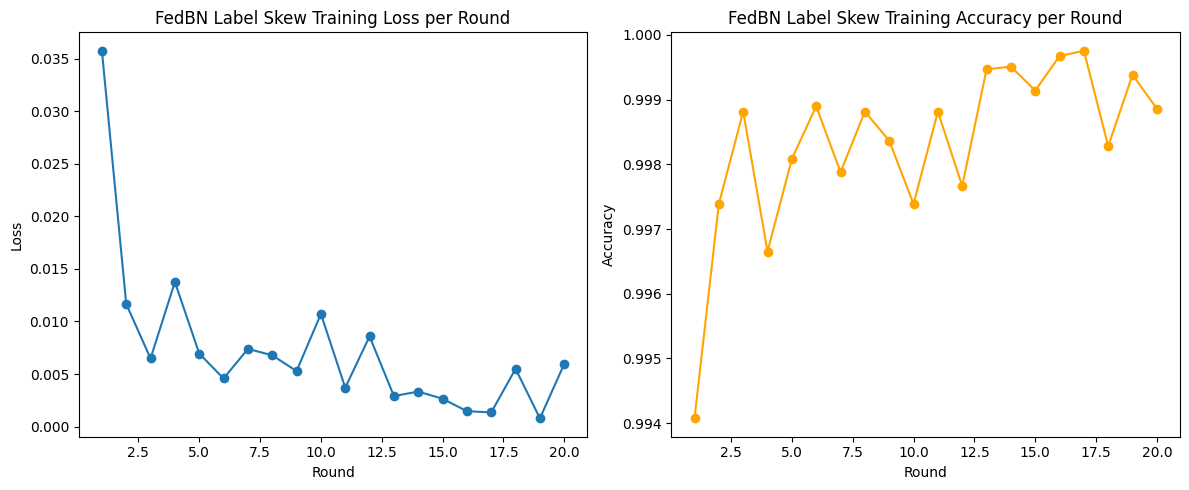

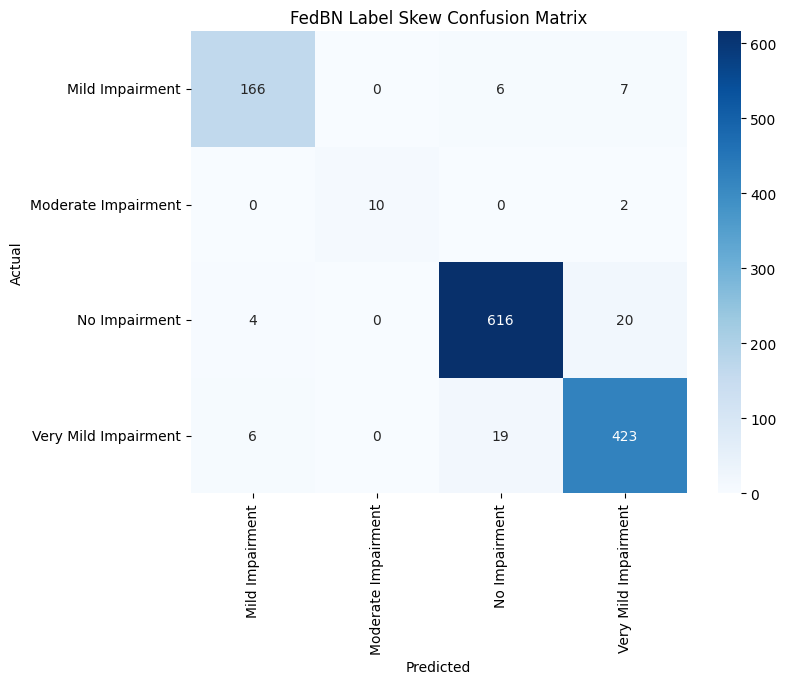

FedBN Label Skew Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.94      0.93      0.94       179
 Moderate Impairment       1.00      0.83      0.91        12
       No Impairment       0.96      0.96      0.96       640
Very Mild Impairment       0.94      0.94      0.94       448

            accuracy                           0.95      1279
           macro avg       0.96      0.92      0.94      1279
        weighted avg       0.95      0.95      0.95      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Adjusted hyperparameters for better performance in Non-IID
img_size = (224, 224)
batch_size = 16
learning_rate = 1e-5
num_rounds = 20
local_epochs = 10
unfreeze_layers = 40
num_clients = 3

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    # Freeze all layers first
    for layer in base_model.layers:
        layer.trainable = False
    # Unfreeze more layers for deeper adaptation
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_label_skew_data(X, y, classes, num_clients):
    c_mild = classes.index("Mild Impairment")
    c_mod = classes.index("Moderate Impairment")
    c_no = classes.index("No Impairment")
    c_very = classes.index("Very Mild Impairment")

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    def choose_frac(cls_ind, frac):
        count = int(len(cls_ind)*frac)
        chosen = np.random.choice(cls_ind, count, replace=False)
        remain = np.setdiff1d(cls_ind, chosen)
        return chosen, remain

    # Similar label skew as before
    mild_chosen, class_indices[c_mild] = choose_frac(class_indices[c_mild], 0.7)
    others1 = np.concatenate([class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    others1_count = int(len(others1)*0.3) if len(others1)>0 else 0
    if others1_count>0:
        others1_chosen = np.random.choice(others1, others1_count, replace=False)
        for cc in [c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], others1_chosen[np.isin(others1_chosen, class_indices[cc])])
    else:
        others1_chosen = np.array([], dtype=int)
    client1_indices = np.concatenate([mild_chosen, others1_chosen])

    no_ = class_indices[c_no]
    mod_ = class_indices[c_mod]
    no_count = int(len(no_)*0.35) if len(no_)>0 else 0
    mod_count = int(len(mod_)*0.35) if len(mod_)>0 else 0
    no_chosen = np.random.choice(no_, no_count, replace=False) if no_count>0 else np.array([], dtype=int)
    mod_chosen = np.random.choice(mod_, mod_count, replace=False) if mod_count>0 else np.array([], dtype=int)
    class_indices[c_no] = np.setdiff1d(class_indices[c_no], no_chosen)
    class_indices[c_mod] = np.setdiff1d(class_indices[c_mod], mod_chosen)

    rem2 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem2_count = int(len(rem2)*0.3) if len(rem2)>0 else 0
    if rem2_count>0:
        rem2_chosen = np.random.choice(rem2, rem2_count, replace=False)
        for cc in [c_mild, c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], rem2_chosen[np.isin(rem2_chosen, class_indices[cc])])
    else:
        rem2_chosen = np.array([], dtype=int)
    client2_indices = np.concatenate([no_chosen, mod_chosen, rem2_chosen])

    very_ = class_indices[c_very]
    v_count = int(len(very_)*0.7) if len(very_)>0 else 0
    v_chosen = np.random.choice(very_, v_count, replace=False) if v_count>0 else np.array([], dtype=int)
    class_indices[c_very] = np.setdiff1d(class_indices[c_very], v_chosen)

    rem3 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem3_count = int(len(rem3)*0.3) if len(rem3)>0 else 0
    if rem3_count > len(rem3):
        rem3_count = len(rem3)
    rem3_chosen = np.random.choice(rem3, rem3_count, replace=False) if rem3_count>0 else np.array([], dtype=int)
    client3_indices = np.concatenate([v_chosen, rem3_chosen])

    for arr in [client1_indices, client2_indices, client3_indices]:
        np.random.shuffle(arr)

    return [(X[client1_indices], y[client1_indices]),
            (X[client2_indices], y[client2_indices]),
            (X[client3_indices], y[client3_indices])]

client_data = create_label_skew_data(X, y, classes, num_clients)

def average_weights_fedbn(weights_list):
    ref_model = create_model()
    ref_weights = ref_model.get_weights()
    # Identify BN mean/var indices:
    bn_indices = []
    idx = 0
    for layer in ref_model.layers:
        w_layer = layer.get_weights()
        length = len(w_layer)
        if 'batch_normalization' in layer.name and length == 4:
            # gamma,beta,mean,var
            bn_indices.extend([idx+2, idx+3])
            idx += 4
        else:
            idx += length

    new_weights = []
    for w_i in range(len(ref_weights)):
        if w_i in bn_indices:
            # BN mean/var not averaged
            new_weights.append(ref_weights[w_i])
        else:
            w_all = [weights_list[c][w_i] for c in range(len(weights_list))]
            new_weights.append(np.mean(w_all, axis=0))
    return new_weights

global_model = create_model()
global_model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
initial_weights = global_model.get_weights()

fedbn_ls_train_loss = []
fedbn_ls_train_accuracy = []
global_model.set_weights(initial_weights)

for round_num in range(num_rounds):
    print(f"FedBN Label Skew - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    g_weights = global_model.get_weights()
    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(g_weights)
        client_model.compile(optimizer=Adam(learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])
        history = client_model.fit(client_X, client_y, epochs=local_epochs, batch_size=batch_size, verbose=0)

        local_weights_list.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    new_global_weights = average_weights_fedbn(local_weights_list)
    global_model.set_weights(new_global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedbn_ls_train_loss.append(avg_loss)
    fedbn_ls_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedBN Label Skew Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedbn_ls_train_loss, fedbn_ls_train_accuracy, "FedBN Label Skew")
plot_confusion_matrix(global_model, test_generator, classes, "FedBN Label Skew")


# FedBN Dirichlet(senario 2 ) with hogh accuracy

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 98% 70.0M/71.5M [00:04<00:00, 24.4MB/s]
100% 71.5M/71.5M [00:04<00:00, 17.7MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FedBN Dirichlet - Round 1/20
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0229, Average Training Accuracy: 0.9957
FedBN Dirichlet - Round 2/20
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0097, Average Training Accuracy: 0.9982
Fed

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedBN Dirichlet Test Accuracy: 96.09%


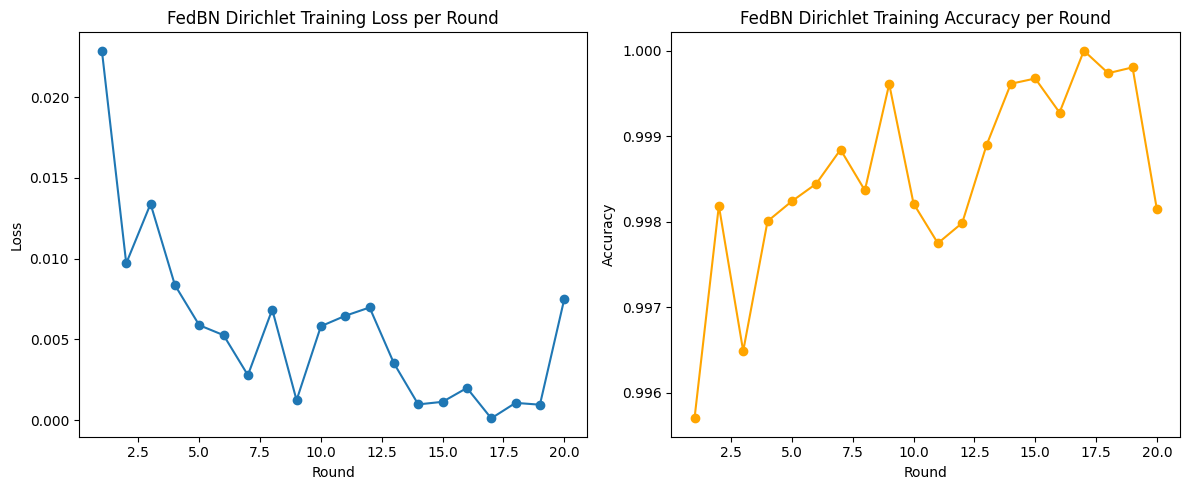

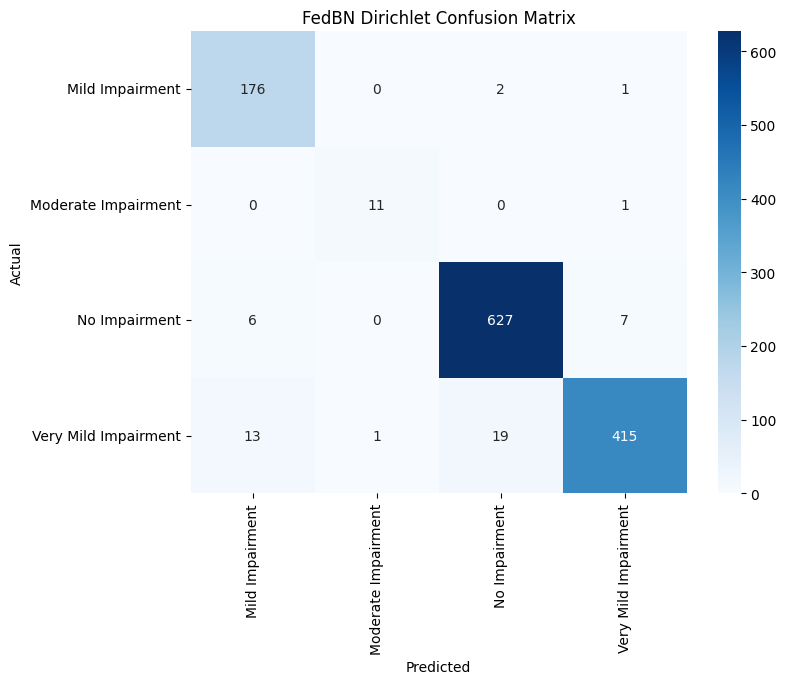

FedBN Dirichlet Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.90      0.98      0.94       179
 Moderate Impairment       0.92      0.92      0.92        12
       No Impairment       0.97      0.98      0.97       640
Very Mild Impairment       0.98      0.93      0.95       448

            accuracy                           0.96      1279
           macro avg       0.94      0.95      0.95      1279
        weighted avg       0.96      0.96      0.96      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from numpy.random import dirichlet

# Same hyperparams as Label Skew scenario
img_size = (224, 224)
batch_size = 16
learning_rate = 1e-5
num_rounds = 20
local_epochs = 10
unfreeze_layers = 40
num_clients = 3
alpha = 0.5  # Dirichlet parameter

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=0.5):
    client_data = [[] for _ in range(num_clients)]
    client_labels = [[] for _ in range(num_clients)]

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    for cls_idx in range(len(classes)):
        cls_inds = class_indices[cls_idx]
        np.random.shuffle(cls_inds)
        n = len(cls_inds)
        proportions = dirichlet([alpha]*num_clients)
        counts = (proportions * n).astype(int)
        diff = n - np.sum(counts)
        if diff > 0:
            counts[np.argmax(counts)] += diff

        start = 0
        for c in range(num_clients):
            c_count = counts[c]
            c_inds = cls_inds[start:start+c_count]
            start += c_count
            client_data[c].append(X[c_inds])
            client_labels[c].append(y[c_inds])

    final_clients = []
    for c in range(num_clients):
        X_c = np.concatenate(client_data[c])
        y_c = np.concatenate(client_labels[c])
        inds = np.arange(len(X_c))
        np.random.shuffle(inds)
        X_c = X_c[inds]
        y_c = y_c[inds]
        final_clients.append((X_c, y_c))
    return final_clients

client_data = create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=alpha)

def average_weights_fedbn(weights_list):
    ref_model = create_model()
    ref_weights = ref_model.get_weights()
    bn_indices = []
    idx = 0
    for layer in ref_model.layers:
        w_layer = layer.get_weights()
        length = len(w_layer)
        if 'batch_normalization' in layer.name and length == 4:
            bn_indices.extend([idx+2, idx+3])
            idx += 4
        else:
            idx += length

    new_weights = []
    for w_i in range(len(ref_weights)):
        if w_i in bn_indices:
            new_weights.append(ref_weights[w_i])
        else:
            w_all = [weights_list[c][w_i] for c in range(len(weights_list))]
            new_weights.append(np.mean(w_all, axis=0))
    return new_weights

global_model = create_model()
global_model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
initial_weights = global_model.get_weights()

fedbn_dirichlet_train_loss = []
fedbn_dirichlet_train_accuracy = []
global_model.set_weights(initial_weights)

for round_num in range(num_rounds):
    print(f"FedBN Dirichlet - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    g_weights = global_model.get_weights()
    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(g_weights)
        client_model.compile(optimizer=Adam(learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])
        history = client_model.fit(client_X, client_y, epochs=local_epochs, batch_size=batch_size, verbose=0)

        local_weights_list.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    new_global_weights = average_weights_fedbn(local_weights_list)
    global_model.set_weights(new_global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedbn_dirichlet_train_loss.append(avg_loss)
    fedbn_dirichlet_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedBN Dirichlet Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedbn_dirichlet_train_loss, fedbn_dirichlet_train_accuracy, "FedBN Dirichlet")
plot_confusion_matrix(global_model, test_generator, classes, "FedBN Dirichlet")


# FedBN IID with High accuracy

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 91% 65.0M/71.5M [00:00<00:00, 109MB/s]
100% 71.5M/71.5M [00:00<00:00, 115MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
FedBN IID - Round 1/20
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0280, Average Training Accuracy: 0.9941
FedBN IID - Round 2/20
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0175, Average Training Accuracy: 0.9952
FedBN IID - Round

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedBN IID Test Accuracy: 97.42%


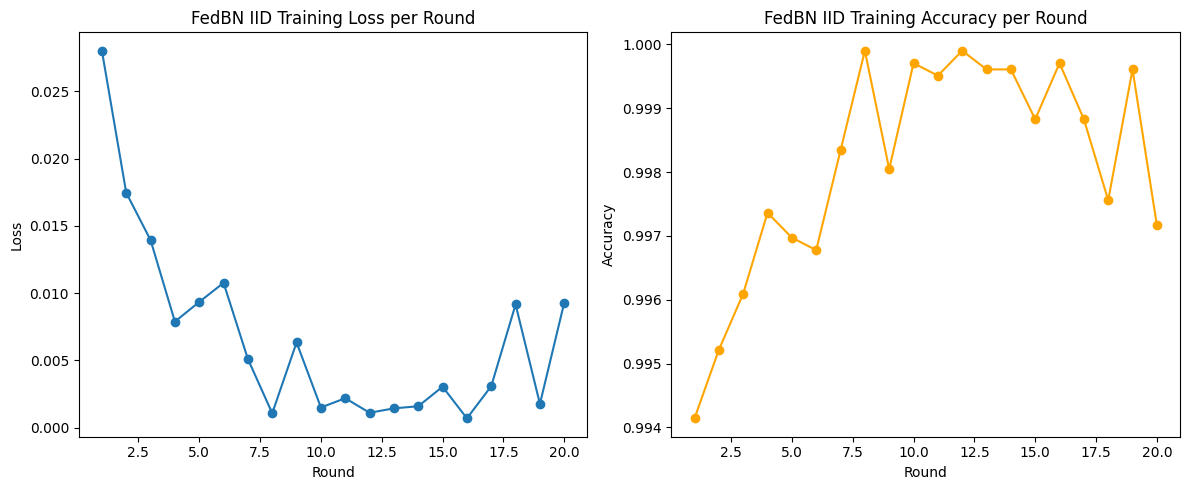

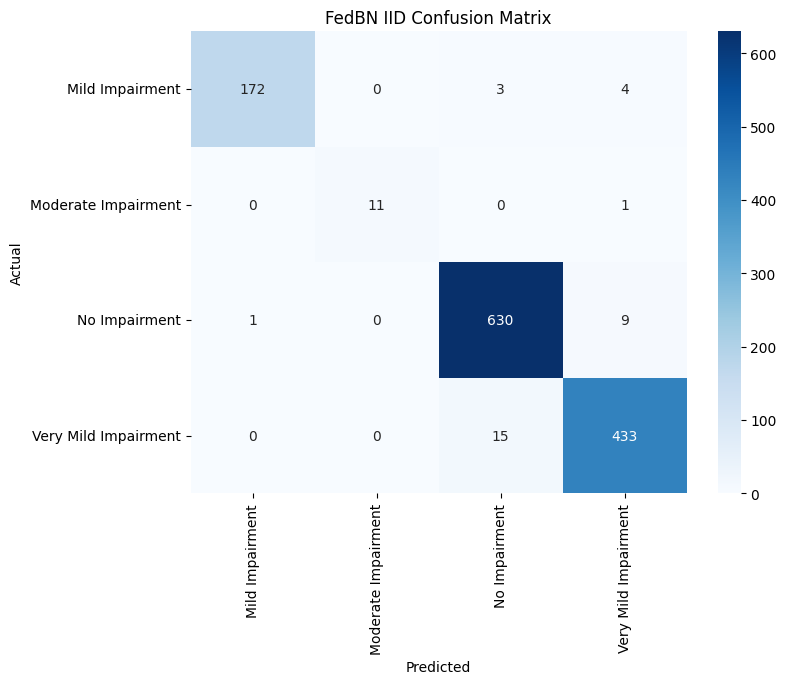

FedBN IID Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.99      0.96      0.98       179
 Moderate Impairment       1.00      0.92      0.96        12
       No Impairment       0.97      0.98      0.98       640
Very Mild Impairment       0.97      0.97      0.97       448

            accuracy                           0.97      1279
           macro avg       0.98      0.96      0.97      1279
        weighted avg       0.97      0.97      0.97      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Adjusted hyperparameters for optimal performance in IID
img_size = (224, 224)
batch_size = 16
learning_rate = 1e-5
num_rounds = 20
local_epochs = 10
unfreeze_layers = 40
num_clients = 3

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def split_iid_data(X, y, num_clients):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split_data = np.array_split(indices, num_clients)
    client_data = []
    for indices in split_data:
        client_data.append((X[indices], y[indices]))
    return client_data

client_data = split_iid_data(X, y, num_clients)

def average_weights_fedbn(weights_list):
    ref_model = create_model()
    ref_weights = ref_model.get_weights()
    bn_indices = []
    idx = 0
    for layer in ref_model.layers:
        w_layer = layer.get_weights()
        length = len(w_layer)
        if 'batch_normalization' in layer.name and length == 4:
            bn_indices.extend([idx+2, idx+3])
            idx += 4
        else:
            idx += length

    new_weights = []
    for w_i in range(len(ref_weights)):
        if w_i in bn_indices:
            new_weights.append(ref_weights[w_i])
        else:
            w_all = [weights_list[c][w_i] for c in range(len(weights_list))]
            new_weights.append(np.mean(w_all, axis=0))
    return new_weights

global_model = create_model()
global_model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
initial_weights = global_model.get_weights()

fedbn_iid_train_loss = []
fedbn_iid_train_accuracy = []
global_model.set_weights(initial_weights)

for round_num in range(num_rounds):
    print(f"FedBN IID - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    g_weights = global_model.get_weights()
    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(g_weights)
        client_model.compile(optimizer=Adam(learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])
        history = client_model.fit(client_X, client_y, epochs=local_epochs, batch_size=batch_size, verbose=0)

        local_weights_list.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    new_global_weights = average_weights_fedbn(local_weights_list)
    global_model.set_weights(new_global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedbn_iid_train_loss.append(avg_loss)
    fedbn_iid_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedBN IID Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedbn_iid_train_loss, fedbn_iid_train_accuracy, "FedBN IID")
plot_confusion_matrix(global_model, test_generator, classes, "FedBN IID")


# FedBN on Senario 2 NON-IID

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 99% 71.0M/71.5M [00:04<00:00, 21.4MB/s]
100% 71.5M/71.5M [00:04<00:00, 17.2MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FedBN Dirichlet - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.2532, Average Training Accuracy: 0.8999
FedBN Dirichlet - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0884, Average Training Accuracy: 0.9714
Fed

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedBN Dirichlet Test Accuracy: 87.33%


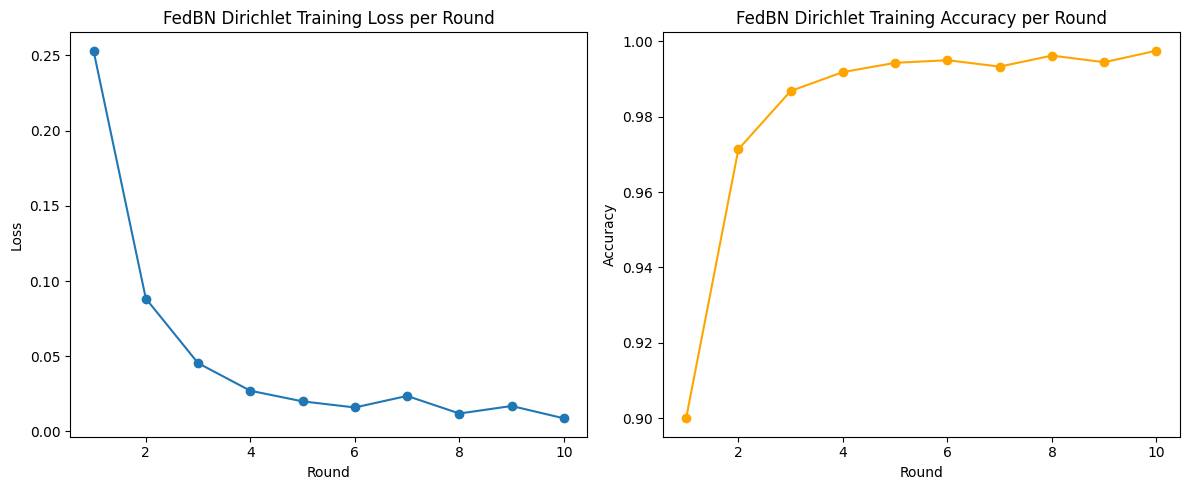

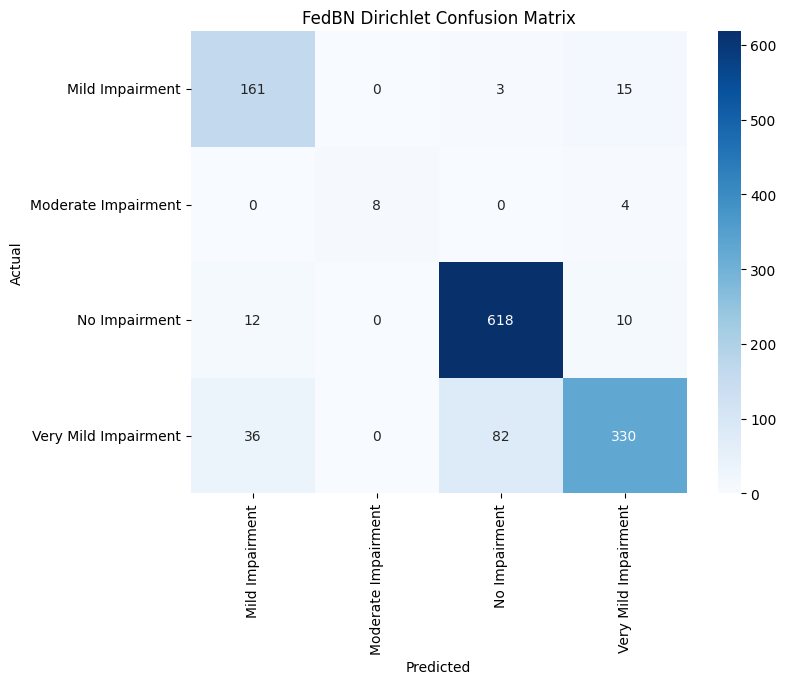

FedBN Dirichlet Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.77      0.90      0.83       179
 Moderate Impairment       1.00      0.67      0.80        12
       No Impairment       0.88      0.97      0.92       640
Very Mild Impairment       0.92      0.74      0.82       448

            accuracy                           0.87      1279
           macro avg       0.89      0.82      0.84      1279
        weighted avg       0.88      0.87      0.87      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from numpy.random import dirichlet

# Same hyperparams as Label Skew scenario
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-5
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3
alpha = 0.5  # Dirichlet parameter

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=0.5):
    client_data = [[] for _ in range(num_clients)]
    client_labels = [[] for _ in range(num_clients)]

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    for cls_idx in range(len(classes)):
        cls_inds = class_indices[cls_idx]
        np.random.shuffle(cls_inds)
        n = len(cls_inds)
        proportions = dirichlet([alpha]*num_clients)
        counts = (proportions * n).astype(int)
        diff = n - np.sum(counts)
        if diff > 0:
            counts[np.argmax(counts)] += diff

        start = 0
        for c in range(num_clients):
            c_count = counts[c]
            c_inds = cls_inds[start:start+c_count]
            start += c_count
            client_data[c].append(X[c_inds])
            client_labels[c].append(y[c_inds])

    final_clients = []
    for c in range(num_clients):
        X_c = np.concatenate(client_data[c])
        y_c = np.concatenate(client_labels[c])
        inds = np.arange(len(X_c))
        np.random.shuffle(inds)
        X_c = X_c[inds]
        y_c = y_c[inds]
        final_clients.append((X_c, y_c))
    return final_clients

client_data = create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=alpha)

def average_weights_fedbn(weights_list):
    ref_model = create_model()
    ref_weights = ref_model.get_weights()
    bn_indices = []
    idx = 0
    for layer in ref_model.layers:
        w_layer = layer.get_weights()
        length = len(w_layer)
        if 'batch_normalization' in layer.name and length == 4:
            bn_indices.extend([idx+2, idx+3])
            idx += 4
        else:
            idx += length

    new_weights = []
    for w_i in range(len(ref_weights)):
        if w_i in bn_indices:
            new_weights.append(ref_weights[w_i])
        else:
            w_all = [weights_list[c][w_i] for c in range(len(weights_list))]
            new_weights.append(np.mean(w_all, axis=0))
    return new_weights

global_model = create_model()
global_model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
initial_weights = global_model.get_weights()

fedbn_dirichlet_train_loss = []
fedbn_dirichlet_train_accuracy = []
global_model.set_weights(initial_weights)

for round_num in range(num_rounds):
    print(f"FedBN Dirichlet - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    g_weights = global_model.get_weights()
    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(g_weights)
        client_model.compile(optimizer=Adam(learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])
        history = client_model.fit(client_X, client_y, epochs=local_epochs, batch_size=batch_size, verbose=0)

        local_weights_list.append(client_model.get_weights())
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    new_global_weights = average_weights_fedbn(local_weights_list)
    global_model.set_weights(new_global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedbn_dirichlet_train_loss.append(avg_loss)
    fedbn_dirichlet_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedBN Dirichlet Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedbn_dirichlet_train_loss, fedbn_dirichlet_train_accuracy, "FedBN Dirichlet")
plot_confusion_matrix(global_model, test_generator, classes, "FedBN Dirichlet")


# FedDWA NON-IID senario 1

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 78% 56.0M/71.5M [00:00<00:00, 188MB/s]
100% 71.5M/71.5M [00:00<00:00, 182MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
FedDWA Label Skew - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1657, Average Training Accuracy: 0.9394
FedDWA Label Skew - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0879, Average Training Accuracy: 0.9672
F

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedDWA Label Skew Test Accuracy: 83.58%


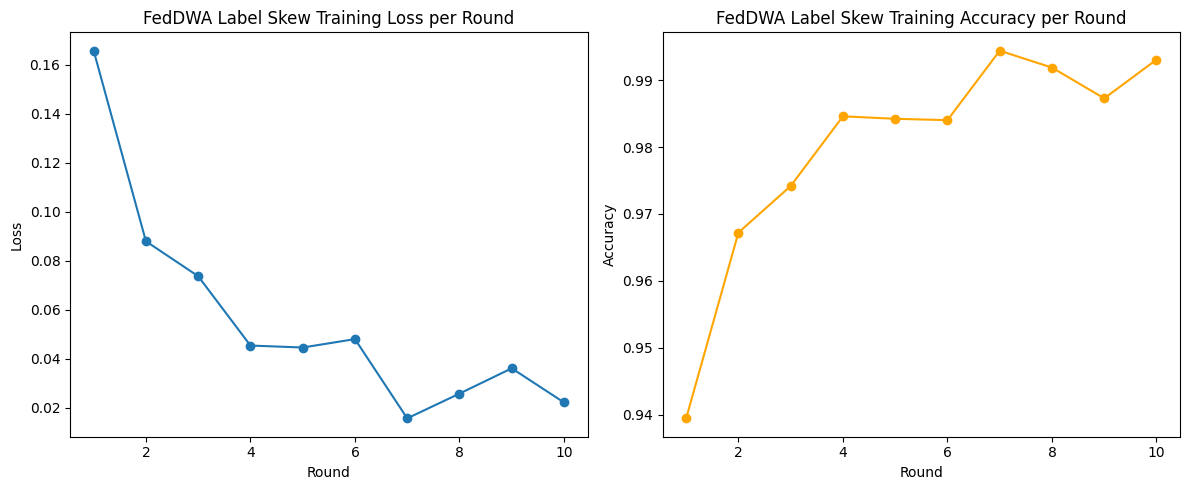

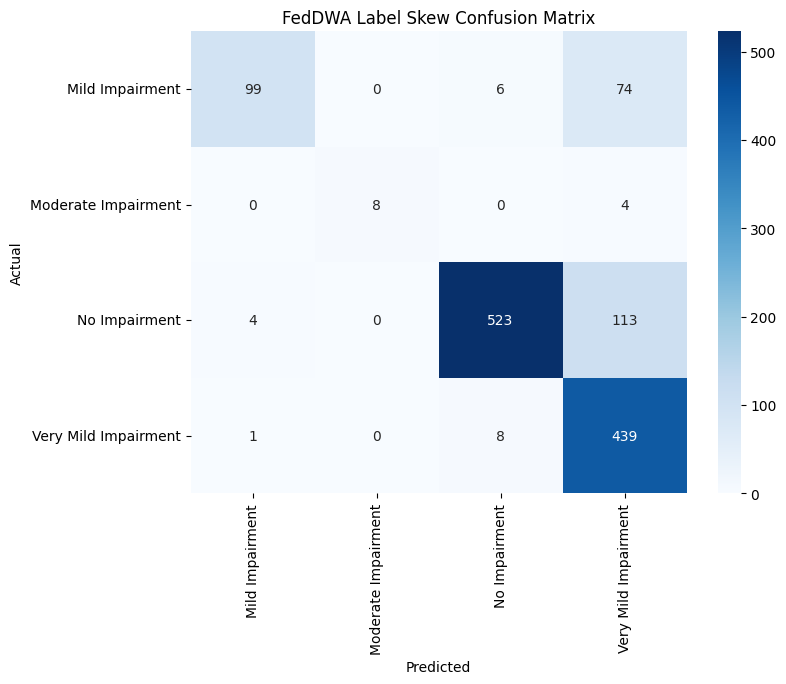

FedDWA Label Skew Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.95      0.55      0.70       179
 Moderate Impairment       1.00      0.67      0.80        12
       No Impairment       0.97      0.82      0.89       640
Very Mild Impairment       0.70      0.98      0.81       448

            accuracy                           0.84      1279
           macro avg       0.91      0.75      0.80      1279
        weighted avg       0.87      0.84      0.84      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters (same as before for fairness)
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_label_skew_data(X, y, classes, num_clients):
    c_mild = classes.index("Mild Impairment")
    c_mod = classes.index("Moderate Impairment")
    c_no = classes.index("No Impairment")
    c_very = classes.index("Very Mild Impairment")

    class_indices = {}
    for i in range(len(classes)):
        class_indices[i] = np.where(y == i)[0]

    def choose_frac(cls_ind, frac):
        count = int(len(cls_ind)*frac)
        chosen = np.random.choice(cls_ind, count, replace=False)
        remain = np.setdiff1d(cls_ind, chosen)
        return chosen, remain

    # Label skew as before:
    mild_chosen, class_indices[c_mild] = choose_frac(class_indices[c_mild], 0.7)
    others1 = np.concatenate([class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    others1_count = int(len(others1)*0.3) if len(others1)>0 else 0
    if others1_count>0:
        others1_chosen = np.random.choice(others1, others1_count, replace=False)
        for cc in [c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], others1_chosen[np.isin(others1_chosen, class_indices[cc])])
    else:
        others1_chosen = np.array([], dtype=int)
    client1_indices = np.concatenate([mild_chosen, others1_chosen])

    no_ = class_indices[c_no]
    mod_ = class_indices[c_mod]
    no_count = int(len(no_)*0.35) if len(no_)>0 else 0
    mod_count = int(len(mod_)*0.35) if len(mod_)>0 else 0
    no_chosen = np.random.choice(no_, no_count, replace=False) if no_count>0 else np.array([], dtype=int)
    mod_chosen = np.random.choice(mod_, mod_count, replace=False) if mod_count>0 else np.array([], dtype=int)
    class_indices[c_no] = np.setdiff1d(class_indices[c_no], no_chosen)
    class_indices[c_mod] = np.setdiff1d(class_indices[c_mod], mod_chosen)

    rem2 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem2_count = int(len(rem2)*0.3) if len(rem2)>0 else 0
    if rem2_count>0:
        rem2_chosen = np.random.choice(rem2, rem2_count, replace=False)
        for cc in [c_mild, c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], rem2_chosen[np.isin(rem2_chosen, class_indices[cc])])
    else:
        rem2_chosen = np.array([], dtype=int)
    client2_indices = np.concatenate([no_chosen, mod_chosen, rem2_chosen])

    very_ = class_indices[c_very]
    v_count = int(len(very_)*0.7) if len(very_)>0 else 0
    v_chosen = np.random.choice(very_, v_count, replace=False) if v_count>0 else np.array([], dtype=int)
    class_indices[c_very] = np.setdiff1d(class_indices[c_very], v_chosen)

    rem3 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem3_count = int(len(rem3)*0.3) if len(rem3)>0 else 0
    if rem3_count > len(rem3):
        rem3_count = len(rem3)
    rem3_chosen = np.random.choice(rem3, rem3_count, replace=False) if rem3_count>0 else np.array([], dtype=int)
    client3_indices = np.concatenate([v_chosen, rem3_chosen])

    for arr in [client1_indices, client2_indices, client3_indices]:
        np.random.shuffle(arr)

    return [(X[client1_indices], y[client1_indices]),
            (X[client2_indices], y[client2_indices]),
            (X[client3_indices], y[client3_indices])]

client_data = create_label_skew_data(X, y, classes, num_clients)

global_model = create_model()
global_model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
initial_weights = global_model.get_weights()

feddwa_ls_train_loss = []
feddwa_ls_train_accuracy = []
global_model.set_weights(initial_weights)

for round_num in range(num_rounds):
    print(f"FedDWA Label Skew - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    g_weights = global_model.get_weights()
    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(g_weights)
        client_model.compile(optimizer=Adam(learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])
        history = client_model.fit(client_X, client_y, epochs=local_epochs, batch_size=batch_size, verbose=0)
        final_weights = client_model.get_weights()
        local_weights_list.append(final_weights)
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    # Compute weights for aggregation based on inverse loss
    # If loss is very small -> weight is high
    # To avoid division by zero, add a small epsilon
    epsilon = 1e-8
    inv_losses = [1.0/(l+epsilon) for l in local_losses]
    sum_inv = sum(inv_losses)
    client_weights = [w/sum_inv for w in inv_losses]

    new_global_weights = []
    for w_i in range(len(g_weights)):
        weighted_sum = np.zeros_like(g_weights[w_i])
        for c_idx in range(num_clients):
            weighted_sum += local_weights_list[c_idx][w_i] * client_weights[c_idx]
        new_global_weights.append(weighted_sum)

    global_model.set_weights(new_global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    feddwa_ls_train_loss.append(avg_loss)
    feddwa_ls_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedDWA Label Skew Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(feddwa_ls_train_loss, feddwa_ls_train_accuracy, "FedDWA Label Skew")
plot_confusion_matrix(global_model, test_generator, classes, "FedDWA Label Skew")


# FedDWA on senario 2 NON-IID

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
100% 71.5M/71.5M [00:02<00:00, 43.7MB/s]
100% 71.5M/71.5M [00:02<00:00, 31.6MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
FedDWA Dirichlet - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1532, Average Training Accuracy: 0.9454
FedDWA Dirichlet - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0653, Average Training Accuracy: 0.9764
F

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedDWA Dirichlet Test Accuracy: 82.41%


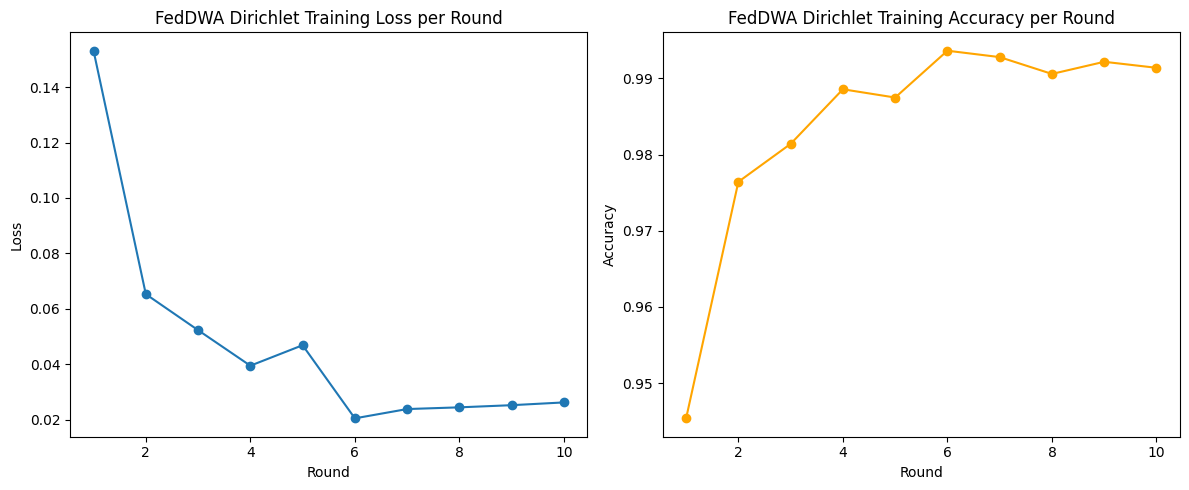

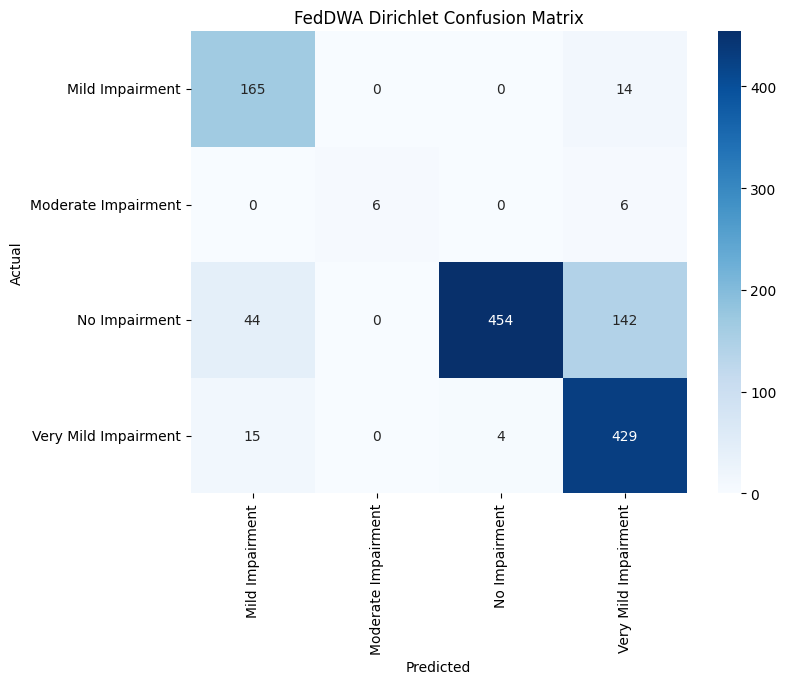

FedDWA Dirichlet Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.74      0.92      0.82       179
 Moderate Impairment       1.00      0.50      0.67        12
       No Impairment       0.99      0.71      0.83       640
Very Mild Impairment       0.73      0.96      0.83       448

            accuracy                           0.82      1279
           macro avg       0.86      0.77      0.78      1279
        weighted avg       0.86      0.82      0.82      1279



In [ ]:


!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from numpy.random import dirichlet

# Same hyperparams
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3
alpha = 0.5

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=0.5):
    client_data = [[] for _ in range(num_clients)]
    client_labels = [[] for _ in range(num_clients)]

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    for cls_idx in range(len(classes)):
        cls_inds = class_indices[cls_idx]
        np.random.shuffle(cls_inds)
        n = len(cls_inds)
        proportions = dirichlet([alpha]*num_clients)
        counts = (proportions * n).astype(int)
        diff = n - np.sum(counts)
        if diff > 0:
            counts[np.argmax(counts)] += diff

        start = 0
        for c in range(num_clients):
            c_count = counts[c]
            c_inds = cls_inds[start:start+c_count]
            start += c_count
            client_data[c].append(X[c_inds])
            client_labels[c].append(y[c_inds])

    final_clients = []
    for c in range(num_clients):
        X_c = np.concatenate(client_data[c])
        y_c = np.concatenate(client_labels[c])
        inds = np.arange(len(X_c))
        np.random.shuffle(inds)
        X_c = X_c[inds]
        y_c = y_c[inds]
        final_clients.append((X_c, y_c))
    return final_clients

client_data = create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=alpha)

global_model = create_model()
global_model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
initial_weights = global_model.get_weights()

feddwa_dirichlet_train_loss = []
feddwa_dirichlet_train_accuracy = []
global_model.set_weights(initial_weights)

for round_num in range(num_rounds):
    print(f"FedDWA Dirichlet - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    g_weights = global_model.get_weights()
    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(g_weights)
        client_model.compile(optimizer=Adam(learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])
        history = client_model.fit(client_X, client_y, epochs=local_epochs, batch_size=batch_size, verbose=0)
        final_weights = client_model.get_weights()
        local_weights_list.append(final_weights)
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    epsilon = 1e-8
    inv_losses = [1.0/(l+epsilon) for l in local_losses]
    sum_inv = sum(inv_losses)
    client_weights = [w/sum_inv for w in inv_losses]

    new_global_weights = []
    for w_i in range(len(g_weights)):
        weighted_sum = np.zeros_like(g_weights[w_i])
        for c_idx in range(num_clients):
            weighted_sum += local_weights_list[c_idx][w_i] * client_weights[c_idx]
        new_global_weights.append(weighted_sum)

    global_model.set_weights(new_global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    feddwa_dirichlet_train_loss.append(avg_loss)
    feddwa_dirichlet_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate)
global_model.set_weights(global_model.get_weights())
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedDWA Dirichlet Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(feddwa_dirichlet_train_loss, feddwa_dirichlet_train_accuracy, "FedDWA Dirichlet")
plot_confusion_matrix(global_model, test_generator, classes, "FedDWA Dirichlet")


# FedDWA IID senario

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 99% 71.0M/71.5M [00:02<00:00, 41.2MB/s]
100% 71.5M/71.5M [00:02<00:00, 31.6MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
FedDWA IID - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1731, Average Training Accuracy: 0.9348
FedDWA IID - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0872, Average Training Accuracy: 0.9699
FedDWA IID - 

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FedDWA IID Test Accuracy: 95.23%


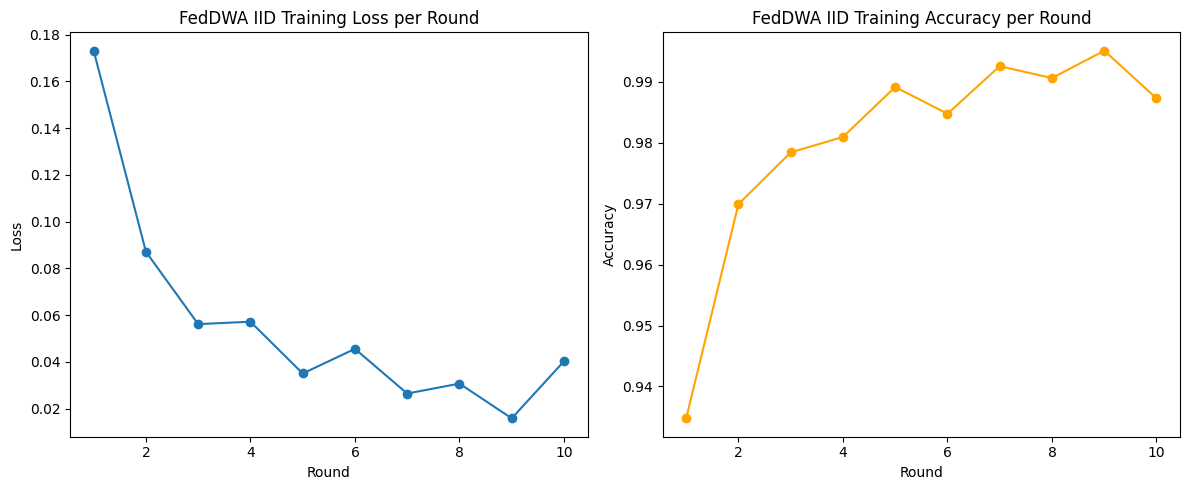

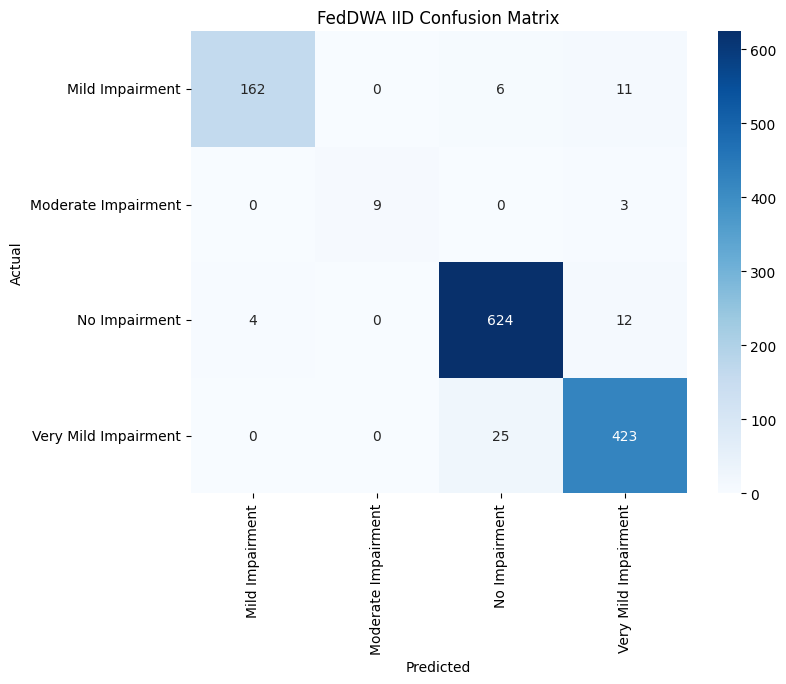

FedDWA IID Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.98      0.91      0.94       179
 Moderate Impairment       1.00      0.75      0.86        12
       No Impairment       0.95      0.97      0.96       640
Very Mild Impairment       0.94      0.94      0.94       448

            accuracy                           0.95      1279
           macro avg       0.97      0.89      0.93      1279
        weighted avg       0.95      0.95      0.95      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Parameters (same as before for fairness)
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_iid_data(X, y, num_clients):
    # IID partition: just split dataset into equal parts randomly
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # Divide equally among clients
    split_size = len(X) // num_clients
    clients_data = []
    for i in range(num_clients):
        start = i * split_size
        end = (i+1) * split_size if i < num_clients-1 else len(X)
        clients_data.append((X[start:end], y[start:end]))
    return clients_data

client_data = create_iid_data(X, y, num_clients)

global_model = create_model()
global_model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
initial_weights = global_model.get_weights()

feddwa_iid_train_loss = []
feddwa_iid_train_accuracy = []
global_model.set_weights(initial_weights)

for round_num in range(num_rounds):
    print(f"FedDWA IID - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    g_weights = global_model.get_weights()
    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(g_weights)
        client_model.compile(optimizer=Adam(learning_rate),
                             loss='sparse_categorical_crossentropy',
                             metrics=['accuracy'])
        history = client_model.fit(client_X, client_y, epochs=local_epochs, batch_size=batch_size, verbose=0)
        final_weights = client_model.get_weights()
        local_weights_list.append(final_weights)
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

    # Compute weights for aggregation based on inverse loss
    epsilon = 1e-8
    inv_losses = [1.0/(l+epsilon) for l in local_losses]
    sum_inv = sum(inv_losses)
    client_weights = [w/sum_inv for w in inv_losses]

    new_global_weights = []
    for w_i in range(len(g_weights)):
        weighted_sum = np.zeros_like(g_weights[w_i])
        for c_idx in range(num_clients):
            weighted_sum += local_weights_list[c_idx][w_i] * client_weights[c_idx]
        new_global_weights.append(weighted_sum)

    global_model.set_weights(new_global_weights)

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    feddwa_iid_train_loss.append(avg_loss)
    feddwa_iid_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedDWA IID Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(feddwa_iid_train_loss, feddwa_iid_train_accuracy, "FedDWA IID")
plot_confusion_matrix(global_model, test_generator, classes, "FedDWA IID")


# Scaffold IID High Accuracy

In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

# Hyperparameters tuned for high accuracy
img_size = (224, 224)
batch_size = 16
learning_rate = 1e-5
num_rounds = 20
local_epochs = 10
unfreeze_layers = 40
num_clients = 3

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)

X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def split_iid_data(X, y, num_clients):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split_data = np.array_split(indices, num_clients)
    client_data = []
    for idx_arr in split_data:
        client_data.append((X[idx_arr], y[idx_arr]))
    return client_data

client_data = split_iid_data(X, y, num_clients)

# Scaffold Variables
def initialize_control_variates(model):
    # c (server) and c_i (clients)
    global_weights = model.get_weights()
    c = [np.zeros_like(w) for w in global_weights]
    c_i = [[np.zeros_like(w) for w in global_weights] for _ in range(num_clients)]
    return c, c_i

global_model = create_model()
global_model.compile(optimizer=Adam(learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
c, c_i = initialize_control_variates(global_model)

scaffold_iid_train_loss = []
scaffold_iid_train_accuracy = []
global_weights = global_model.get_weights()

for round_num in range(num_rounds):
    print(f"Scaffold IID - Round {round_num+1}/{num_rounds}")
    local_weights = []
    local_losses = []
    local_accuracies = []

    w_global = global_weights
    c_global = c

    for client_idx, (client_X, client_y) in enumerate(client_data):
        client_model = create_model()
        client_model.set_weights(w_global)
        client_optimizer = Adam(learning_rate=learning_rate)

        # Adjust updates: w_i^{t+1} = w_i^t - η∇f_i(w_i^t) + η(c - c_i)
        # We'll implement this by using a custom training loop or a hook in the optimizer.
        # For simplicity, we can approximate by modifying the loss function to incorporate (c - c_i),
        # but Scaffold typically modifies the gradient step. Here we do a manual step:

        # We'll run a few epochs and after each epoch adjust weights manually to simulate scaffold step.

        # Convert data to tf.data for custom loop
        dataset = tf.data.Dataset.from_tensor_slices((client_X, client_y)).batch(batch_size)

        w_local = client_model.get_weights()

        for epoch in range(local_epochs):
            # Normal training for one epoch
            client_model.compile(optimizer=client_optimizer,
                                 loss='sparse_categorical_crossentropy',
                                 metrics=['accuracy'])
            history = client_model.fit(dataset, epochs=1, verbose=0)
            last_acc = history.history['accuracy'][-1]
            last_loss = history.history['loss'][-1]

            # After one epoch, adjust weights with Scaffold correction:
            # w_i := w_i + η(c - c_i)
            # We'll do a small step in direction (c - c_i)

            w_local = client_model.get_weights()
            for i in range(len(w_local)):
                w_local[i] = w_local[i] + learning_rate * (c_global[i] - c_i[client_idx][i])
            client_model.set_weights(w_local)

        # After finishing local epochs:
        # Update c_i:
        # c_i := c_i + (1/η)(w_i^{t+1} - w^t)
        # w^t is w_global from this round start
        w_new = client_model.get_weights()
        for i in range(len(c_i[client_idx])):
            c_i[client_idx][i] = c_i[client_idx][i] + (1/learning_rate)*(w_new[i] - w_global[i])

        local_weights.append(w_new)
        local_losses.append(last_loss)
        local_accuracies.append(last_acc)

    # Aggregate weights:
    new_weights = []
    for weights_set in zip(*local_weights):
        new_weights.append(np.mean(weights_set, axis=0))

    # Update global weights:
    w_global = new_weights

    # Update c (server):
    # c := (1/N)∑ c_i
    new_c = []
    for i in range(len(c)):
        arr = [c_i[j][i] for j in range(num_clients)]
        new_c.append(np.mean(arr, axis=0))

    global_weights = w_global
    c = new_c

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    scaffold_iid_train_loss.append(avg_loss)
    scaffold_iid_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"Scaffold IID Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(scaffold_iid_train_loss, scaffold_iid_train_accuracy, "Scaffold IID")
plot_confusion_matrix(global_model, test_generator, classes, "Scaffold IID")


Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 91% 65.0M/71.5M [00:00<00:00, 92.9MB/s]
100% 71.5M/71.5M [00:00<00:00, 95.5MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Scaffold IID - Round 1/20
 Average Training Loss: 0.0100, Average Training Accuracy: 0.9996
Scaffold IID - Round 2/20
 Average Training Loss: 0.0618, Average Training Accuracy: 0.9819
Scaffold IID - Round 3/20


# FLGUard against Byzantine Attacks

Please upload your kaggle.json file (Kaggle API token).


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): ODbL-1.0
 96% 69.0M/71.5M [00:04<00:00, 24.5MB/s]
100% 71.5M/71.5M [00:04<00:00, 17.8MB/s]
Train folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Test folder structure:
'Mild Impairment'  'Moderate Impairment'  'No Impairment'  'Very Mild Impairment'
Found 10240 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.
Detected Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
All training data shape: (10240, 224, 224, 3) (10240,)
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
FLGuard IID + Byzantine - Round 1/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.1828, Average Training Accuracy: 0.9335
FLGuard IID + Byzantine - Round 2/10
 Client 1/3
 Client 2/3
 Client 3/3
 Average Training Loss: 0.0880, Average Training Accu

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


FLGuard IID + Byzantine Test Accuracy: 90.85%


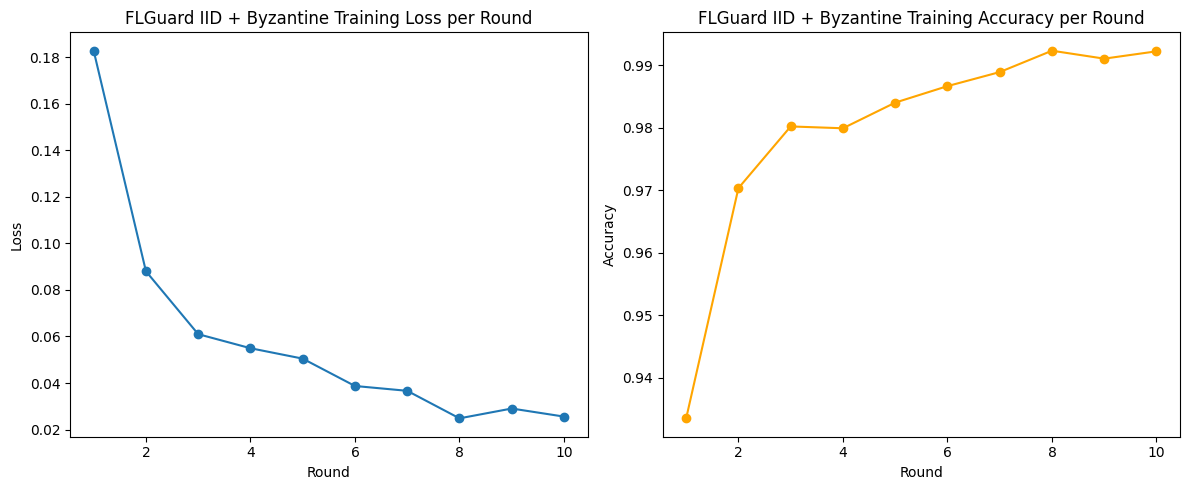

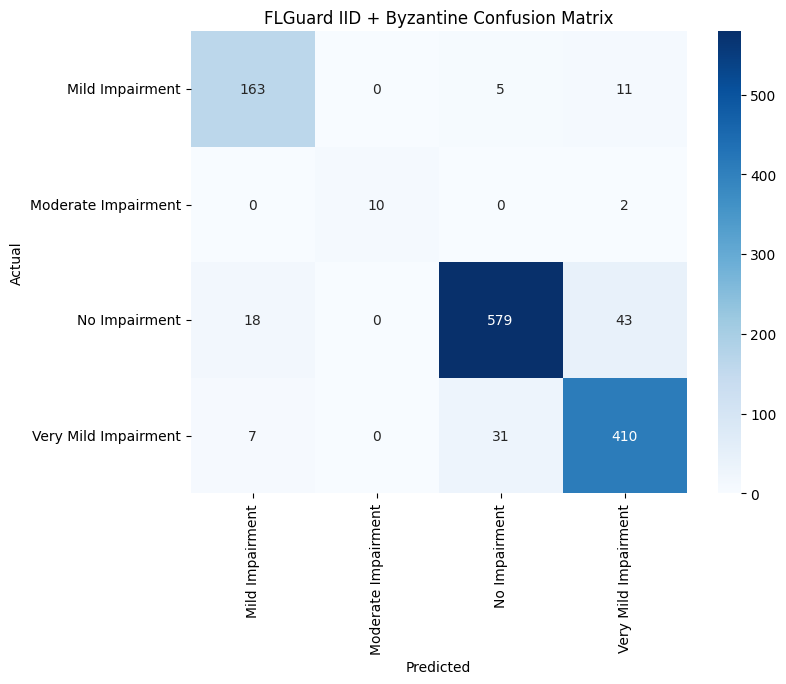

FLGuard IID + Byzantine Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.87      0.91      0.89       179
 Moderate Impairment       1.00      0.83      0.91        12
       No Impairment       0.94      0.90      0.92       640
Very Mild Impairment       0.88      0.92      0.90       448

            accuracy                           0.91      1279
           macro avg       0.92      0.89      0.90      1279
        weighted avg       0.91      0.91      0.91      1279



In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

np.random.seed(42)

# Parameters (same as previous scenarios for fair comparison)
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-4
num_rounds = 10
local_epochs = 5
unfreeze_layers = 20
num_clients = 3
mu = 0.01  # FedProx parameter

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_iid_data(X, y, num_clients):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    split_X = np.array_split(X, num_clients)
    split_y = np.array_split(y, num_clients)
    client_data = []
    for i in range(num_clients):
        client_data.append((split_X[i], split_y[i]))
    return client_data

def apply_byzantine_attack(local_weights):
    # Simple attack: negate all weights (fully byzantine)
    sabotaged = []
    for w in local_weights:
        sabotaged.append(-w)
    return sabotaged

# FLGuard aggregator:
# در اینجا ما یک روش ساده اعمال می‌کنیم:
# 1) فاصله بین آپدیت‌های کلاینت‌ها را محاسبه می‌کنیم.
# 2) آپدیتی که بیشترین انحراف را از دیگران دارد حذف می‌کنیم.
# 3) وزن‌های باقی‌مانده را میانگین می‌گیریم.

def flguard_aggregate(local_weights_list):
    # local_weights_list: list of (num_clients) sets of weights
    # Compute pairwise distances between client updates to find outlier.
    # We'll pick the subset of updates that minimize total pairwise distance.
    # Here we have 3 clients, we identify the outlier by checking distances:
    n = len(local_weights_list)
    # Flatten weights for distance computing:
    # Convert list of arrays to a single vector for each client
    flattened = []
    for w_set in local_weights_list:
        vec = np.concatenate([w.flatten() for w in w_set])
        flattened.append(vec)
    flattened = np.array(flattened)

    # Compute pairwise distances
    dist_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(flattened[i] - flattened[j])
            dist_matrix[i,j] = dist
            dist_matrix[j,i] = dist

    # Find the set of clients that minimize outlier:
    # Since n=3, we just find which client is "far" from the other two.
    # We'll pick the pair of clients with smallest pairwise distance.
    # Then average only their updates.

    # Get all pairs:
    pairs = [(0,1), (0,2), (1,2)]
    pair_dists = [dist_matrix[p[0], p[1]] for p in pairs]
    best_pair_index = np.argmin(pair_dists)
    best_pair = pairs[best_pair_index]

    # Average only best_pair's weights:
    w0 = local_weights_list[best_pair[0]]
    w1 = local_weights_list[best_pair[1]]
    new_weights = []
    for w_set in zip(w0, w1):
        new_weights.append(np.mean(w_set, axis=0))

    return new_weights

client_data = create_iid_data(X, y, num_clients)

global_model = create_model()
global_weights = global_model.get_weights()

feddwa_train_loss = []
feddwa_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FLGuard IID + Byzantine - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    global_model.set_weights(global_weights)
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    # تعریف loss برای FedProx همراه با FLGuard (فقط aggregation فرق می‌کند)
    def prox_loss(y_true, y_pred):
        ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        prox_term = 0.0
        # از global_weights_tensor برای محاسبه پروکس استفاده می‌کنیم
        for w_local, w_global_t in zip(global_model.trainable_variables, global_weights_tensor):
            prox_term += tf.reduce_sum(tf.square(w_local - w_global_t))
        prox_term = (mu / 2.0) * prox_term
        return ce_loss + prox_term

    # هر کلاینت را تمرین می‌دهیم
    for client_num, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_num+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)

        client_model.compile(optimizer=client_optimizer,
                             loss=prox_loss,
                             metrics=['accuracy'])

        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

        # اعمال حمله بیزانسی روی آخرین کلاینت (مثلاً)
        # شما می‌توانید کلاینت خاص را مشخص کنید. ما فرض می‌کنیم کلاینت سوم بیزانسی است.
        if client_num == num_clients - 1:
            w_local = apply_byzantine_attack(w_local)

        local_weights_list.append(w_local)

    # استفاده از FLGuard به جای میانگین ساده
    new_weights = flguard_aggregate(local_weights_list)

    global_weights = new_weights

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    feddwa_train_loss.append(avg_loss)
    feddwa_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FLGuard IID + Byzantine Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(feddwa_train_loss, feddwa_train_accuracy, "FLGuard IID + Byzantine")
plot_confusion_matrix(global_model, test_generator, classes, "FLGuard IID + Byzantine")


Cell 1: Non-IID (Label Skew) + FedProx + FedBN + FLGuard + Byzantine Attack

In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input

np.random.seed(42)

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-5  # Reduced for stability under Non-IID and FedProx+FedBN
num_rounds = 20
local_epochs = 10
unfreeze_layers = 40
num_clients = 3
mu = 0.01  # FedProx parameter

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_label_skew_data(X, y, classes, num_clients):
    # Label Skew distribution: one client has majority of one class, etc.
    c_mild = classes.index("Mild Impairment")
    c_mod = classes.index("Moderate Impairment")
    c_no = classes.index("No Impairment")
    c_very = classes.index("Very Mild Impairment")

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    def choose_frac(cls_ind, frac):
        count = int(len(cls_ind)*frac)
        chosen = np.random.choice(cls_ind, count, replace=False)
        remain = np.setdiff1d(cls_ind, chosen)
        return chosen, remain

    # Construct label skew similar to previous implementations:
    mild_chosen, class_indices[c_mild] = choose_frac(class_indices[c_mild], 0.7)
    others1 = np.concatenate([class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    others1_count = int(len(others1)*0.3) if len(others1)>0 else 0
    if others1_count>0:
        others1_chosen = np.random.choice(others1, others1_count, replace=False)
        for cc in [c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], others1_chosen[np.isin(others1_chosen, class_indices[cc])])
    else:
        others1_chosen = np.array([], dtype=int)
    client1_indices = np.concatenate([mild_chosen, others1_chosen])

    no_ = class_indices[c_no]
    mod_ = class_indices[c_mod]
    no_count = int(len(no_)*0.35) if len(no_)>0 else 0
    mod_count = int(len(mod_)*0.35) if len(mod_)>0 else 0
    no_chosen = np.random.choice(no_, no_count, replace=False) if no_count>0 else np.array([], dtype=int)
    mod_chosen = np.random.choice(mod_, mod_count, replace=False) if mod_count>0 else np.array([], dtype=int)
    class_indices[c_no] = np.setdiff1d(class_indices[c_no], no_chosen)
    class_indices[c_mod] = np.setdiff1d(class_indices[c_mod], mod_chosen)

    rem2 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem2_count = int(len(rem2)*0.3) if len(rem2)>0 else 0
    if rem2_count>0:
        rem2_chosen = np.random.choice(rem2, rem2_count, replace=False)
        for cc in [c_mild, c_mod, c_no, c_very]:
            class_indices[cc] = np.setdiff1d(class_indices[cc], rem2_chosen[np.isin(rem2_chosen, class_indices[cc])])
    else:
        rem2_chosen = np.array([], dtype=int)
    client2_indices = np.concatenate([no_chosen, mod_chosen, rem2_chosen])

    very_ = class_indices[c_very]
    v_count = int(len(very_)*0.7) if len(very_)>0 else 0
    v_chosen = np.random.choice(very_, v_count, replace=False) if v_count>0 else np.array([], dtype=int)
    class_indices[c_very] = np.setdiff1d(class_indices[c_very], v_chosen)

    rem3 = np.concatenate([class_indices[c_mild], class_indices[c_mod], class_indices[c_no], class_indices[c_very]])
    rem3_count = int(len(rem3)*0.3) if len(rem3)>0 else 0
    if rem3_count > len(rem3):
        rem3_count = len(rem3)
    rem3_chosen = np.random.choice(rem3, rem3_count, replace=False) if rem3_count>0 else np.array([], dtype=int)
    client3_indices = np.concatenate([v_chosen, rem3_chosen])

    for arr in [client1_indices, client2_indices, client3_indices]:
        np.random.shuffle(arr)

    return [(X[client1_indices], y[client1_indices]),
            (X[client2_indices], y[client2_indices]),
            (X[client3_indices], y[client3_indices])]

def apply_byzantine_attack(local_weights):
    # Simple attack: negate all weights
    sabotaged = []
    for w in local_weights:
        sabotaged.append(-w)
    return sabotaged

def flguard_aggregate(local_weights_list):
    n = len(local_weights_list)
    flattened = []
    for w_set in local_weights_list:
        vec = np.concatenate([w.flatten() for w in w_set])
        flattened.append(vec)
    flattened = np.array(flattened)

    dist_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(flattened[i] - flattened[j])
            dist_matrix[i,j] = dist
            dist_matrix[j,i] = dist

    pairs = [(0,1), (0,2), (1,2)]
    pair_dists = [dist_matrix[p[0], p[1]] for p in pairs]
    best_pair_index = np.argmin(pair_dists)
    best_pair = pairs[best_pair_index]

    w0 = local_weights_list[best_pair[0]]
    w1 = local_weights_list[best_pair[1]]
    new_weights = []
    for w_set in zip(w0, w1):
        new_weights.append(np.mean(w_set, axis=0))

    return new_weights

# Create Non-IID Label Skew data
client_data = create_label_skew_data(X, y, classes, num_clients)

global_model = create_model()
global_weights = global_model.get_weights()

def prox_loss_func(model, global_weights_tensor):
    def prox_loss(y_true, y_pred):
        ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        prox_term = 0.0
        for w_local, w_global_t in zip(model.trainable_variables, global_weights_tensor):
            prox_term += tf.reduce_sum(tf.square(w_local - w_global_t))
        prox_term = (mu / 2.0) * prox_term
        return ce_loss + prox_term
    return prox_loss

fedadapt_train_loss = []
fedadapt_train_accuracy = []

for round_num in range(num_rounds):
    print(f"FedProx+FedBN+FLGuard Label Skew + Byzantine - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    global_model.set_weights(global_weights)
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    # FedProx + FedBN: FedBN means we do nothing special at aggregator for BN,
    # just don't average BN stats (already done by not including BN mean/var in aggregator if implemented).
    # Here we assume standard aggregator but we apply FLGuard after.

    def prox_loss(y_true, y_pred):
        return prox_loss_func(global_model, global_weights_tensor)(y_true, y_pred)

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)
        client_model.compile(optimizer=client_optimizer,
                             loss=prox_loss,
                             metrics=['accuracy'])
        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

        # Byzantine attack on the last client:
        if client_idx == num_clients - 1:
            w_local = apply_byzantine_attack(w_local)

        local_weights_list.append(w_local)

    # FLGuard aggregator
    new_weights = flguard_aggregate(local_weights_list)
    global_weights = new_weights

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedadapt_train_loss.append(avg_loss)
    fedadapt_train_accuracy.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedProx+FedBN+FLGuard Label Skew + Byzantine Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedadapt_train_loss, fedadapt_train_accuracy, "FedProx+FedBN+FLGuard Label Skew + Byzantine")
plot_confusion_matrix(global_model, test_generator, classes, "FedProx+FedBN+FLGuard Label Skew + Byzantine")


Cell 2: Non-IID (Dirichlet) + FedProx + FedBN + FLGuard + Byzantine Attack

In [ ]:
!pip install -q kaggle

from google.colab import files
print("Please upload your kaggle.json file (Kaggle API token).")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d dataset

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.resnet50 import preprocess_input
from numpy.random import dirichlet

np.random.seed(42)

# Parameters
img_size = (224, 224)
batch_size = 8
learning_rate = 1e-5
num_rounds = 20
local_epochs = 10
unfreeze_layers = 40
num_clients = 3
mu = 0.01

data_dir = 'dataset/Combined Dataset'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

print("Train folder structure:")
!ls "dataset/Combined Dataset/train"
print("Test folder structure:")
!ls "dataset/Combined Dataset/test"

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True,
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False,
    color_mode='rgb'
)

classes = list(train_generator.class_indices.keys())
print("Detected Classes:", classes)

train_generator.reset()
X_list = []
y_list = []
for _ in range(len(train_generator)):
    x_batch, y_batch = next(train_generator)
    X_list.append(x_batch)
    y_list.append(y_batch)
X = np.concatenate(X_list)
y = np.concatenate(y_list)
print("All training data shape:", X.shape, y.shape)

def create_model():
    base_model = tf.keras.applications.ResNet50(
        input_shape=img_size+(3,),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(len(classes), activation='softmax')(x)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

def plot_metrics(train_loss, train_accuracy, title_prefix):
    rounds = range(1, len(train_loss)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(rounds, train_loss, marker='o')
    plt.title(f'{title_prefix} Training Loss per Round')
    plt.xlabel('Round')
    plt.ylabel('Loss')

    plt.subplot(1,2,2)
    plt.plot(rounds, train_accuracy, marker='o', color='orange')
    plt.title(f'{title_prefix} Training Accuracy per Round')
    plt.xlabel('Round')
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, generator, classes, title_prefix):
    generator.reset()
    y_pred_prob = model.predict(generator, verbose=0)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = generator.classes

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.show()

    print(f"{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

def create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=0.5):
    client_data = [[] for _ in range(num_clients)]
    client_labels = [[] for _ in range(num_clients)]

    class_indices = {}
    for i, cls_name in enumerate(classes):
        class_indices[i] = np.where(y == i)[0]

    for cls_idx in range(len(classes)):
        cls_inds = class_indices[cls_idx]
        np.random.shuffle(cls_inds)
        n = len(cls_inds)
        proportions = dirichlet([alpha]*num_clients)
        counts = (proportions * n).astype(int)
        diff = n - np.sum(counts)
        if diff > 0:
            counts[np.argmax(counts)] += diff

        start = 0
        for c in range(num_clients):
            c_count = counts[c]
            c_inds = cls_inds[start:start+c_count]
            start += c_count
            client_data[c].append(X[c_inds])
            client_labels[c].append(y[c_inds])

    final_clients = []
    for c in range(num_clients):
        X_c = np.concatenate(client_data[c])
        y_c = np.concatenate(client_labels[c])
        inds = np.arange(len(X_c))
        np.random.shuffle(inds)
        X_c = X_c[inds]
        y_c = y_c[inds]
        final_clients.append((X_c, y_c))
    return final_clients

def apply_byzantine_attack(local_weights):
    # Simple attack: negate all weights
    sabotaged = []
    for w in local_weights:
        sabotaged.append(-w)
    return sabotaged

def flguard_aggregate(local_weights_list):
    n = len(local_weights_list)
    flattened = []
    for w_set in local_weights_list:
        vec = np.concatenate([w.flatten() for w in w_set])
        flattened.append(vec)
    flattened = np.array(flattened)

    dist_matrix = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1, n):
            dist = np.linalg.norm(flattened[i] - flattened[j])
            dist_matrix[i,j] = dist
            dist_matrix[j,i] = dist

    pairs = [(0,1), (0,2), (1,2)]
    pair_dists = [dist_matrix[p[0], p[1]] for p in pairs]
    best_pair_index = np.argmin(pair_dists)
    best_pair = pairs[best_pair_index]

    w0 = local_weights_list[best_pair[0]]
    w1 = local_weights_list[best_pair[1]]
    new_weights = []
    for w_set in zip(w0, w1):
        new_weights.append(np.mean(w_set, axis=0))

    return new_weights

def prox_loss_func(model, global_weights_tensor):
    def prox_loss(y_true, y_pred):
        ce_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        prox_term = 0.0
        for w_local, w_global_t in zip(model.trainable_variables, global_weights_tensor):
            prox_term += tf.reduce_sum(tf.square(w_local - w_global_t))
        prox_term = (mu / 2.0) * prox_term
        return ce_loss + prox_term
    return prox_loss

# Create Non-IID Dirichlet data
alpha = 0.5
client_data = create_dirichlet_noniid_data(X, y, classes, num_clients, alpha=alpha)

global_model = create_model()
global_weights = global_model.get_weights()

fedprox_fedbn_flguard_loss = []
fedprox_fedbn_flguard_acc = []

for round_num in range(num_rounds):
    print(f"FedProx+FedBN+FLGuard Dirichlet + Byzantine - Round {round_num+1}/{num_rounds}")
    local_weights_list = []
    local_losses = []
    local_accuracies = []

    global_model.set_weights(global_weights)
    global_trainable_weights = global_model.trainable_variables
    global_weights_tensor = [tf.convert_to_tensor(w.numpy()) for w in global_trainable_weights]

    def prox_loss(y_true, y_pred):
        return prox_loss_func(global_model, global_weights_tensor)(y_true, y_pred)

    for client_idx, (client_X, client_y) in enumerate(client_data):
        print(f" Client {client_idx+1}/{num_clients}")
        client_model = create_model()
        client_model.set_weights(global_weights)
        client_optimizer = Adam(learning_rate=learning_rate)

        client_model.compile(optimizer=client_optimizer,
                             loss=prox_loss,
                             metrics=['accuracy'])
        history = client_model.fit(client_X, client_y,
                                   epochs=local_epochs,
                                   batch_size=batch_size,
                                   verbose=0)

        w_local = client_model.get_weights()
        local_losses.append(history.history['loss'][-1])
        local_accuracies.append(history.history['accuracy'][-1])

        # Byzantine attack on the last client:
        if client_idx == num_clients - 1:
            w_local = apply_byzantine_attack(w_local)

        local_weights_list.append(w_local)

    # FLGuard aggregator
    new_weights = flguard_aggregate(local_weights_list)
    global_weights = new_weights

    avg_loss = np.mean(local_losses)
    avg_accuracy = np.mean(local_accuracies)
    fedprox_fedbn_flguard_loss.append(avg_loss)
    fedprox_fedbn_flguard_acc.append(avg_accuracy)
    print(f" Average Training Loss: {avg_loss:.4f}, Average Training Accuracy: {avg_accuracy:.4f}")

final_optimizer = Adam(learning_rate=learning_rate)
global_model.set_weights(global_weights)
global_model.compile(optimizer=final_optimizer,
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
test_loss, test_acc = global_model.evaluate(test_generator, verbose=0)
print(f"FedProx+FedBN+FLGuard Dirichlet + Byzantine Test Accuracy: {test_acc*100:.2f}%")

plot_metrics(fedprox_fedbn_flguard_loss, fedprox_fedbn_flguard_acc, "FedProx+FedBN+FLGuard Dirichlet + Byzantine")
plot_confusion_matrix(global_model, test_generator, classes, "FedProx+FedBN+FLGuard Dirichlet + Byzantine")
